# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

<font color='blue'>
    
> - In order to compare to probability distributions defined over the same probability space, we could use the family of **f-divergence functions** such as the **Kullback_leibler divergence**. However, this function is not a metric as it is not symetric and does not verify subadditivty.
> - The **Jensen-Shannon divergence** is a metric derived from the KL-divergence that defines a distance between two distributions. 
> - The **Wasserstein metric** also known as the earth mover's distance and coming from optimal transport theory.
> - Finally, we could think about other comparisons methods that use the empirical distribution estimation, such as the **Kolmogorov Smirnov distance**

</font>

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

<font color='blue'>

> As a lot of optimisation algorithms rely on **iterative process** such as the Gradient descent algorithm, we should evaluate the **computational cost** and the **precision** of those estimation techniques. Finally, we should also be cautious about the kernel with respect the difference functions are evaluated. 

</font>

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

<font color='blue'>

> Assuming the dimension of the input distribution (a.k.a the latent distribution or the prior) is large enough, the network will yeald a **semantic mapping** of the caracteristics of the output. This means that structures in the input might have meaningful and consistent effects on the generator output.


By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

<font color='blue'>

> The problem of using JSD as the loss function might arise from the saturation of the logarithm when the discriminator becomes to good. This saturation  will results to small gradient updates and inefficient training. This problem is also called **vanishing gradient**.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

<font color='blue'>

> As the generator is only given feedback about the data it generated, it can converge towards a partial representation of the distribution. This phenomen is known as **mode dropping**.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [1]:
import torch

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

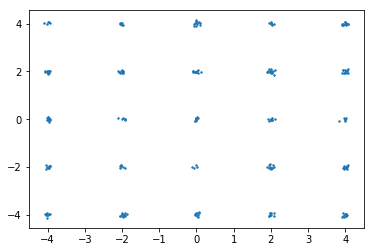

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 25

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc5(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.411e+00, generator: -7.928e-01


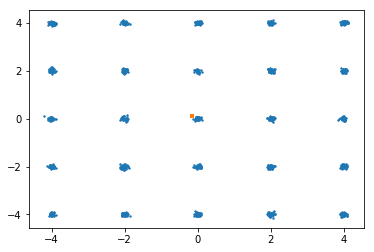

step 1000: discriminator: 1.872e-01, generator: -3.771e-02


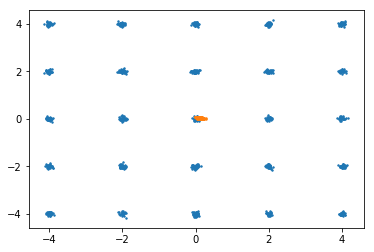

step 2000: discriminator: 1.925e-01, generator: -3.811e-02


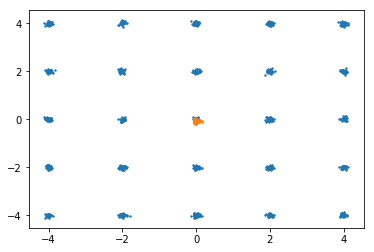

step 3000: discriminator: 2.044e-01, generator: -4.029e-02


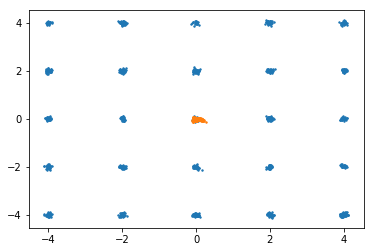

step 4000: discriminator: 1.278e-01, generator: -3.719e-02


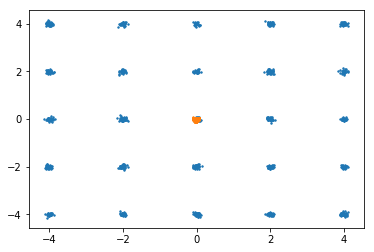

step 5000: discriminator: 8.987e-02, generator: -3.853e-02


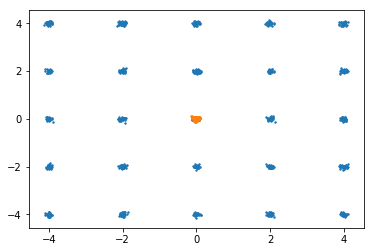

step 6000: discriminator: 1.796e-01, generator: -3.581e-02


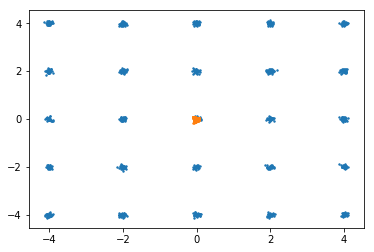

step 7000: discriminator: 1.793e-01, generator: -3.747e-02


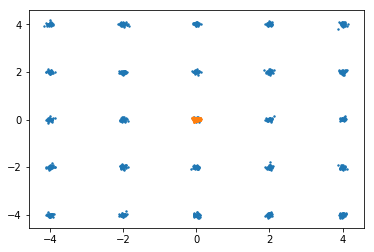

step 8000: discriminator: 1.157e-01, generator: -3.947e-02


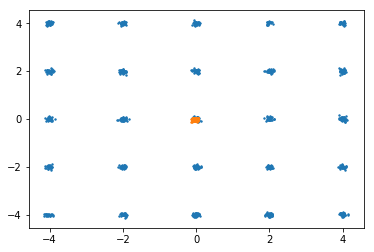

step 9000: discriminator: 1.921e-01, generator: -3.898e-02


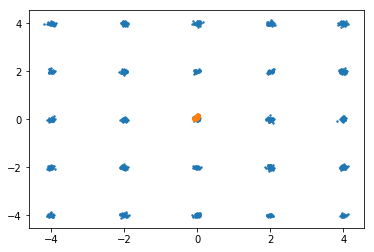

step 10000: discriminator: 1.408e-01, generator: -3.774e-02


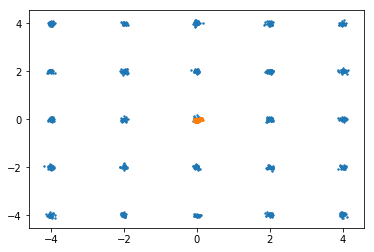

In [8]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 10
# Total number of training iterations for the generator
N_ITER = 10001
# Batch size to use
BATCHLEN = 256

discriminator_loss = []
generator_loss = []

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

for i in range(N_ITER):
    
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        
        disc_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator.__call__(real_batch)))/BATCHLEN + torch.sum(torch.nn.Softplus(beta=1)(discriminator.__call__(fake_batch)))/BATCHLEN
        
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    
    gen_loss = - torch.sum(torch.nn.Softplus(beta=1)(discriminator.__call__(fake_batch)))/BATCHLEN
    
    gen_loss.backward()
    optim_gen.step()
    discriminator_loss.append(disc_loss.detach())
    generator_loss.append(gen_loss.detach())
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

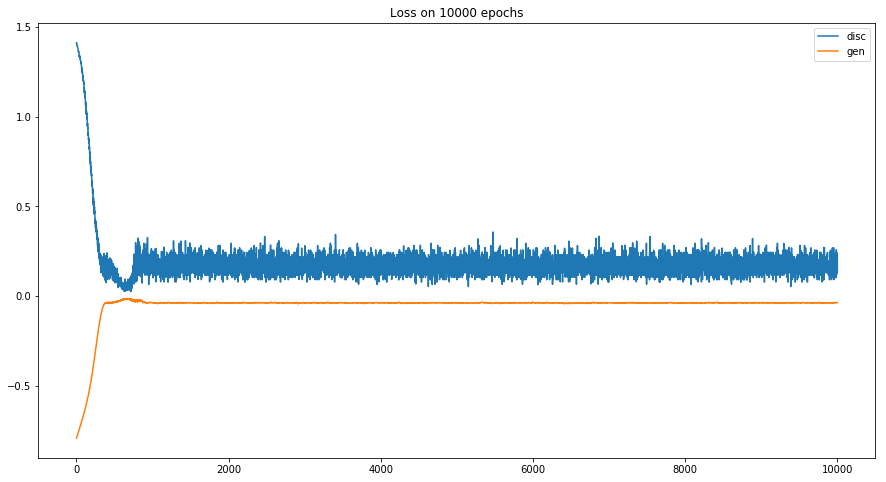

In [10]:
fig, a = plt.subplots(1,1, figsize=(15,8))
a.set_title('Loss on 10000 epochs')
a.plot(discriminator_loss, label='disc')
a.plot(generator_loss, label='gen')
a.legend()

<font color='blue'>
    
> **Interpretation**: The loss of the generator and the discrimator are showing that the training is highly unbalanced as the discriminator becomes too good for the generator. Hence the generator loss remains stucked after the initial increase. This problem might be related to the formulation of the loss function as stated below or the training ratio being too high in favor of the discriminator.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

<font color='blue'>

> Since the discriminator is first trained, we know it will reject the data following generator distribution. This will eventually lead to an estimation of the log_probability close to 1 and will result in the loss collapsing to zero as descripted above. Changing the loss function of the generator will help stabilize the learning.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

step 0: discriminator: 1.295e+00, generator: 5.870e-01


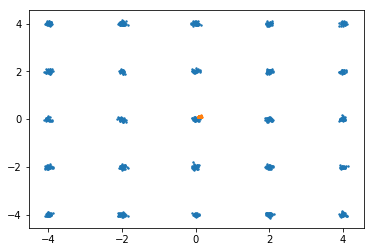

step 1000: discriminator: 1.641e+00, generator: 4.509e-01


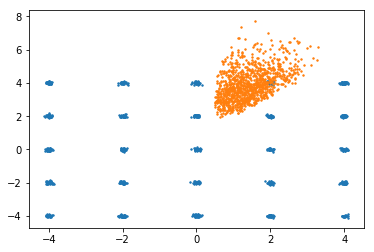

step 2000: discriminator: 1.081e+00, generator: 1.315e+00


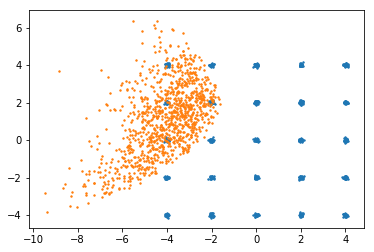

step 3000: discriminator: 1.623e+00, generator: 6.127e-01


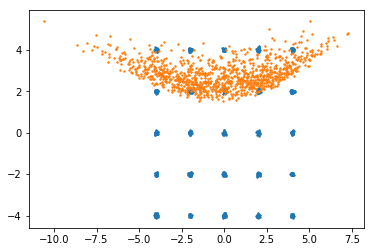

step 4000: discriminator: 1.449e+00, generator: 5.525e-01


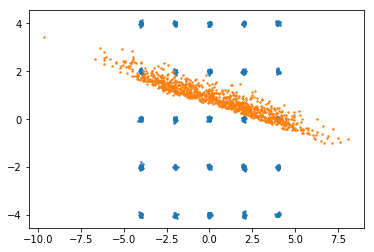

step 5000: discriminator: 8.924e-01, generator: 1.248e+00


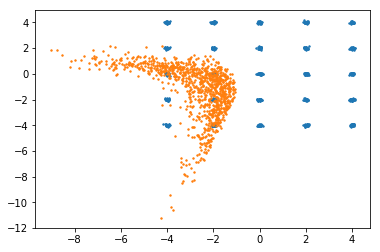

step 6000: discriminator: 1.191e+00, generator: 8.577e-01


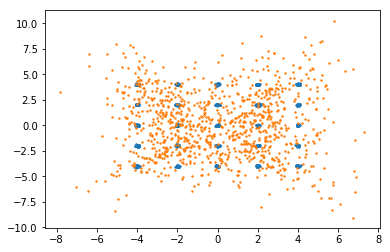

step 7000: discriminator: 9.507e-01, generator: 1.182e+00


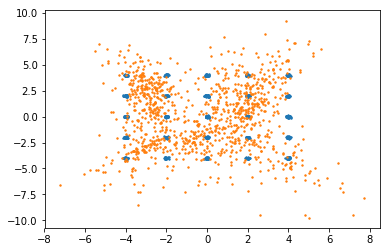

step 8000: discriminator: 7.207e-01, generator: 1.915e+00


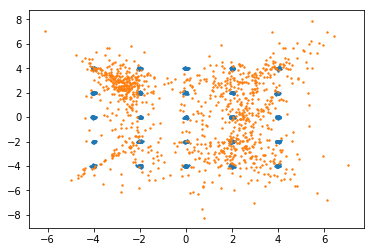

step 9000: discriminator: 5.810e-01, generator: 2.297e+00


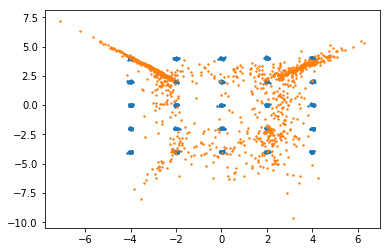

step 10000: discriminator: 5.095e-01, generator: 2.388e+00


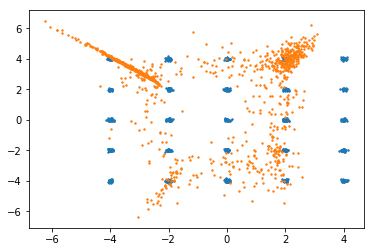

step 11000: discriminator: 5.059e-01, generator: 2.279e+00


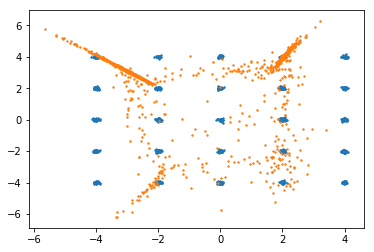

step 12000: discriminator: 4.259e-01, generator: 2.648e+00


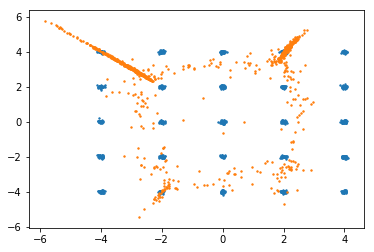

step 13000: discriminator: 3.307e-01, generator: 2.690e+00


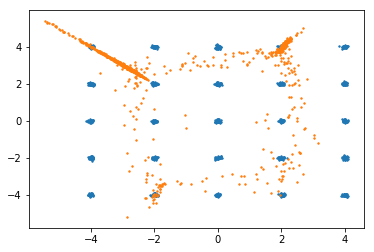

step 14000: discriminator: 4.574e-01, generator: 2.507e+00


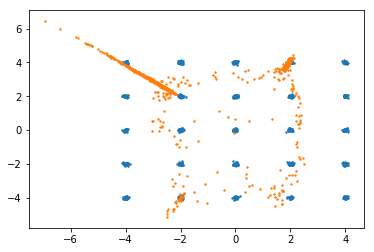

step 15000: discriminator: 4.156e-01, generator: 2.502e+00


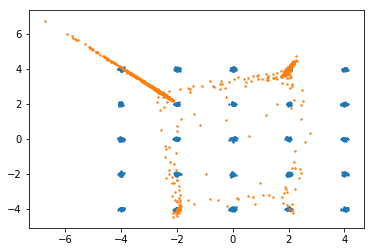

step 16000: discriminator: 4.659e-01, generator: 2.555e+00


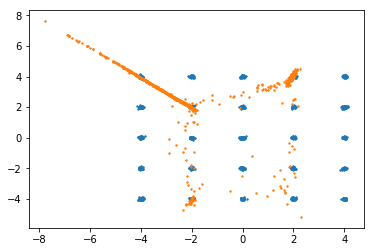

step 17000: discriminator: 4.898e-01, generator: 2.242e+00


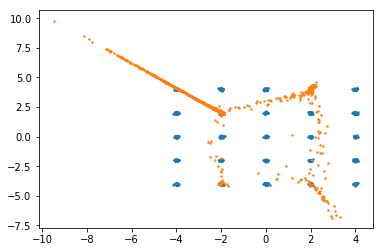

step 18000: discriminator: 5.333e-01, generator: 2.420e+00


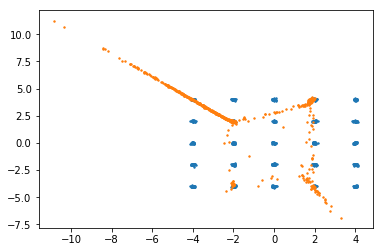

step 19000: discriminator: 4.762e-01, generator: 2.410e+00


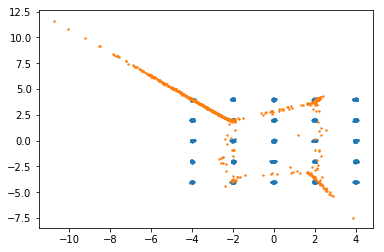

step 20000: discriminator: 4.490e-01, generator: 2.138e+00


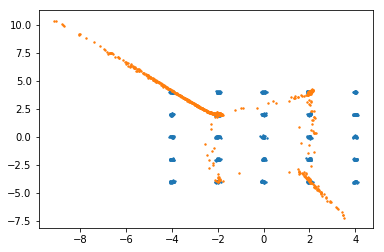

step 21000: discriminator: 4.409e-01, generator: 2.318e+00


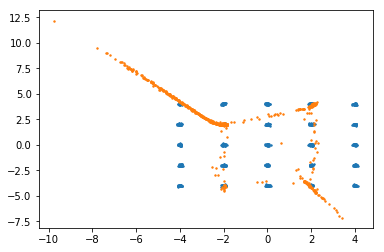

step 22000: discriminator: 5.298e-01, generator: 2.271e+00


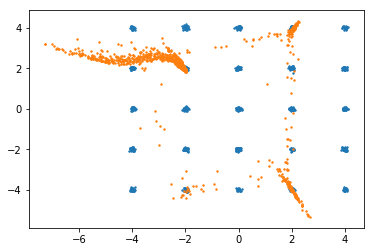

step 23000: discriminator: 5.959e-01, generator: 2.101e+00


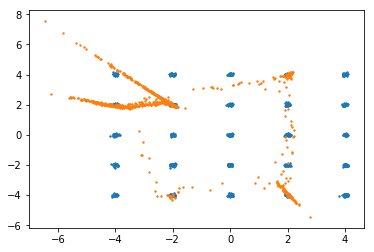

step 24000: discriminator: 4.741e-01, generator: 2.335e+00


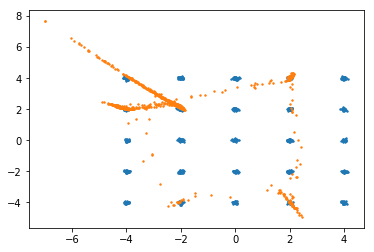

step 25000: discriminator: 5.124e-01, generator: 2.271e+00


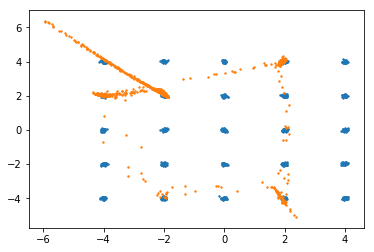

step 26000: discriminator: 5.213e-01, generator: 2.228e+00


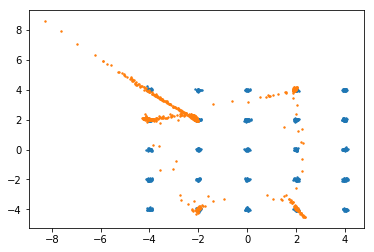

step 27000: discriminator: 5.175e-01, generator: 2.253e+00


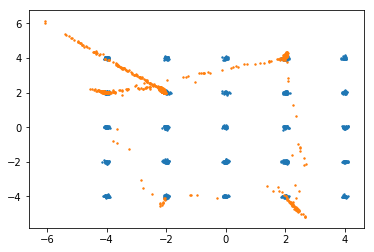

step 28000: discriminator: 5.037e-01, generator: 2.139e+00


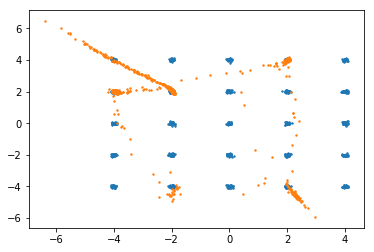

step 29000: discriminator: 4.630e-01, generator: 2.247e+00


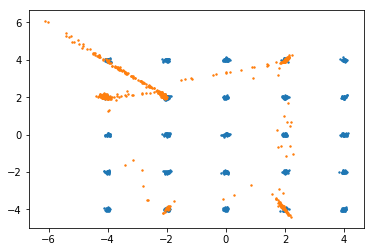

step 30000: discriminator: 5.314e-01, generator: 2.329e+00


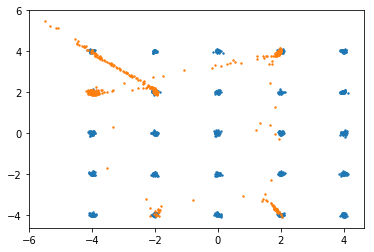

step 31000: discriminator: 4.843e-01, generator: 2.517e+00


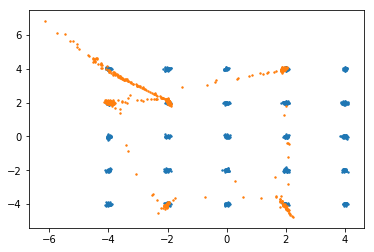

step 32000: discriminator: 5.534e-01, generator: 1.929e+00


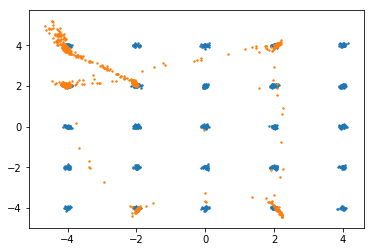

step 33000: discriminator: 5.190e-01, generator: 2.256e+00


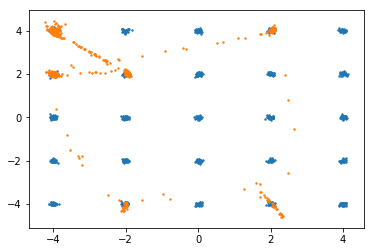

step 34000: discriminator: 5.472e-01, generator: 2.077e+00


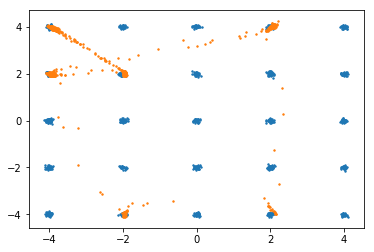

step 35000: discriminator: 5.094e-01, generator: 2.225e+00


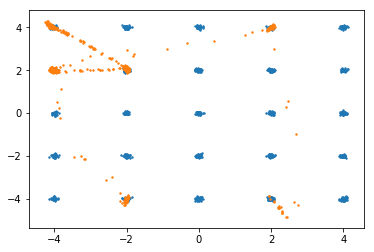

step 36000: discriminator: 5.069e-01, generator: 2.040e+00


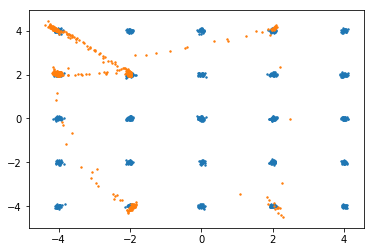

step 37000: discriminator: 4.124e-01, generator: 2.295e+00


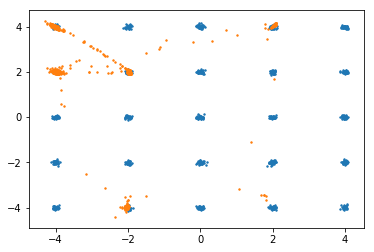

step 38000: discriminator: 4.841e-01, generator: 2.223e+00


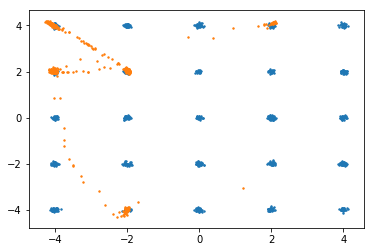

step 39000: discriminator: 5.584e-01, generator: 2.347e+00


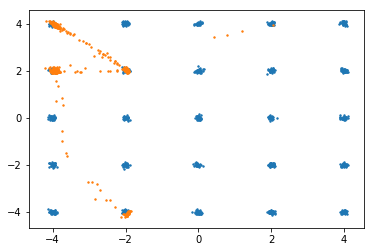

step 40000: discriminator: 4.050e-01, generator: 2.092e+00


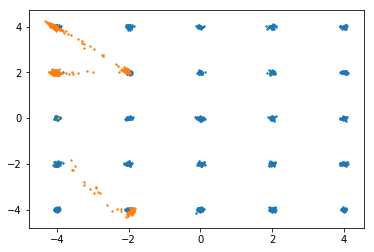

step 41000: discriminator: 4.212e-01, generator: 2.253e+00


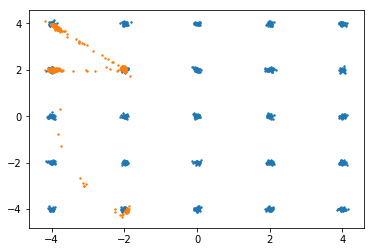

step 42000: discriminator: 3.863e-01, generator: 2.365e+00


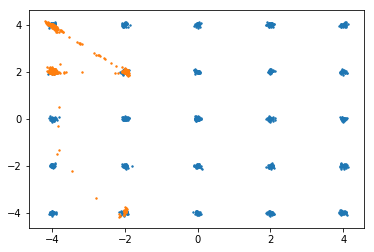

step 43000: discriminator: 5.008e-01, generator: 2.130e+00


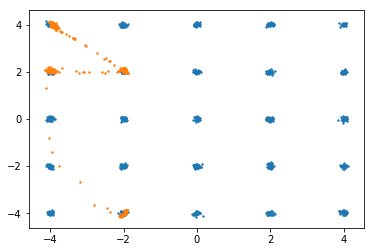

step 44000: discriminator: 4.129e-01, generator: 2.308e+00


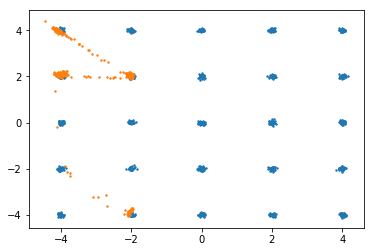

step 45000: discriminator: 3.934e-01, generator: 2.214e+00


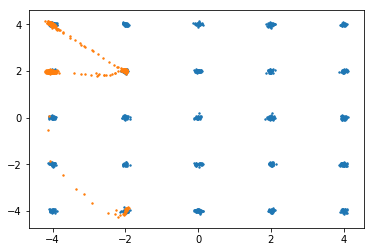

step 46000: discriminator: 4.063e-01, generator: 2.331e+00


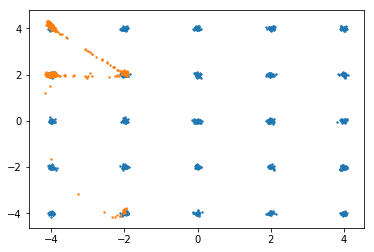

step 47000: discriminator: 3.763e-01, generator: 2.343e+00


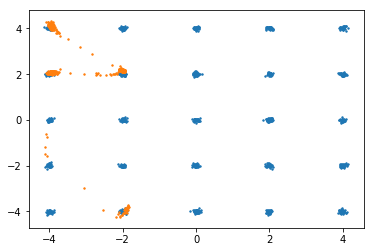

step 48000: discriminator: 4.231e-01, generator: 2.330e+00


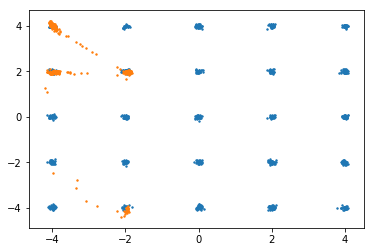

step 49000: discriminator: 3.625e-01, generator: 2.267e+00


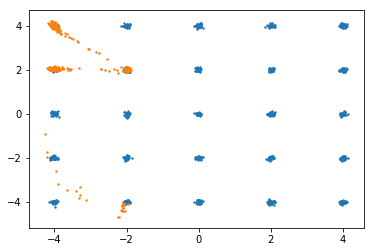

step 50000: discriminator: 3.323e-01, generator: 2.306e+00


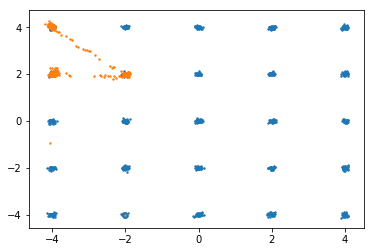

In [87]:
# Choose a value for the prior dimension
PRIOR_N = 25
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 6 
# Total number of training iterations for the generator
N_ITER = 50001
# Batch size to use
BATCHLEN = 256

discriminator_loss = []
generator_loss = []

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc5(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)


generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

for i in range(N_ITER):
    
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        disc_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator.__call__(real_batch)))/BATCHLEN + torch.sum(torch.nn.Softplus(beta=1)(discriminator.__call__(fake_batch)))/BATCHLEN
        disc_loss.backward()
        optim_disc.step()
        
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    gen_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator.__call__(fake_batch)))/BATCHLEN
    gen_loss.backward()
    optim_gen.step()
    discriminator_loss.append(disc_loss.detach())
    generator_loss.append(gen_loss.detach())
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

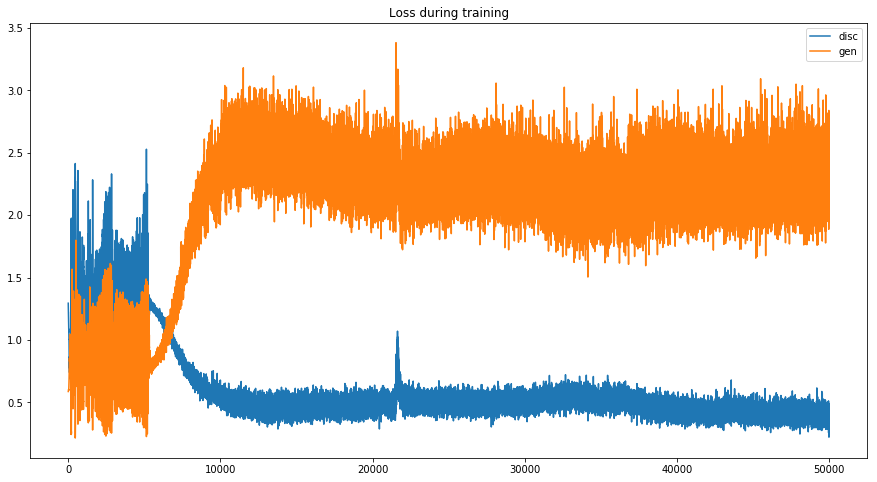

In [88]:
fig, a = plt.subplots(1,1, figsize=(15,8))
a.set_title('Loss during training')
a.plot(discriminator_loss, label='disc')
a.plot(generator_loss, label='gen')
a.legend()

## An other generator architecture

step 0: discriminator: 1.409e+00, generator: 7.441e-01


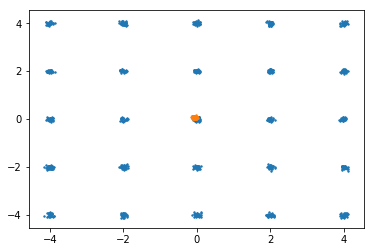

step 1000: discriminator: 1.354e+00, generator: 5.585e-01


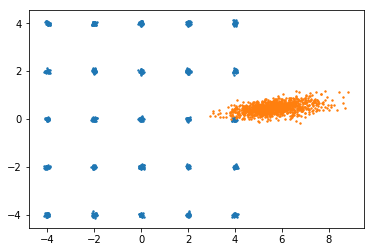

step 2000: discriminator: 1.266e+00, generator: 7.269e-01


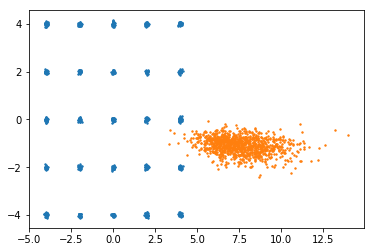

step 3000: discriminator: 1.236e+00, generator: 9.668e-01


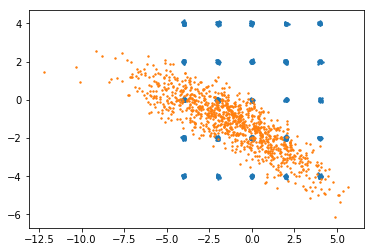

step 4000: discriminator: 1.281e+00, generator: 8.135e-01


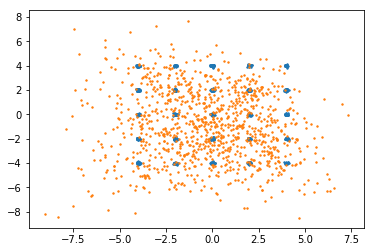

step 5000: discriminator: 9.516e-01, generator: 1.052e+00


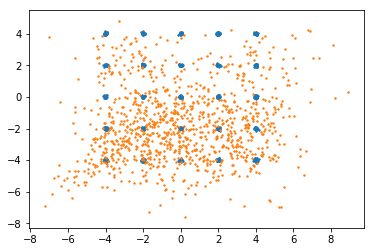

step 6000: discriminator: 7.640e-01, generator: 1.630e+00


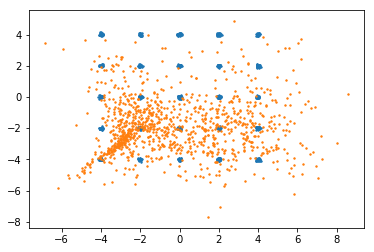

step 7000: discriminator: 5.183e-01, generator: 2.172e+00


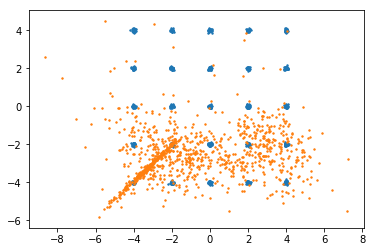

step 8000: discriminator: 4.660e-01, generator: 2.535e+00


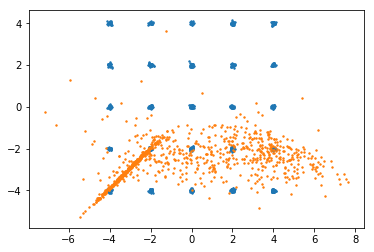

step 9000: discriminator: 4.768e-01, generator: 2.141e+00


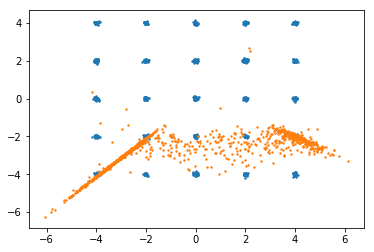

step 10000: discriminator: 4.058e-01, generator: 2.750e+00


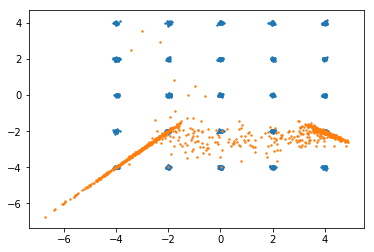

step 11000: discriminator: 3.476e-01, generator: 2.829e+00


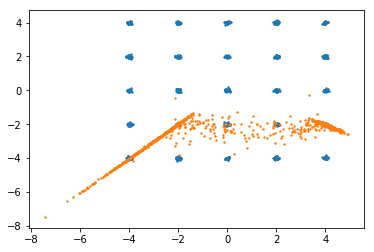

step 12000: discriminator: 4.661e-01, generator: 2.607e+00


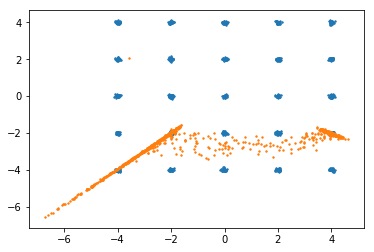

step 13000: discriminator: 3.319e-01, generator: 2.864e+00


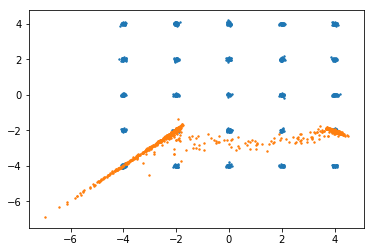

step 14000: discriminator: 2.878e-01, generator: 2.985e+00


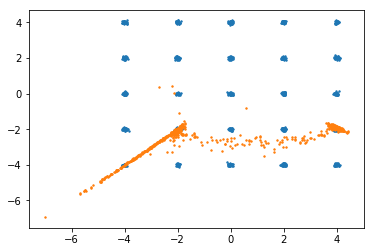

step 15000: discriminator: 3.758e-01, generator: 2.481e+00


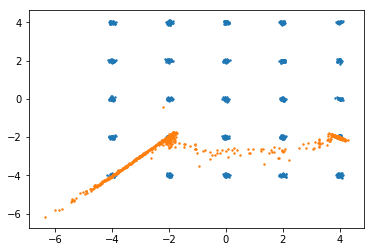

step 16000: discriminator: 3.881e-01, generator: 2.528e+00


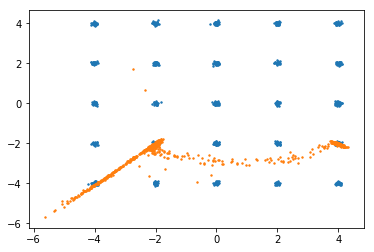

step 17000: discriminator: 4.657e-01, generator: 2.644e+00


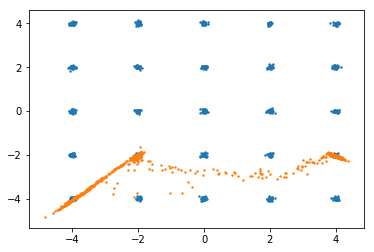

step 18000: discriminator: 3.295e-01, generator: 2.679e+00


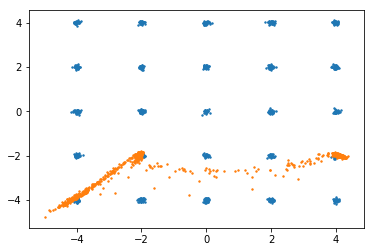

step 19000: discriminator: 3.419e-01, generator: 2.899e+00


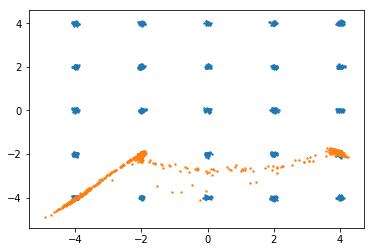

step 20000: discriminator: 2.951e-01, generator: 2.650e+00


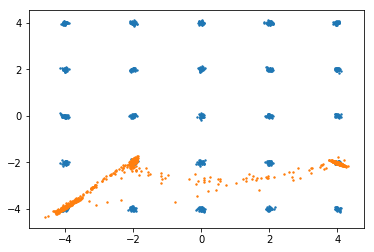

step 21000: discriminator: 3.958e-01, generator: 2.405e+00


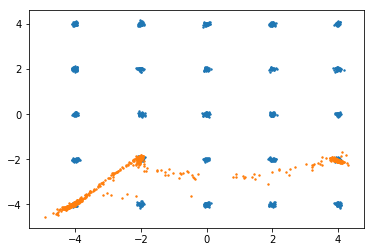

step 22000: discriminator: 3.169e-01, generator: 2.770e+00


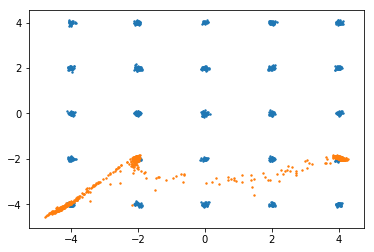

step 23000: discriminator: 3.524e-01, generator: 2.490e+00


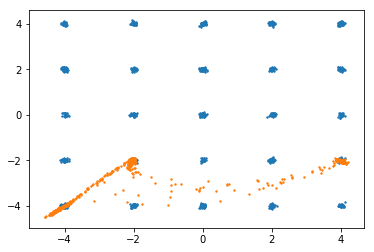

step 24000: discriminator: 3.762e-01, generator: 2.566e+00


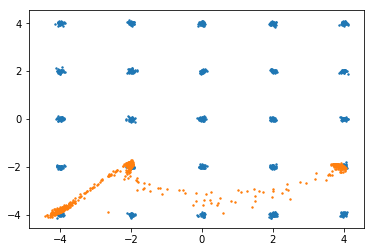

step 25000: discriminator: 3.478e-01, generator: 2.663e+00


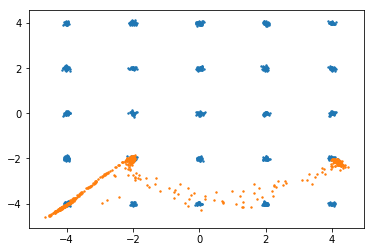

step 26000: discriminator: 3.641e-01, generator: 2.629e+00


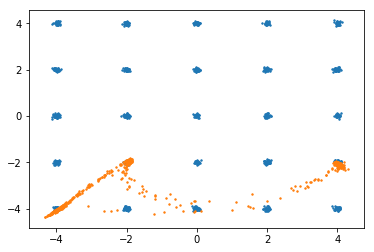

step 27000: discriminator: 3.453e-01, generator: 2.692e+00


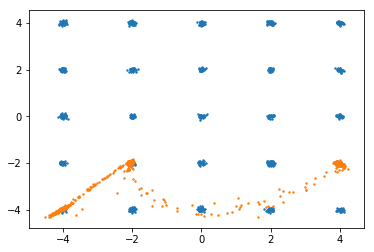

step 28000: discriminator: 4.250e-01, generator: 2.573e+00


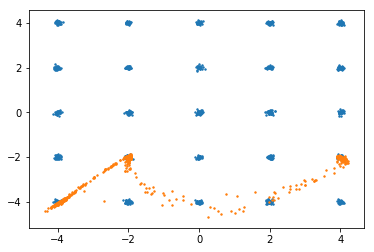

step 29000: discriminator: 3.733e-01, generator: 2.746e+00


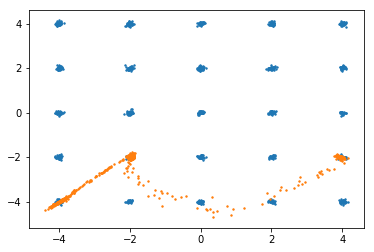

step 30000: discriminator: 3.889e-01, generator: 2.596e+00


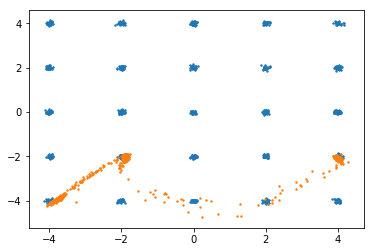

step 31000: discriminator: 3.473e-01, generator: 2.496e+00


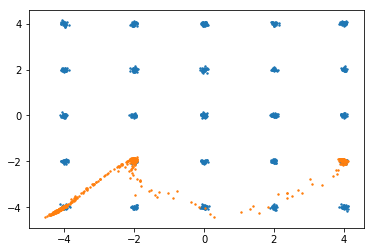

KeyboardInterrupt: 

In [217]:
# Choose a value for the prior dimension
PRIOR_N = 25
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 6 
# Total number of training iterations for the generator
N_ITER = 40001
# Batch size to use
BATCHLEN = 256

discriminator_loss = []
generator_loss = []

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)


generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

for i in range(N_ITER):
    
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        disc_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator.__call__(real_batch)))/BATCHLEN + torch.sum(torch.nn.Softplus(beta=1)(discriminator.__call__(fake_batch)))/BATCHLEN
        disc_loss.backward()
        optim_disc.step()
        
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    gen_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator.__call__(fake_batch)))/BATCHLEN
    gen_loss.backward()
    optim_gen.step()
    discriminator_loss.append(disc_loss.detach())
    generator_loss.append(gen_loss.detach())
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

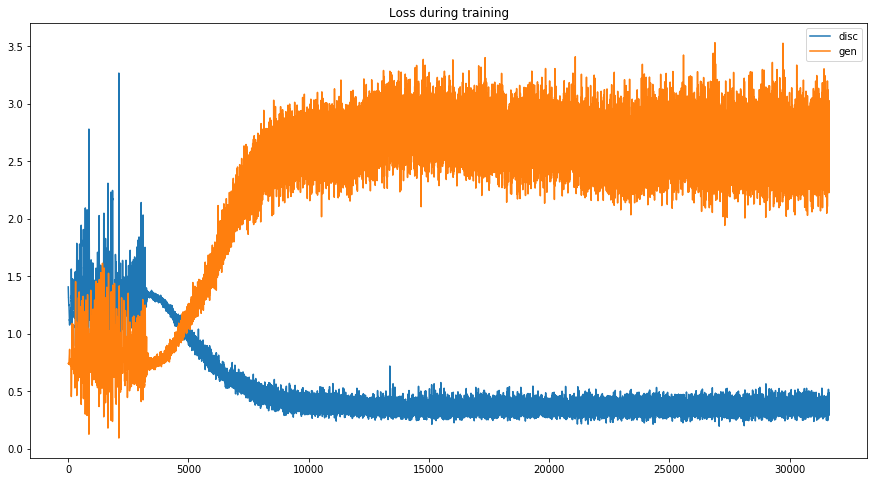

In [218]:
fig, a = plt.subplots(1,1, figsize=(15,8))
a.set_title('Loss during training')
a.plot(discriminator_loss, label='disc')
a.plot(generator_loss, label='gen')
a.legend()

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

<font color='blue'>
    
In the following work, we present the result of 20000 iterations of training for GANs with different combinations of hyperparameters. The comparisons and the architectures are volontarely reduced for time of computation reasons, Hence a lot of these combinations are not converging, which validates the difficulty of training GANs. Below is shown a diagramm of the general architecture of the 2 networks we used to conduct the experiment. 

> **Dimension of prior**: parameters (**10,50**) 

The prior dimension might intuitively helps the generator generate more diverse data as the noise becomes more more complex. However, it slows down the training as the generator is oscillating a long time before exploring a sufficiently large part of the prior noise space to yeald realistic data.

> **Impact of TRAIN_RATIO**: parameters (**3,7,20**) 

The temporal performance of the training process is logically deteriorated by the increase of TRAIN_RATIO as we increase the number of training iterations for the discriminator. Moreover, setting a ratio too high will result in an unbalanced competition between the discriminator and the generator resulting in the generator failing to learn a good representation of the data (especially for simpler version of the disciminator). Conversely, increasing this number helps the model learn faster as the discriminator is better thanks to more training. Hence there is an optimal ratio to find. 7 seems here an optimal choice for our architecture.

> **Depth /idth of the generator network**: parameters (**512,256**) 

A wider generator network yealds more diverse representations of the data that helps avoid the problem of mode dropping that we had in the first instance. Stacking more layer in depth seems to result in a more unstable training process as show by the loss comparison. However there seems to be a "critical lenghth" below wich the generator cannot represent the distribution and fails to converge, which accounts for the architecture we retained for the experiment.

> **Depth / width of the discriminator network**: parameters (**64,32**) 

A wider discriminator network seems to yeald a more variable loss function during the training.(figure 4 below) After 20000 iterations, the generator loss is higher and the discriminator loss is lower. This seems to show that the discriminator "outperforms" the generator leading in poorer training performance of the generator.


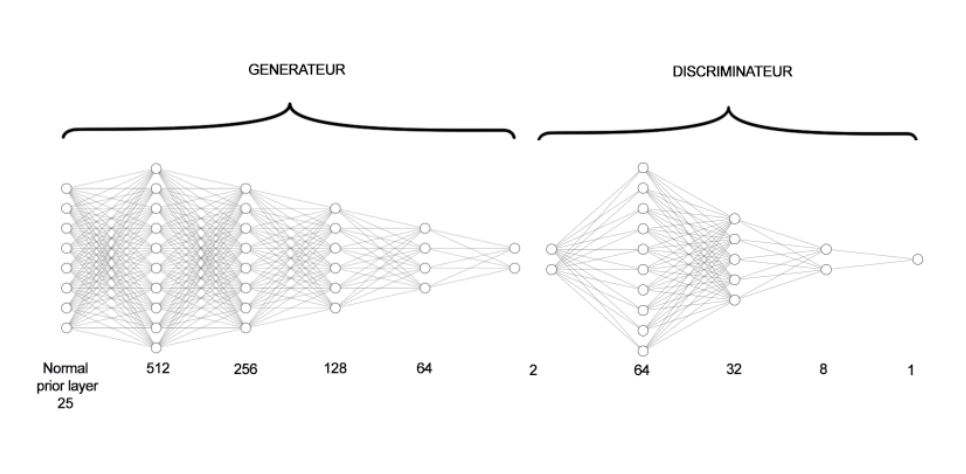

In [90]:
from IPython.display import Image
Image(filename='Architecture.png') 

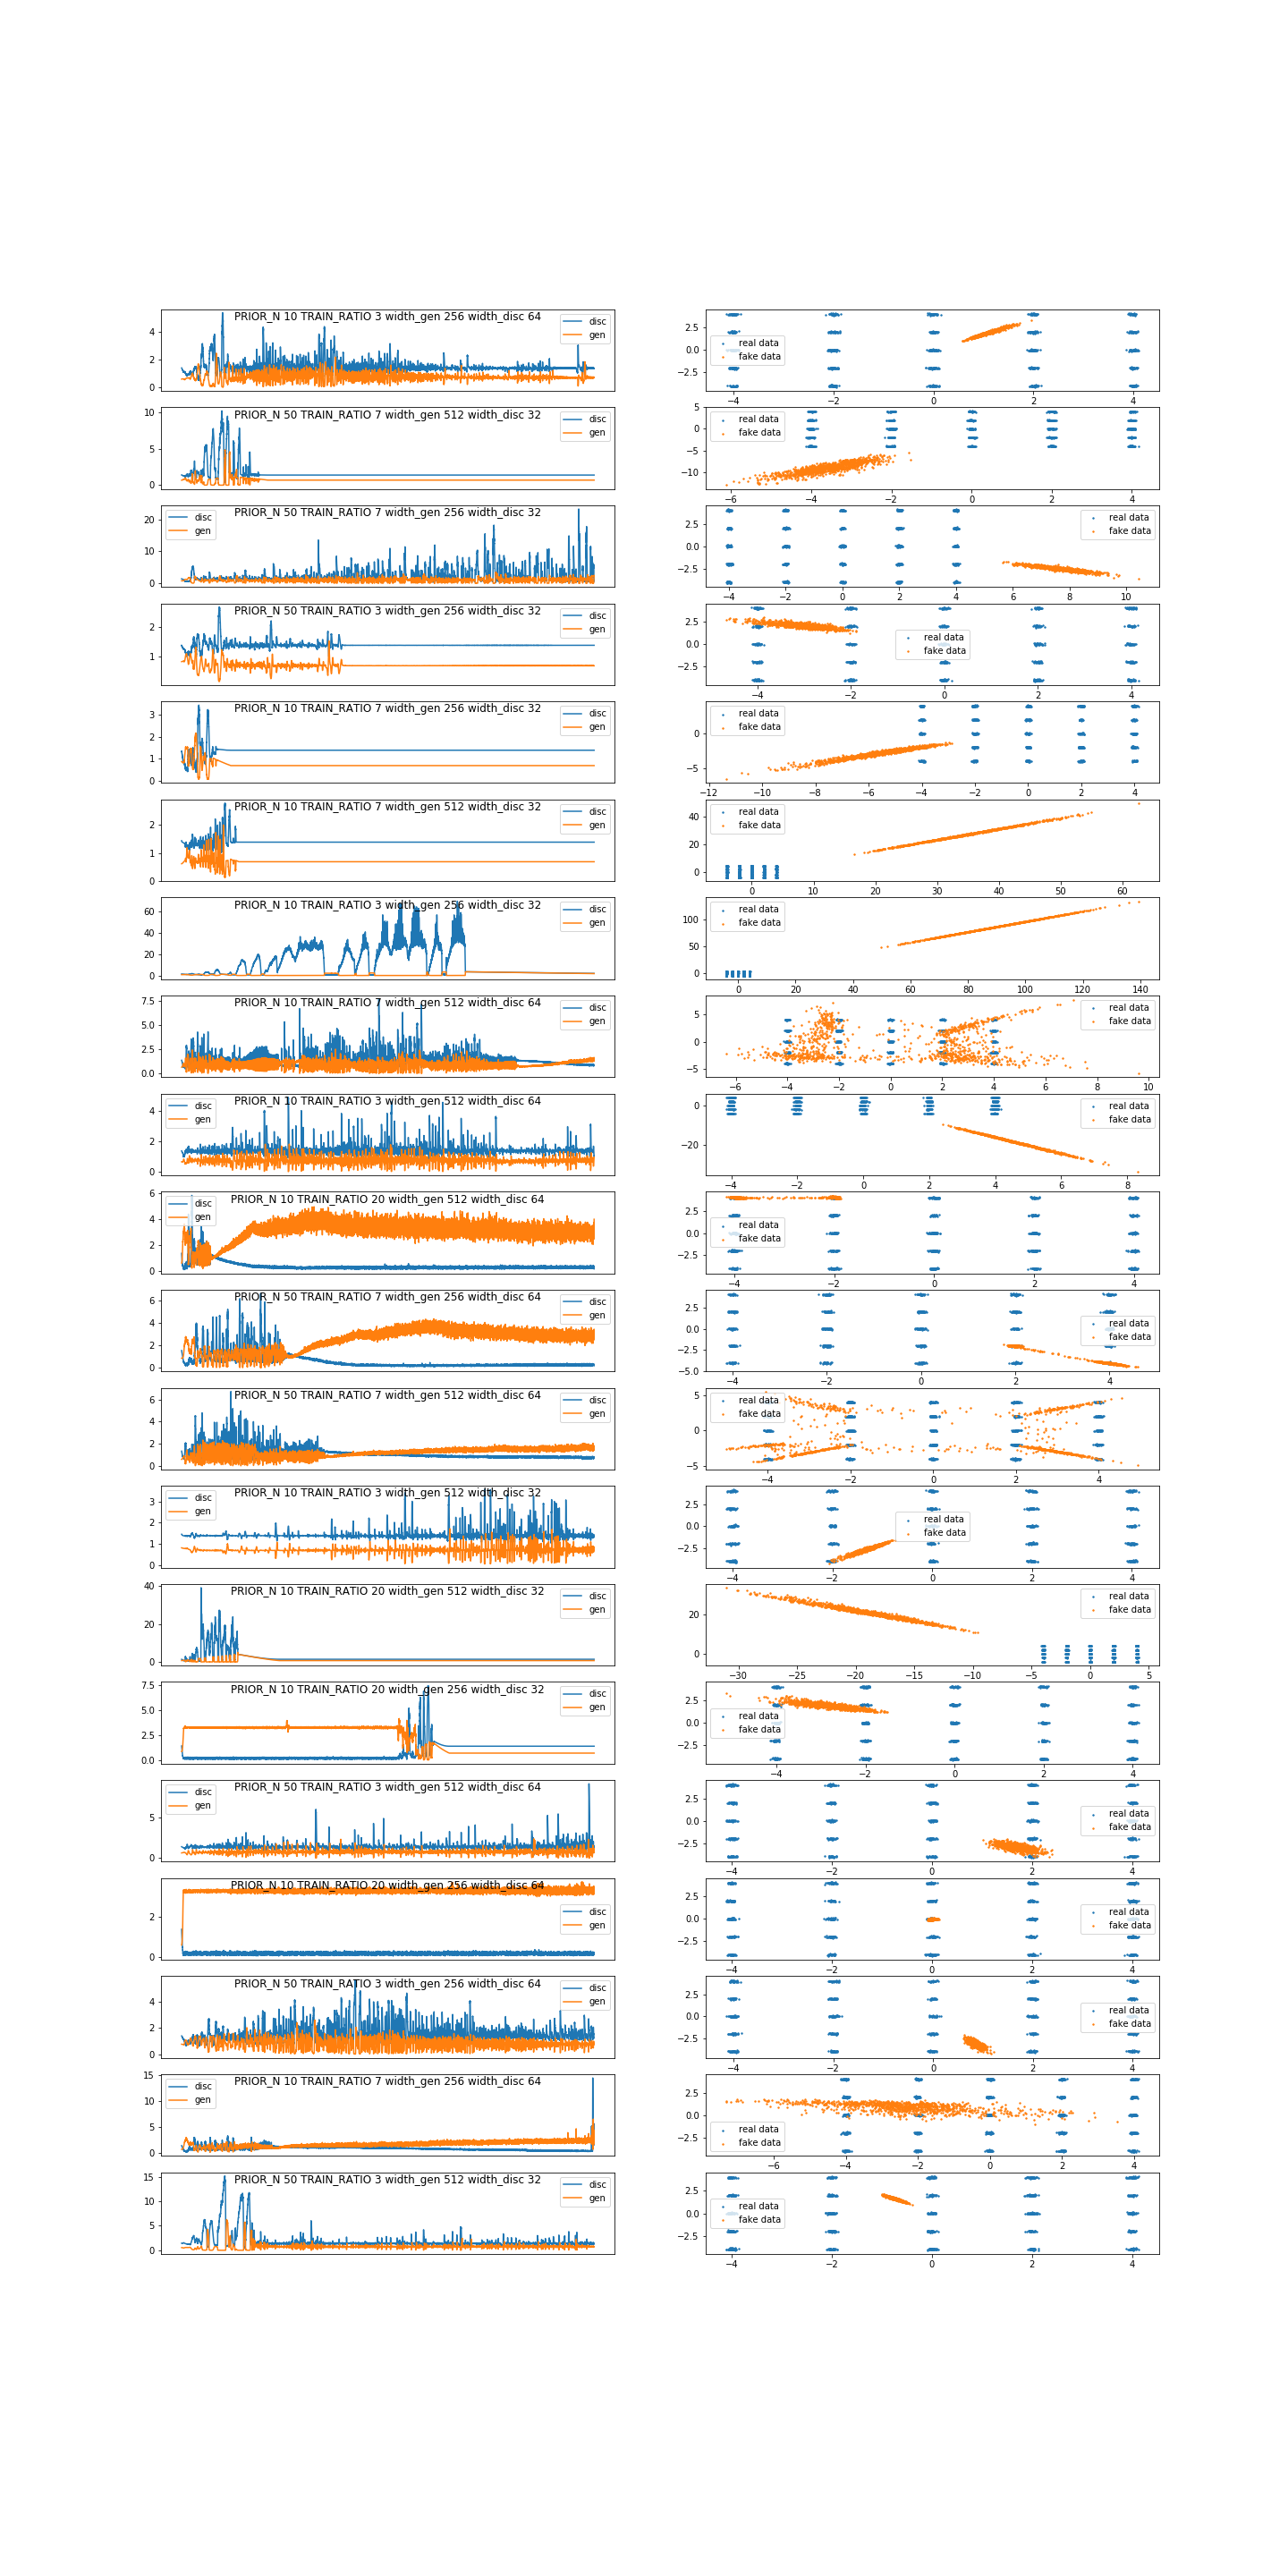

In [106]:
from IPython.display import Image
Image(filename='GAN hyperparameters exploration 2.png') 

#### Parameters tested: Train ratio = 5,10 / Disc shape = 2x30 fully connected , 4x5 fc / Gen shape = 2x30 fc, 4x5 fc

<font color='blue'>
    
**NB** : For readability reasons, I inserted parameters variations as commentary of the cell below

parameters: 10 3 512 64
step 0: discriminator: 1.384e+00, generator: 6.619e-01


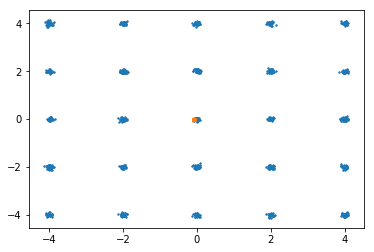

step 1000: discriminator: 1.341e+00, generator: 7.295e-01


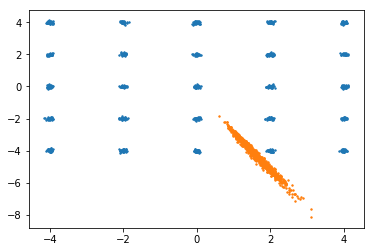

step 2000: discriminator: 1.176e+00, generator: 1.110e+00


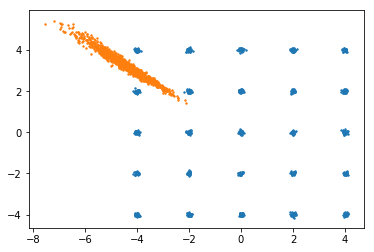

step 3000: discriminator: 1.194e+00, generator: 9.969e-01


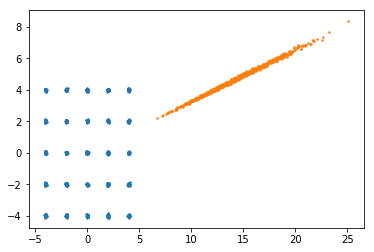

step 4000: discriminator: 3.108e+00, generator: 8.148e-02


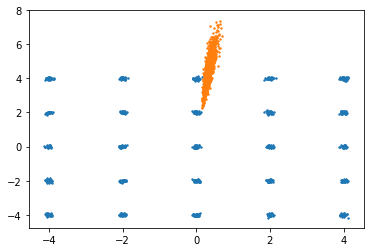

step 5000: discriminator: 1.416e+00, generator: 7.020e-01


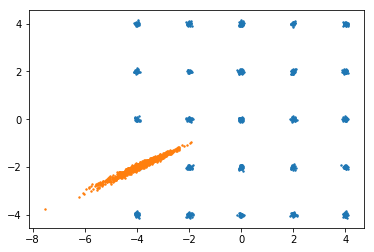

step 6000: discriminator: 1.300e+00, generator: 8.591e-01


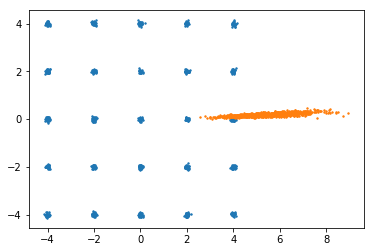

step 7000: discriminator: 1.555e+00, generator: 4.835e-01


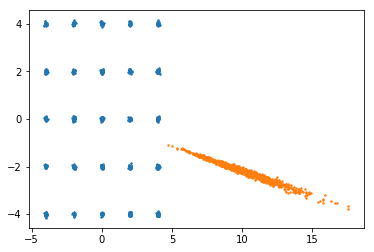

step 8000: discriminator: 1.566e+00, generator: 1.008e+00


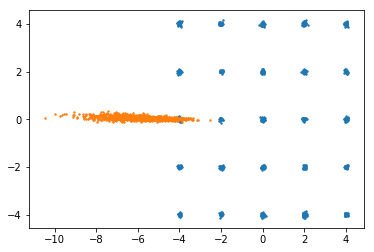

step 9000: discriminator: 1.465e+00, generator: 8.141e-01


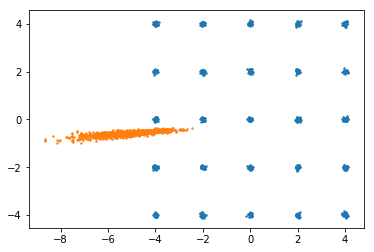

step 10000: discriminator: 1.438e+00, generator: 6.909e-01


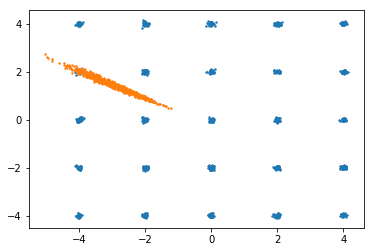

step 11000: discriminator: 1.310e+00, generator: 1.231e+00


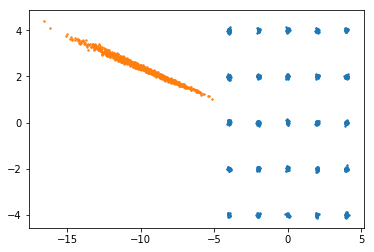

step 12000: discriminator: 9.533e-01, generator: 7.102e-01


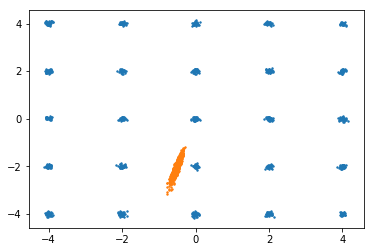

step 13000: discriminator: 1.293e+00, generator: 1.036e+00


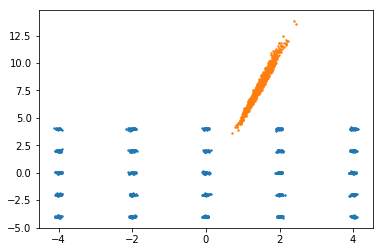

step 14000: discriminator: 1.456e+00, generator: 6.648e-01


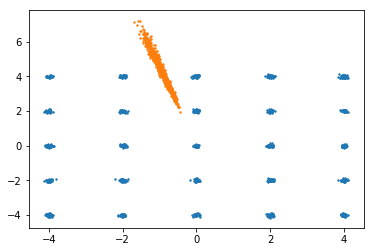

step 15000: discriminator: 1.337e+00, generator: 7.747e-01


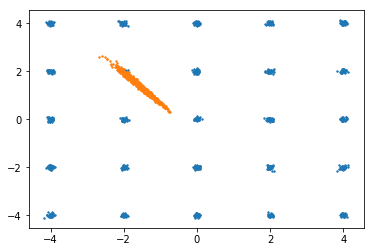

step 16000: discriminator: 1.457e+00, generator: 6.234e-01


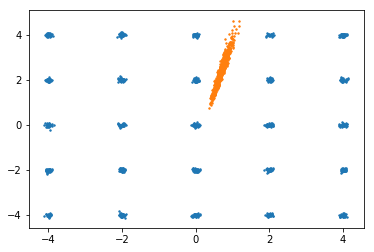

step 17000: discriminator: 1.506e+00, generator: 6.997e-01


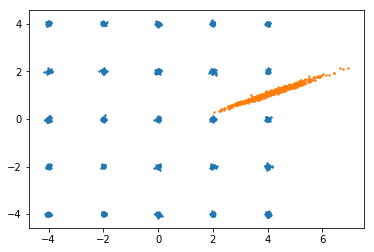

step 18000: discriminator: 1.273e+00, generator: 1.093e+00


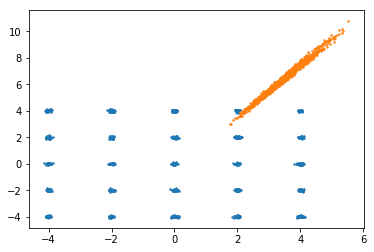

step 19000: discriminator: 1.140e+00, generator: 8.425e-01


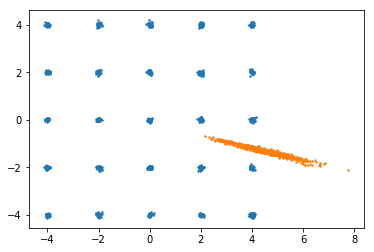

step 20000: discriminator: 1.013e+00, generator: 9.682e-01


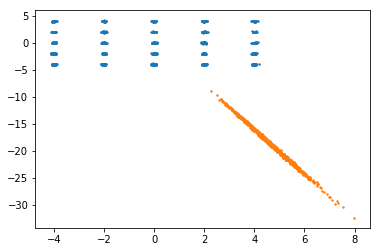

parameters: 10 3 512 32
step 0: discriminator: 1.455e+00, generator: 8.171e-01


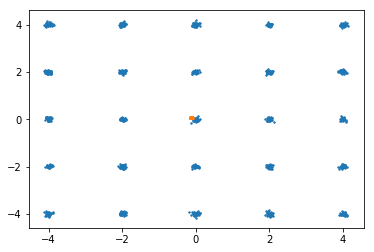

step 1000: discriminator: 1.378e+00, generator: 7.013e-01


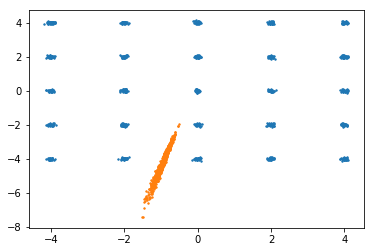

step 2000: discriminator: 1.469e+00, generator: 6.033e-01


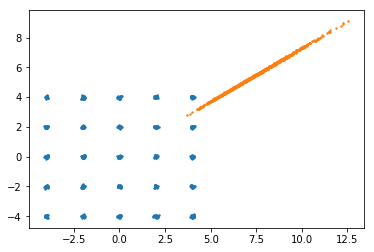

step 3000: discriminator: 1.385e+00, generator: 6.958e-01


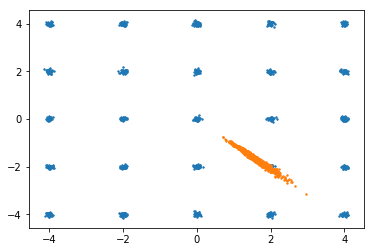

step 4000: discriminator: 1.386e+00, generator: 6.946e-01


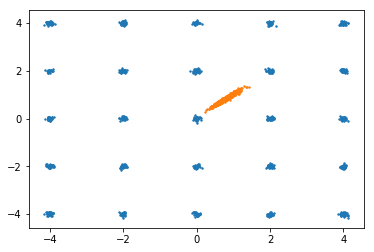

step 5000: discriminator: 1.346e+00, generator: 7.543e-01


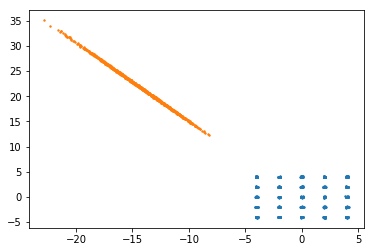

step 6000: discriminator: 1.390e+00, generator: 6.844e-01


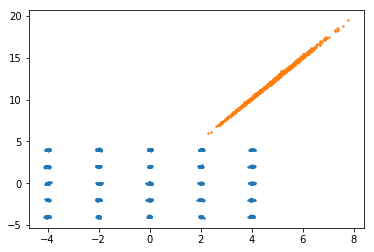

step 7000: discriminator: 1.417e+00, generator: 6.473e-01


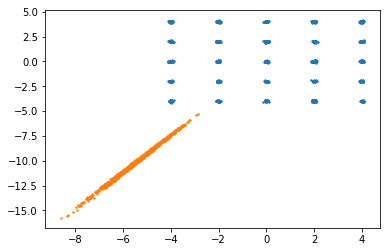

step 8000: discriminator: 1.600e+00, generator: 5.040e-01


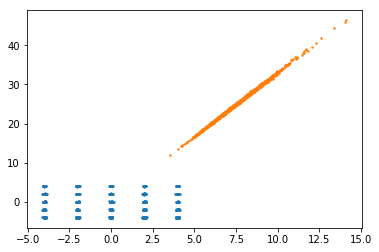

step 9000: discriminator: 1.359e+00, generator: 7.118e-01


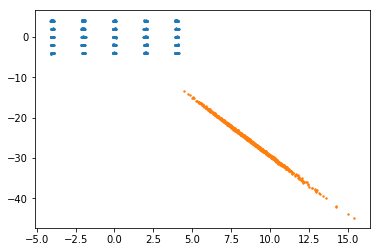

step 10000: discriminator: 1.332e+00, generator: 7.971e-01


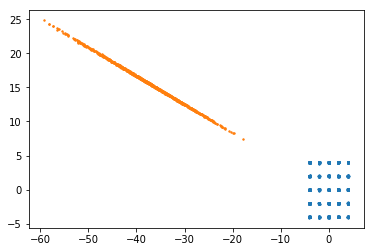

step 11000: discriminator: 1.361e+00, generator: 7.266e-01


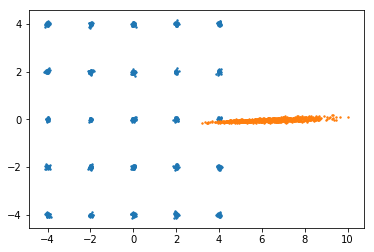

step 12000: discriminator: 1.431e+00, generator: 6.678e-01


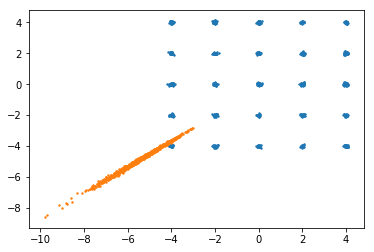

step 13000: discriminator: 1.017e+00, generator: 1.699e+00


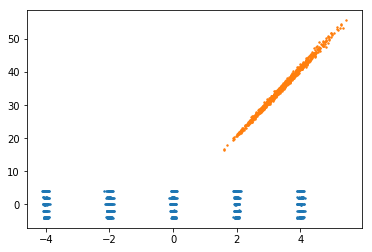

step 14000: discriminator: 1.385e+00, generator: 6.087e-01


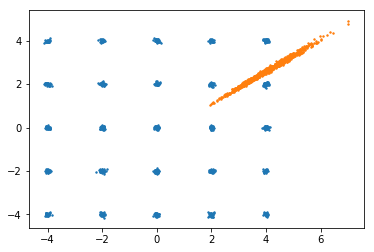

step 15000: discriminator: 2.434e+00, generator: 2.171e-01


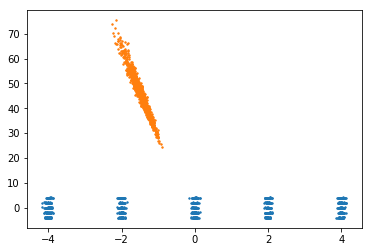

step 16000: discriminator: 1.256e+00, generator: 7.242e-01


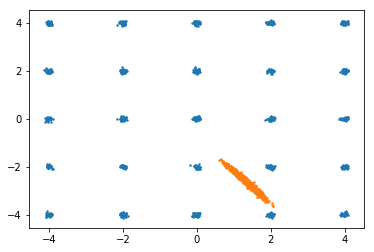

step 17000: discriminator: 1.383e+00, generator: 8.233e-01


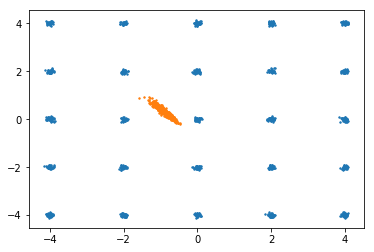

step 18000: discriminator: 1.434e+00, generator: 7.458e-01


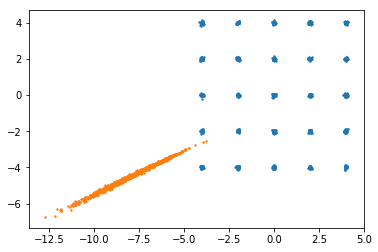

step 19000: discriminator: 1.351e+00, generator: 8.013e-01


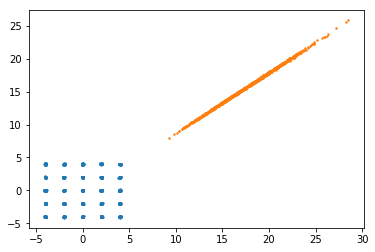

step 20000: discriminator: 1.383e+00, generator: 7.049e-01


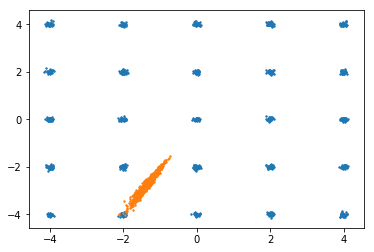

parameters: 10 3 256 64
step 0: discriminator: 1.400e+00, generator: 5.890e-01


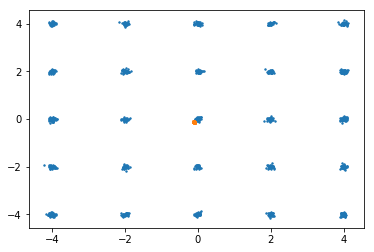

step 1000: discriminator: 3.009e+00, generator: 1.109e-01


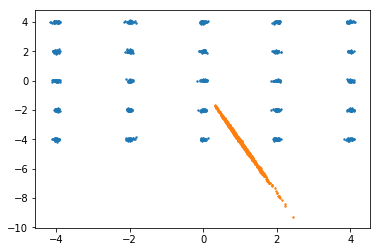

step 2000: discriminator: 5.040e+00, generator: 2.009e-02


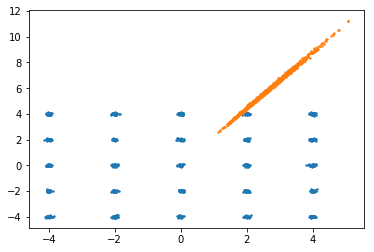

step 3000: discriminator: 1.379e+00, generator: 5.087e-01


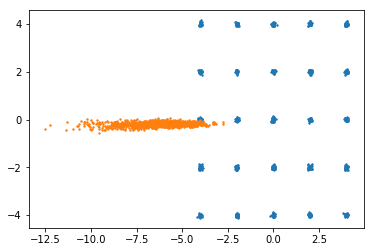

step 4000: discriminator: 1.407e+00, generator: 1.319e+00


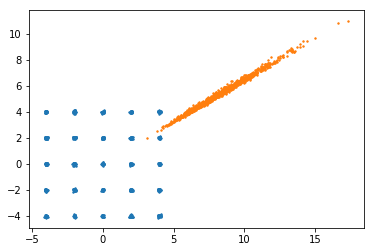

step 5000: discriminator: 2.249e+00, generator: 3.061e-01


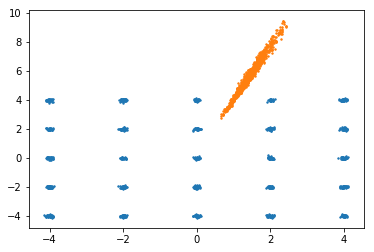

step 6000: discriminator: 1.179e+00, generator: 1.006e+00


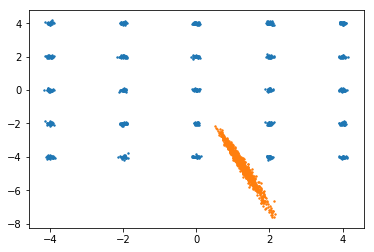

step 7000: discriminator: 1.154e+00, generator: 1.202e+00


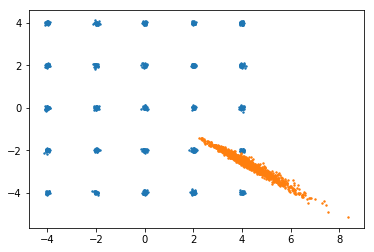

step 8000: discriminator: 1.299e+00, generator: 7.793e-01


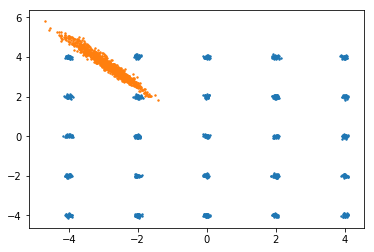

step 9000: discriminator: 1.222e+00, generator: 8.744e-01


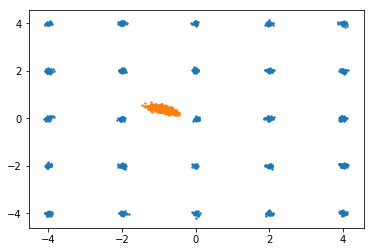

step 10000: discriminator: 1.495e+00, generator: 9.881e-01


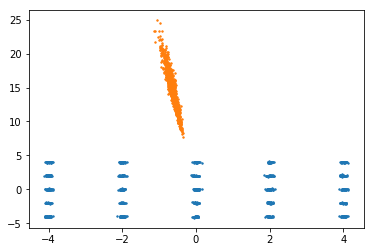

step 11000: discriminator: 1.606e+00, generator: 7.088e-01


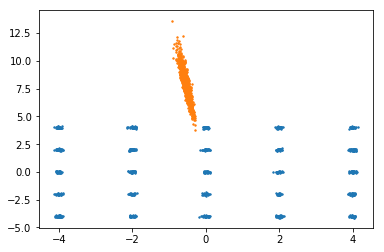

step 12000: discriminator: 1.272e+00, generator: 8.335e-01


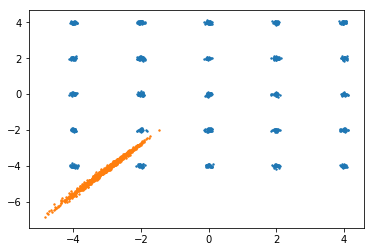

step 13000: discriminator: 1.390e+00, generator: 6.989e-01


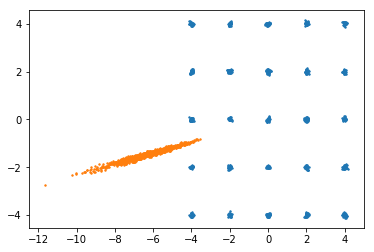

step 14000: discriminator: 1.355e+00, generator: 6.981e-01


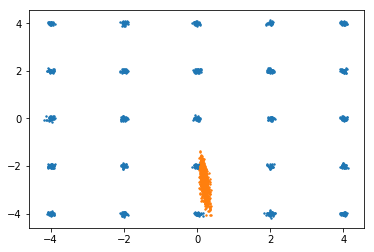

step 15000: discriminator: 1.382e+00, generator: 7.600e-01


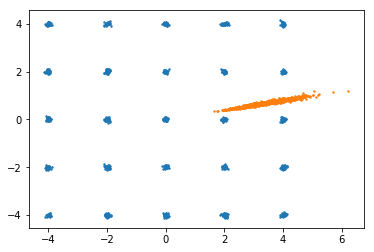

step 16000: discriminator: 1.439e+00, generator: 6.416e-01


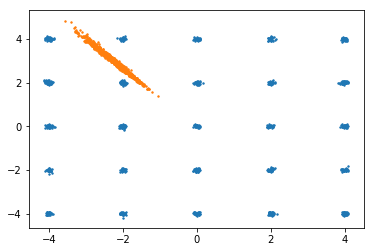

step 17000: discriminator: 1.280e+00, generator: 7.579e-01


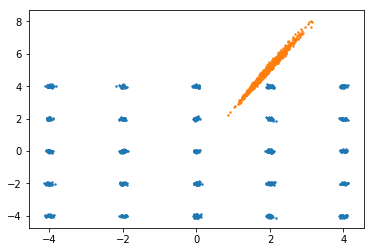

step 18000: discriminator: 1.197e+00, generator: 1.165e+00


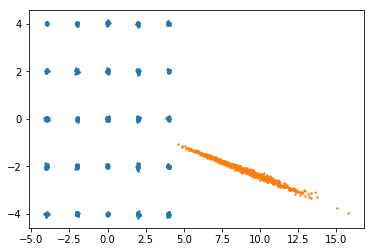

step 19000: discriminator: 1.387e+00, generator: 6.879e-01


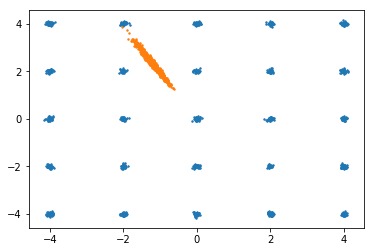

step 20000: discriminator: 1.361e+00, generator: 7.330e-01


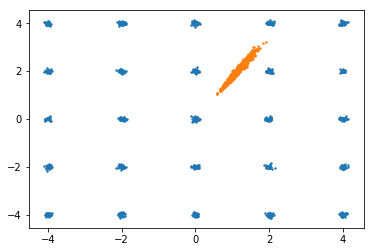

parameters: 10 3 256 32
step 0: discriminator: 1.413e+00, generator: 8.036e-01


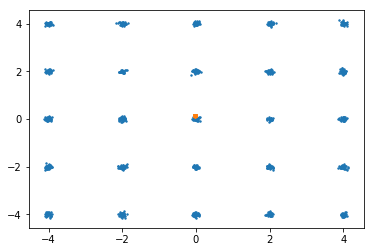

step 1000: discriminator: 7.218e-01, generator: 1.002e+00


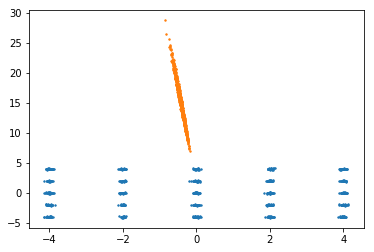

step 2000: discriminator: 1.299e+00, generator: 1.079e+00


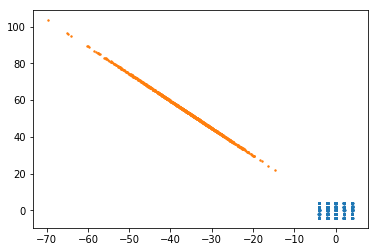

step 3000: discriminator: 1.301e+01, generator: 1.010e-04


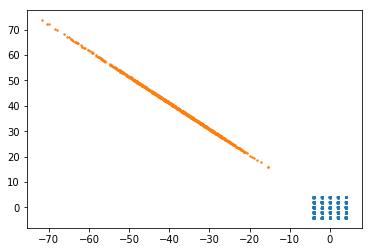

step 4000: discriminator: 1.656e+00, generator: 3.164e-01


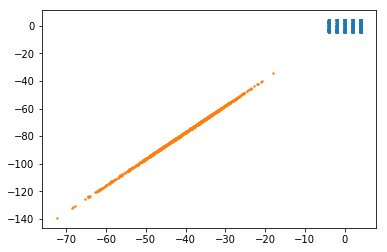

step 5000: discriminator: 2.331e+01, generator: 2.483e-08


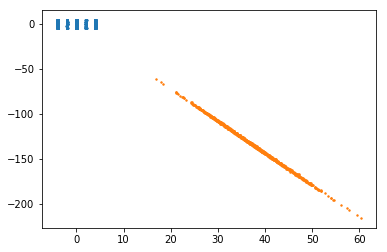

step 6000: discriminator: 2.827e+01, generator: 8.266e-10


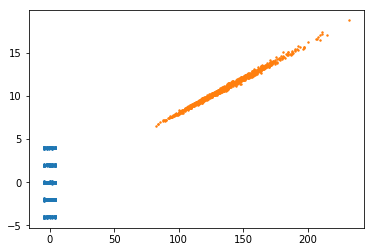

step 7000: discriminator: 4.370e-01, generator: 2.166e+00


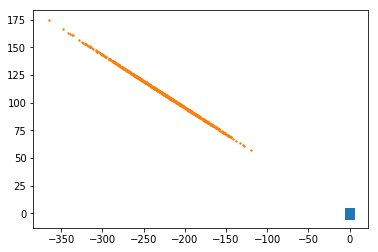

step 8000: discriminator: 2.672e+01, generator: 1.364e-08


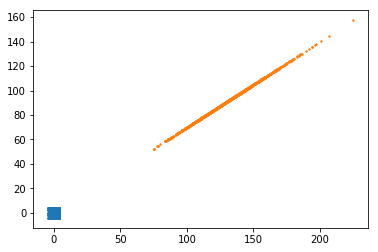

step 9000: discriminator: 2.716e+01, generator: 1.811e-09


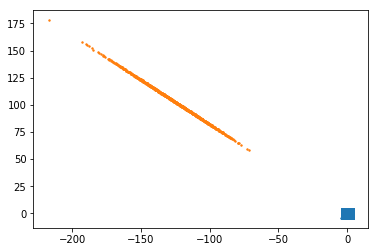

step 10000: discriminator: 2.984e+01, generator: 2.367e-10


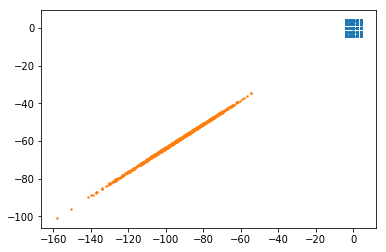

step 11000: discriminator: 1.582e+01, generator: 4.414e-06


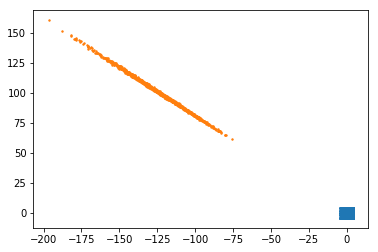

step 12000: discriminator: 4.423e+00, generator: 9.031e-02


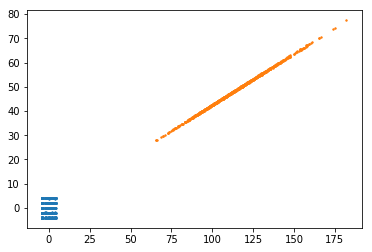

step 13000: discriminator: 2.058e+01, generator: 5.860e-07


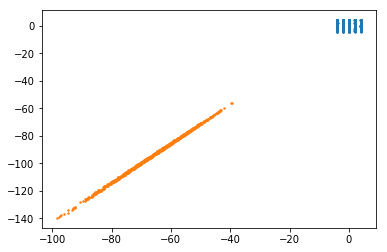

step 14000: discriminator: 3.458e+00, generator: 3.425e+00


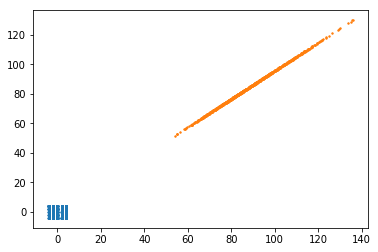

step 15000: discriminator: 3.181e+00, generator: 3.136e+00


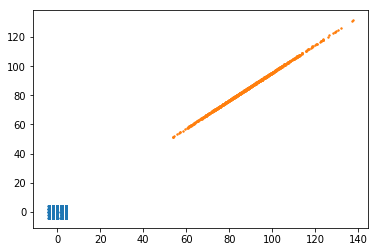

step 16000: discriminator: 2.911e+00, generator: 2.852e+00


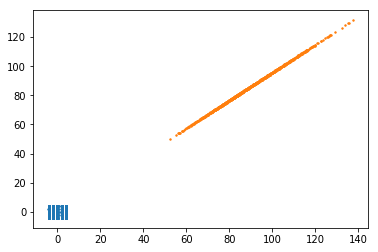

step 17000: discriminator: 2.651e+00, generator: 2.572e+00


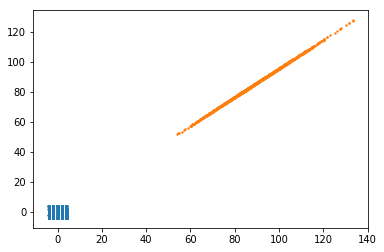

step 18000: discriminator: 2.404e+00, generator: 2.299e+00


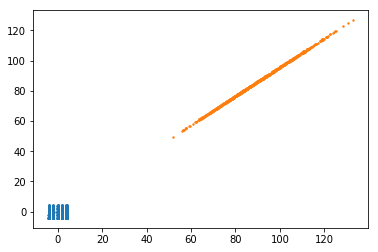

step 19000: discriminator: 2.174e+00, generator: 2.033e+00


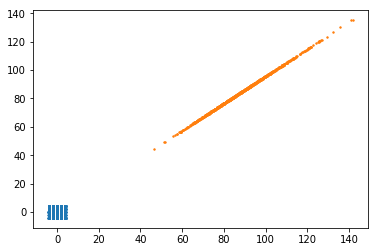

step 20000: discriminator: 1.963e+00, generator: 1.778e+00


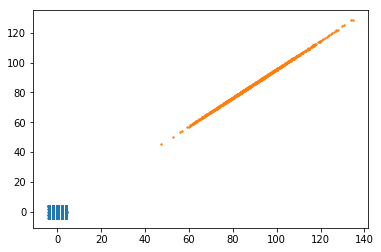

parameters: 10 7 512 64
step 0: discriminator: 1.380e+00, generator: 6.599e-01


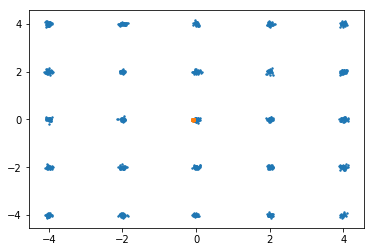

step 1000: discriminator: 1.574e+00, generator: 3.883e-01


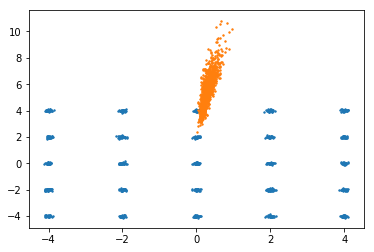

step 2000: discriminator: 1.385e+00, generator: 5.162e-01


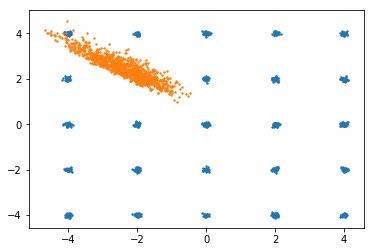

step 3000: discriminator: 1.157e+00, generator: 1.165e+00


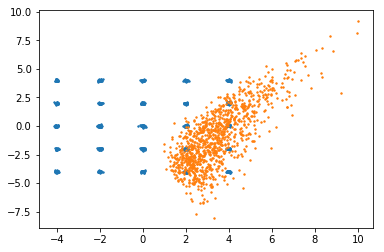

step 4000: discriminator: 7.762e-01, generator: 1.649e+00


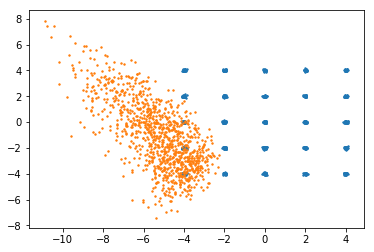

step 5000: discriminator: 3.050e+00, generator: 5.738e-01


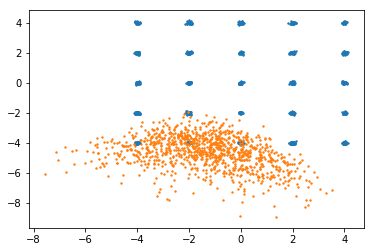

step 6000: discriminator: 9.017e-01, generator: 1.441e+00


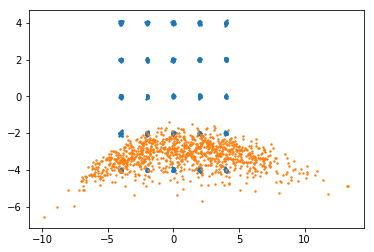

step 7000: discriminator: 1.129e+00, generator: 7.125e-01


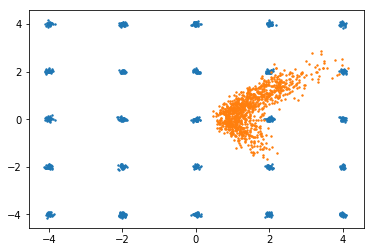

step 8000: discriminator: 2.890e+00, generator: 1.590e-01


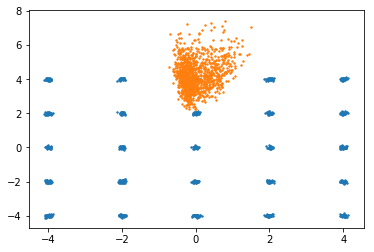

step 9000: discriminator: 9.722e-01, generator: 1.177e+00


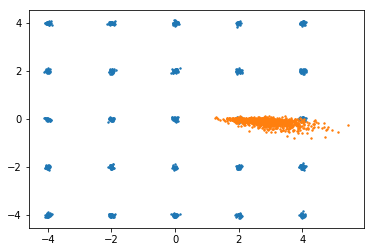

step 10000: discriminator: 2.433e+00, generator: 1.530e-01


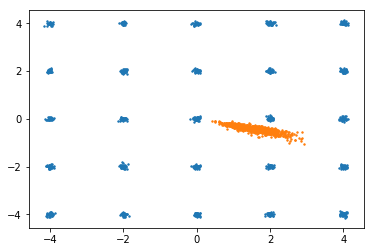

step 11000: discriminator: 1.164e+00, generator: 1.059e+00


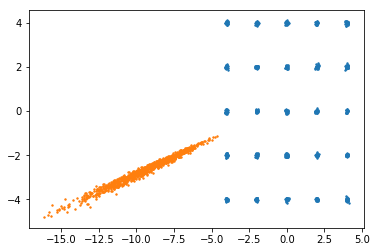

step 12000: discriminator: 1.254e+00, generator: 9.748e-01


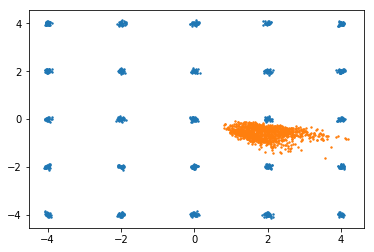

step 13000: discriminator: 7.278e-01, generator: 1.117e+00


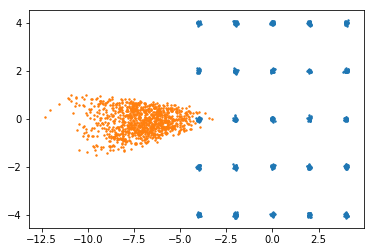

step 14000: discriminator: 1.184e+00, generator: 1.047e+00


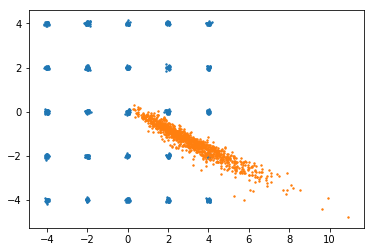

step 15000: discriminator: 9.456e-01, generator: 1.236e+00


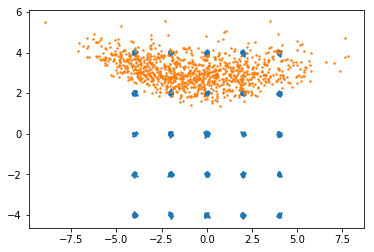

step 16000: discriminator: 1.134e+00, generator: 8.137e-01


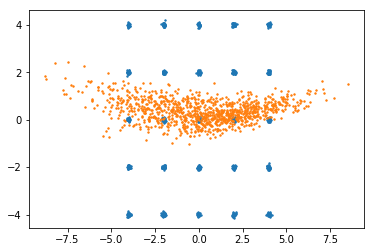

step 17000: discriminator: 1.292e+00, generator: 7.695e-01


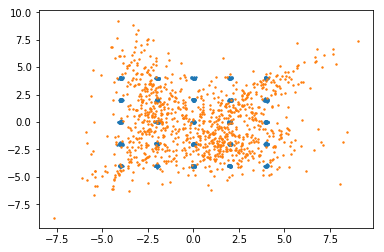

step 18000: discriminator: 1.183e+00, generator: 9.893e-01


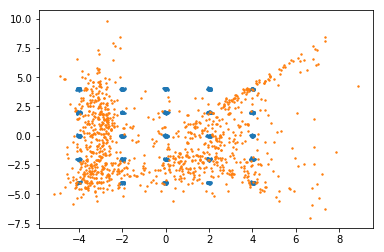

step 19000: discriminator: 1.017e+00, generator: 1.342e+00


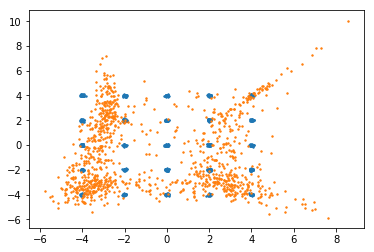

step 20000: discriminator: 8.725e-01, generator: 1.613e+00


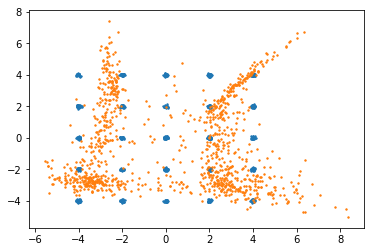

parameters: 10 7 512 32
step 0: discriminator: 1.438e+00, generator: 6.211e-01


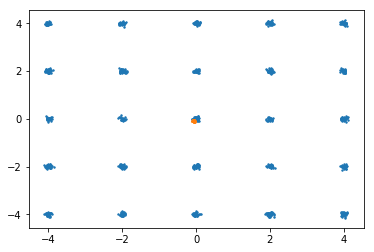

step 1000: discriminator: 1.170e+00, generator: 8.455e-01


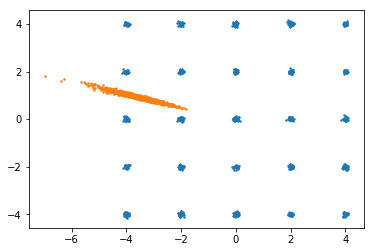

step 2000: discriminator: 1.860e+00, generator: 4.925e-01


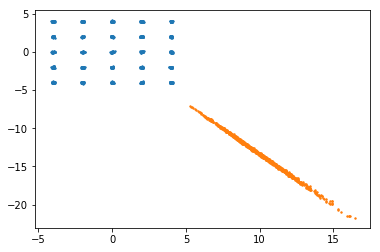

step 3000: discriminator: 1.386e+00, generator: 6.931e-01


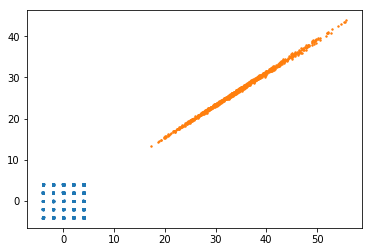

step 4000: discriminator: 1.386e+00, generator: 6.931e-01


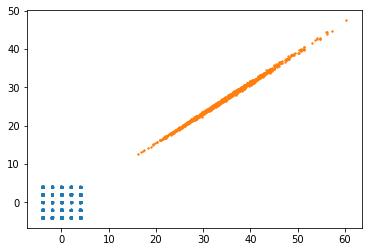

step 5000: discriminator: 1.386e+00, generator: 6.931e-01


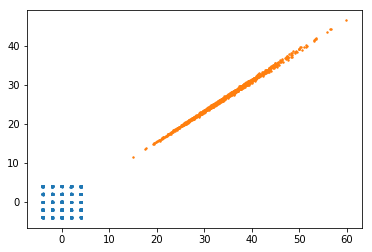

step 6000: discriminator: 1.386e+00, generator: 6.931e-01


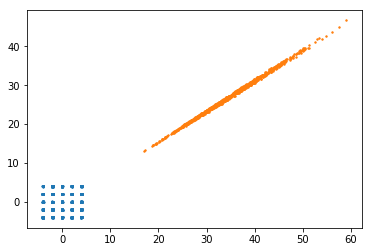

step 7000: discriminator: 1.386e+00, generator: 6.931e-01


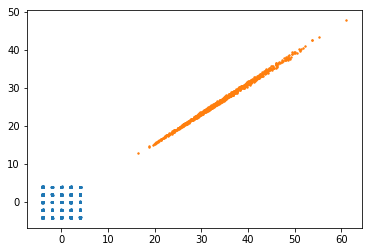

step 8000: discriminator: 1.386e+00, generator: 6.931e-01


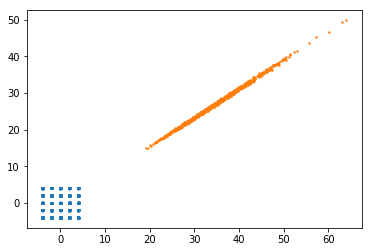

step 9000: discriminator: 1.386e+00, generator: 6.931e-01


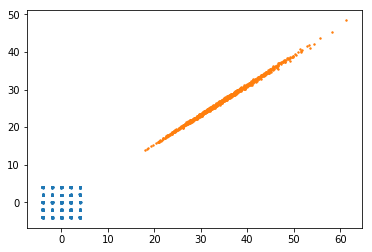

step 10000: discriminator: 1.386e+00, generator: 6.931e-01


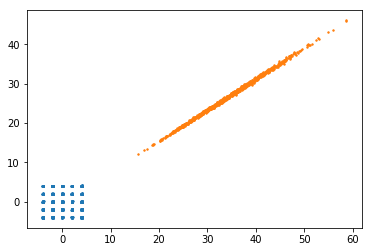

step 11000: discriminator: 1.386e+00, generator: 6.931e-01


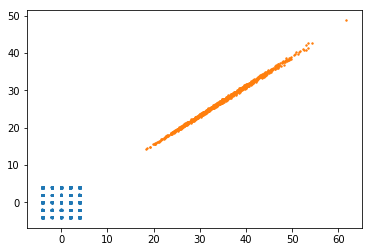

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


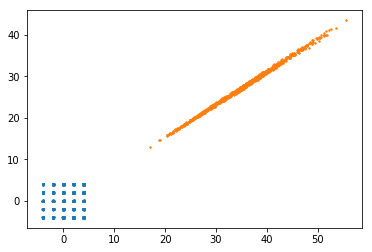

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


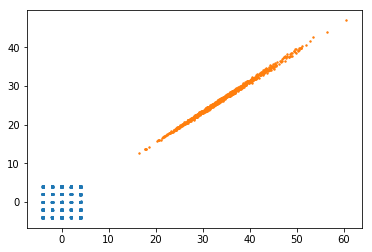

step 14000: discriminator: 1.386e+00, generator: 6.931e-01


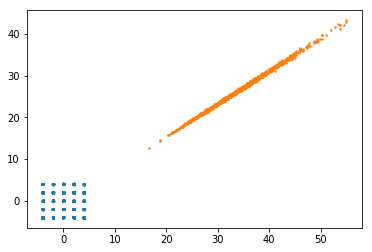

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


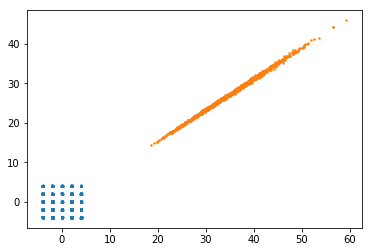

step 16000: discriminator: 1.386e+00, generator: 6.931e-01


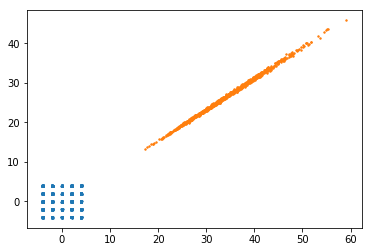

step 17000: discriminator: 1.386e+00, generator: 6.931e-01


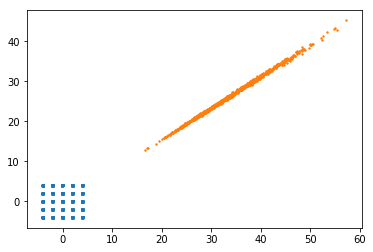

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


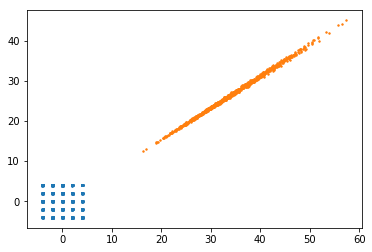

step 19000: discriminator: 1.386e+00, generator: 6.931e-01


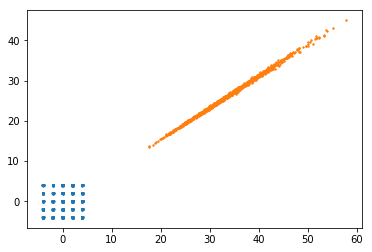

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


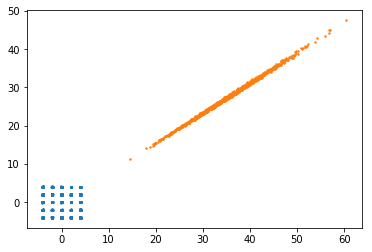

parameters: 10 7 256 64
step 0: discriminator: 1.385e+00, generator: 6.660e-01


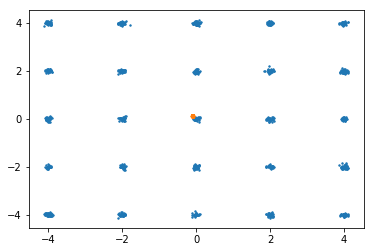

step 1000: discriminator: 9.524e-01, generator: 9.632e-01


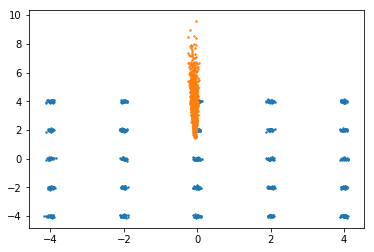

step 2000: discriminator: 8.829e-01, generator: 1.152e+00


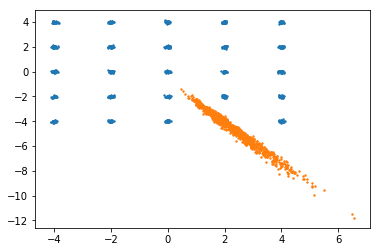

step 3000: discriminator: 1.323e+00, generator: 1.232e+00


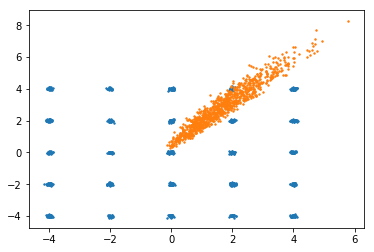

step 4000: discriminator: 2.407e+00, generator: 1.009e+00


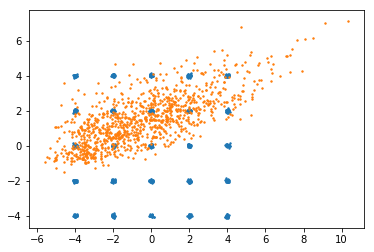

step 5000: discriminator: 1.181e+00, generator: 1.194e+00


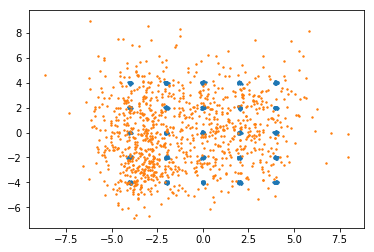

step 6000: discriminator: 1.075e+00, generator: 1.516e+00


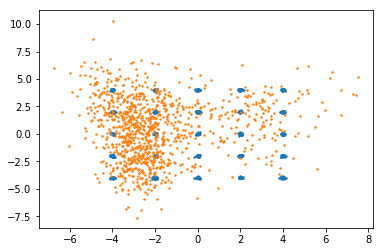

step 7000: discriminator: 1.062e+00, generator: 1.692e+00


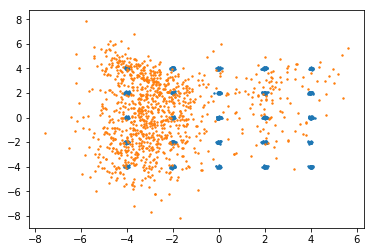

step 8000: discriminator: 9.732e-01, generator: 1.361e+00


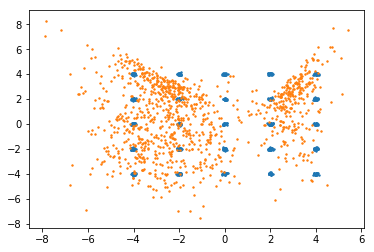

step 9000: discriminator: 9.022e-01, generator: 1.525e+00


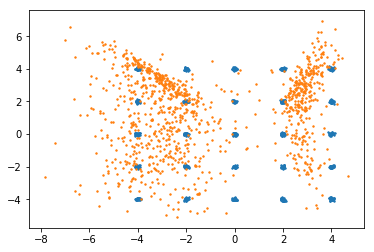

step 10000: discriminator: 8.533e-01, generator: 1.539e+00


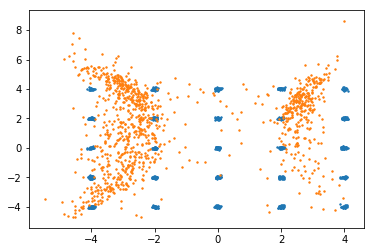

step 11000: discriminator: 9.095e-01, generator: 1.142e+00


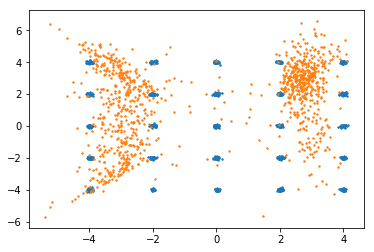

step 12000: discriminator: 7.253e-01, generator: 1.766e+00


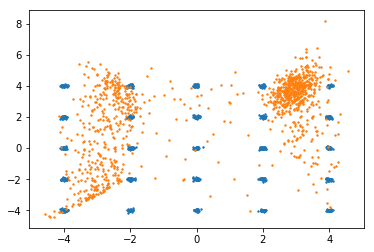

step 13000: discriminator: 6.539e-01, generator: 1.999e+00


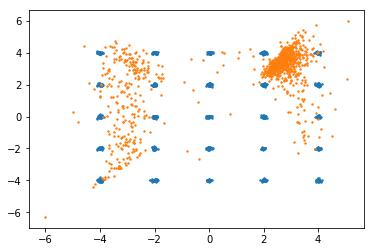

step 14000: discriminator: 6.063e-01, generator: 2.074e+00


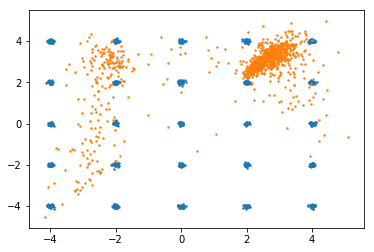

step 15000: discriminator: 5.880e-01, generator: 1.988e+00


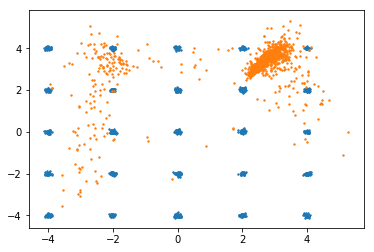

step 16000: discriminator: 5.358e-01, generator: 2.207e+00


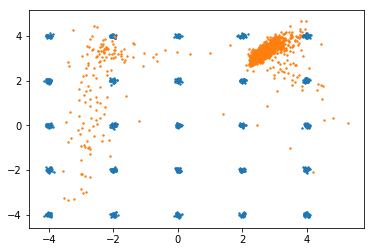

step 17000: discriminator: 4.427e-01, generator: 2.264e+00


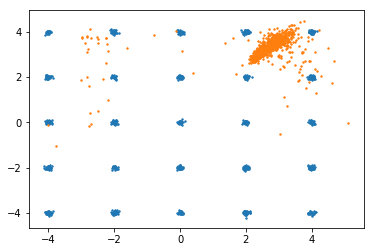

step 18000: discriminator: 4.384e-01, generator: 2.095e+00


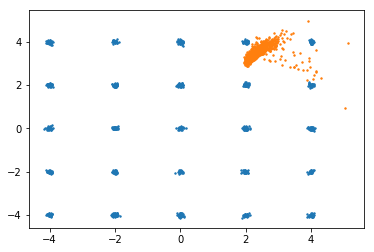

step 19000: discriminator: 3.221e-01, generator: 2.285e+00


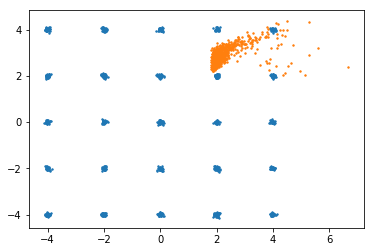

step 20000: discriminator: 1.547e+00, generator: 3.946e+00


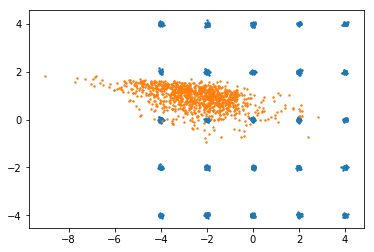

parameters: 10 7 256 32
step 0: discriminator: 1.337e+00, generator: 8.762e-01


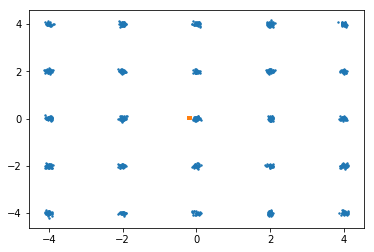

step 1000: discriminator: 1.840e+00, generator: 5.063e-01


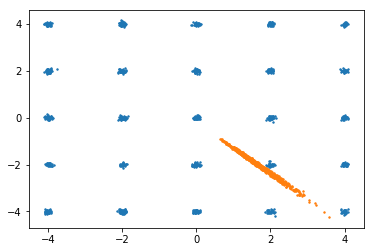

step 2000: discriminator: 1.404e+00, generator: 8.342e-01


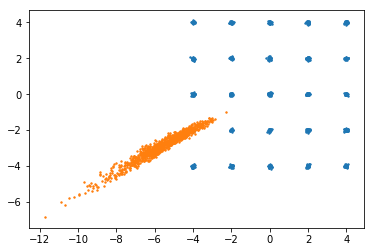

step 3000: discriminator: 1.386e+00, generator: 6.931e-01


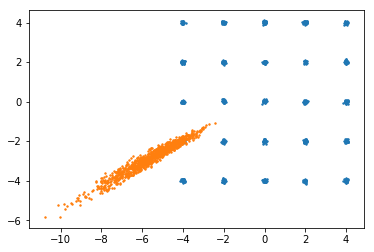

step 4000: discriminator: 1.386e+00, generator: 6.931e-01


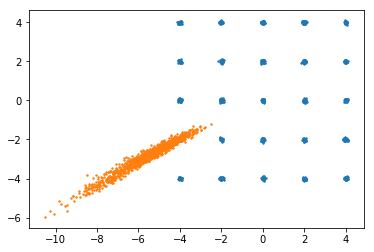

step 5000: discriminator: 1.386e+00, generator: 6.931e-01


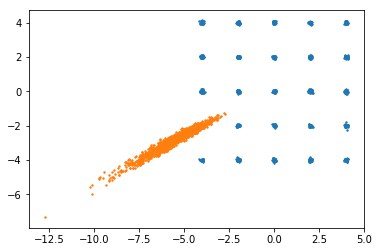

step 6000: discriminator: 1.386e+00, generator: 6.931e-01


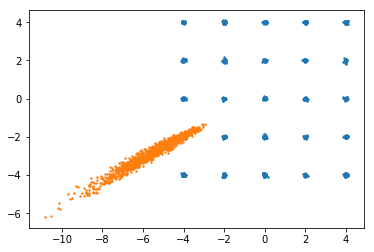

step 7000: discriminator: 1.386e+00, generator: 6.931e-01


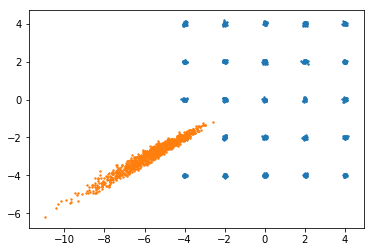

step 8000: discriminator: 1.386e+00, generator: 6.931e-01


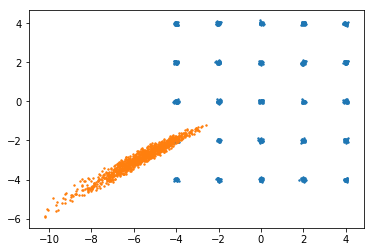

step 9000: discriminator: 1.386e+00, generator: 6.931e-01


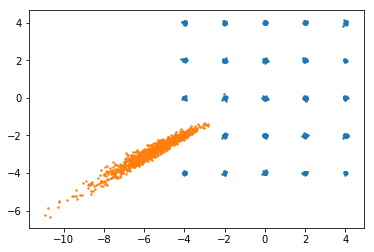

step 10000: discriminator: 1.386e+00, generator: 6.931e-01


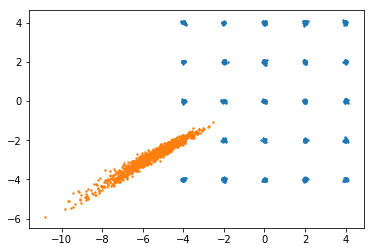

step 11000: discriminator: 1.386e+00, generator: 6.931e-01


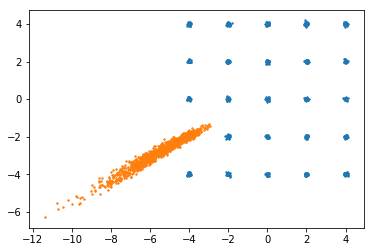

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


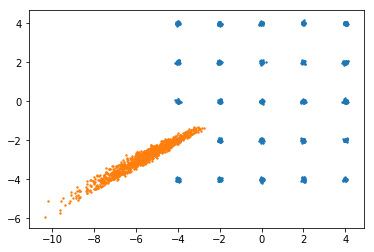

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


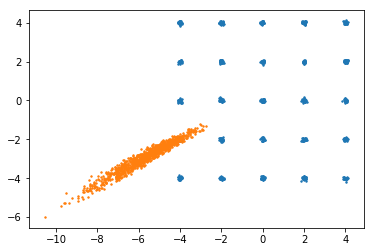

step 14000: discriminator: 1.386e+00, generator: 6.931e-01


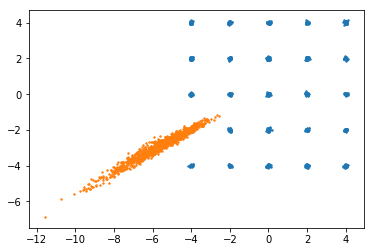

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


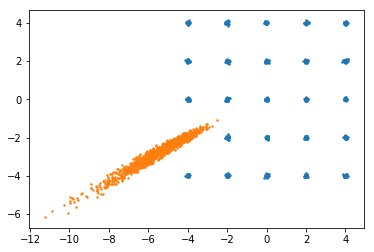

step 16000: discriminator: 1.386e+00, generator: 6.931e-01


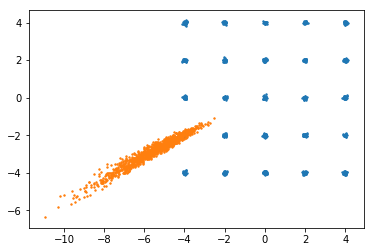

step 17000: discriminator: 1.386e+00, generator: 6.931e-01


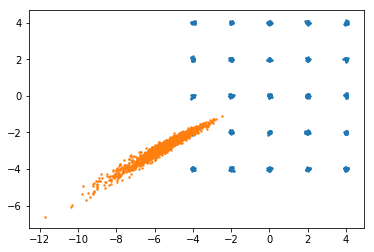

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


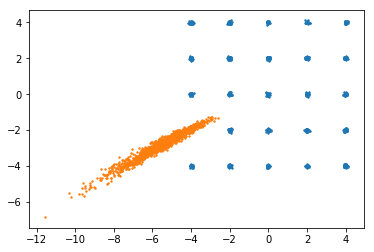

step 19000: discriminator: 1.386e+00, generator: 6.931e-01


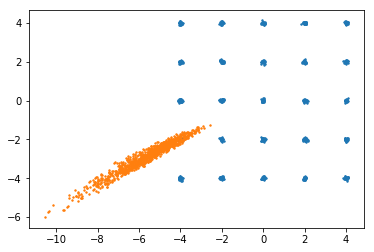

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


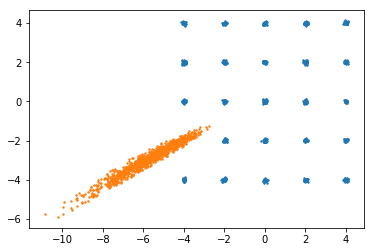

parameters: 10 20 512 64
step 0: discriminator: 1.351e+00, generator: 5.958e-01


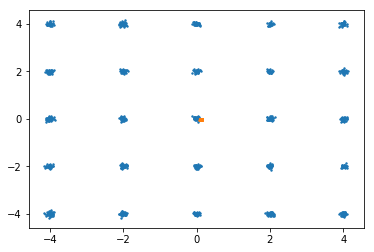

step 1000: discriminator: 8.103e-01, generator: 1.573e+00


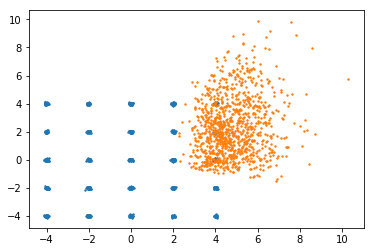

step 2000: discriminator: 7.967e-01, generator: 1.611e+00


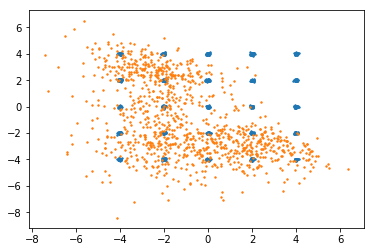

step 3000: discriminator: 4.475e-01, generator: 2.840e+00


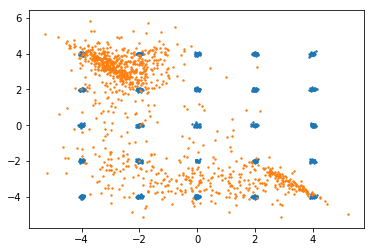

step 4000: discriminator: 3.702e-01, generator: 2.635e+00


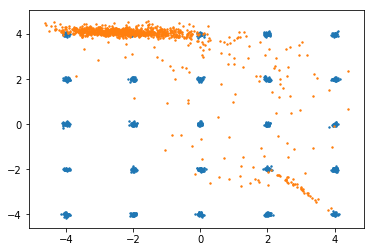

step 5000: discriminator: 2.548e-01, generator: 3.964e+00


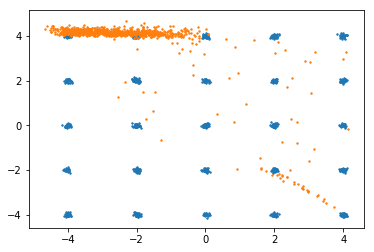

step 6000: discriminator: 1.773e-01, generator: 3.597e+00


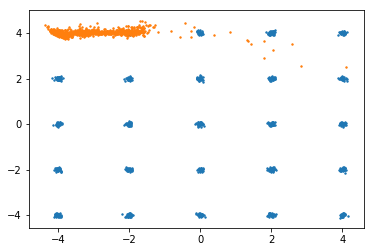

step 7000: discriminator: 1.958e-01, generator: 4.065e+00


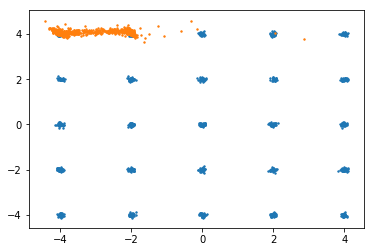

step 8000: discriminator: 1.928e-01, generator: 3.838e+00


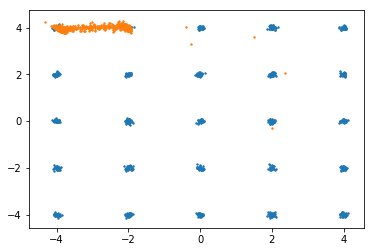

step 9000: discriminator: 2.596e-01, generator: 2.960e+00


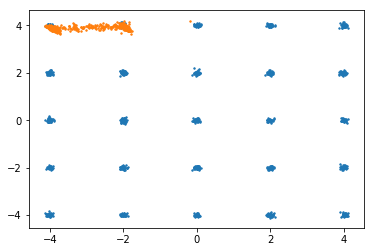

step 10000: discriminator: 2.028e-01, generator: 3.398e+00


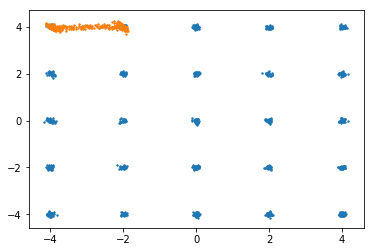

step 11000: discriminator: 2.086e-01, generator: 3.570e+00


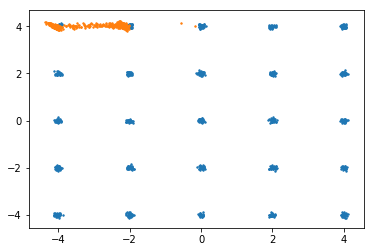

step 12000: discriminator: 2.760e-01, generator: 3.511e+00


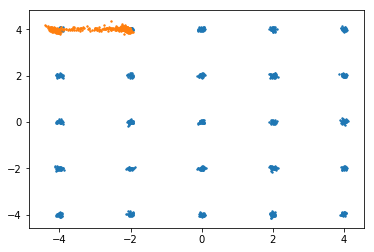

step 13000: discriminator: 2.906e-01, generator: 2.712e+00


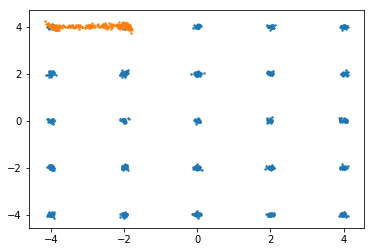

step 14000: discriminator: 2.515e-01, generator: 3.037e+00


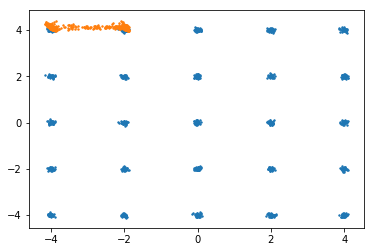

step 15000: discriminator: 2.409e-01, generator: 3.075e+00


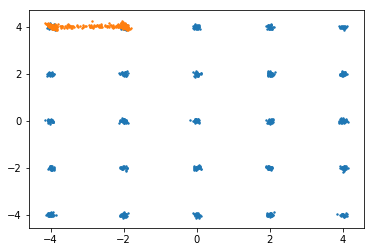

step 16000: discriminator: 2.176e-01, generator: 3.207e+00


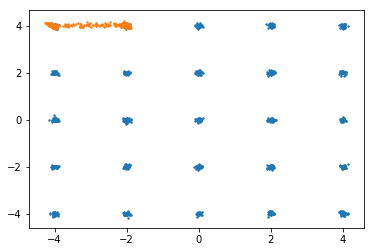

step 17000: discriminator: 2.468e-01, generator: 2.606e+00


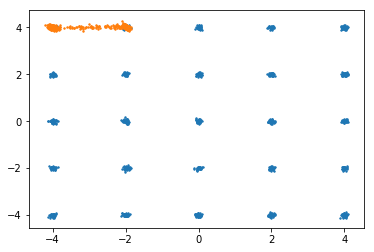

step 18000: discriminator: 2.564e-01, generator: 3.120e+00


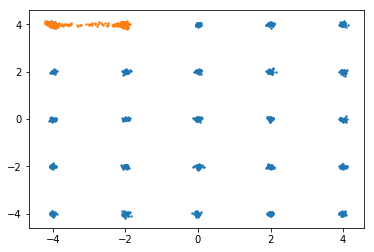

step 19000: discriminator: 2.418e-01, generator: 3.097e+00


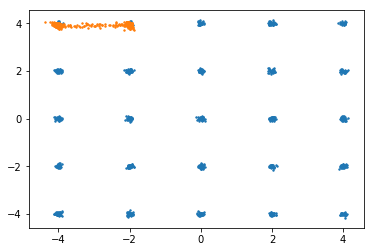

step 20000: discriminator: 1.367e-01, generator: 4.003e+00


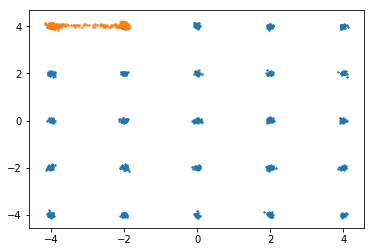

parameters: 10 20 512 32
step 0: discriminator: 1.371e+00, generator: 7.170e-01


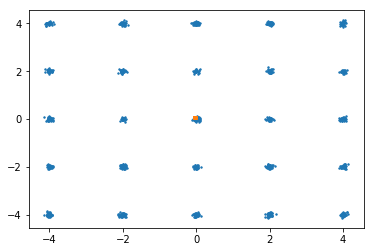

step 1000: discriminator: 1.334e+01, generator: 6.571e-05


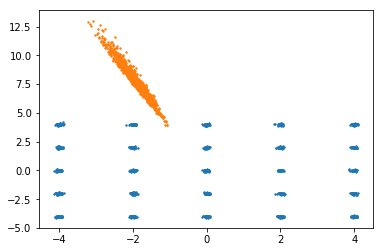

step 2000: discriminator: 1.107e+01, generator: 1.497e-02


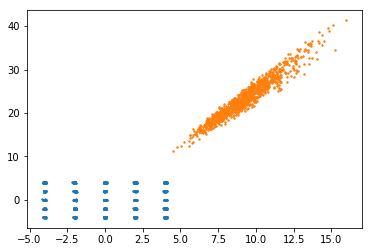

step 3000: discriminator: 3.505e+00, generator: 3.473e+00


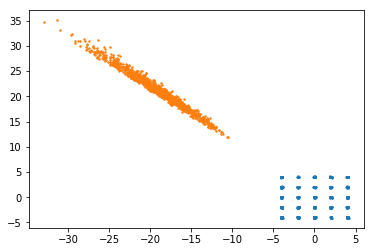

step 4000: discriminator: 1.867e+00, generator: 1.655e+00


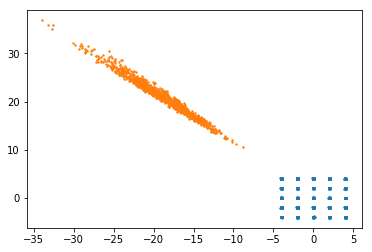

step 5000: discriminator: 1.386e+00, generator: 6.931e-01


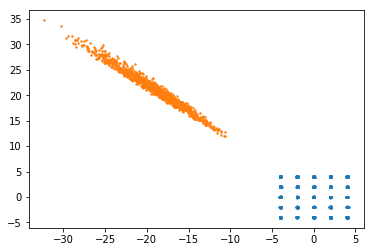

step 6000: discriminator: 1.386e+00, generator: 6.931e-01


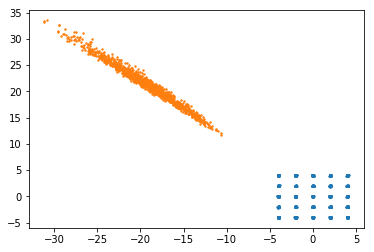

step 7000: discriminator: 1.386e+00, generator: 6.931e-01


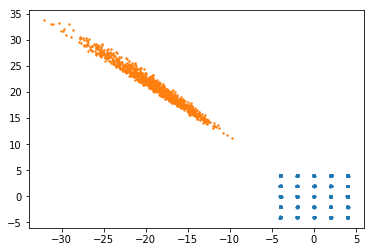

step 8000: discriminator: 1.386e+00, generator: 6.931e-01


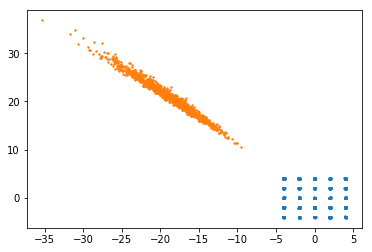

step 9000: discriminator: 1.386e+00, generator: 6.931e-01


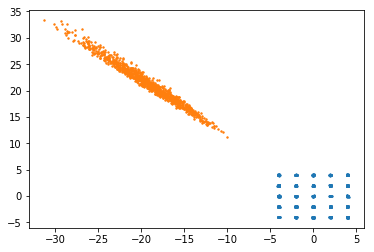

step 10000: discriminator: 1.386e+00, generator: 6.931e-01


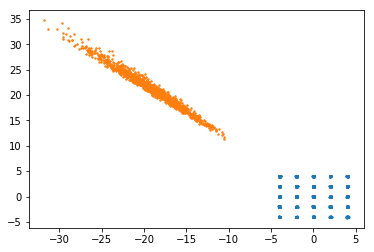

step 11000: discriminator: 1.386e+00, generator: 6.931e-01


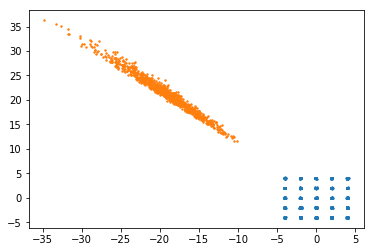

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


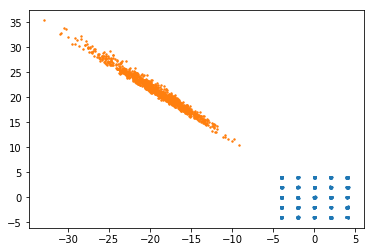

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


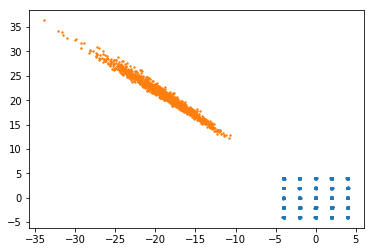

step 14000: discriminator: 1.386e+00, generator: 6.931e-01


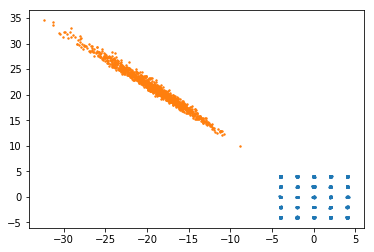

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


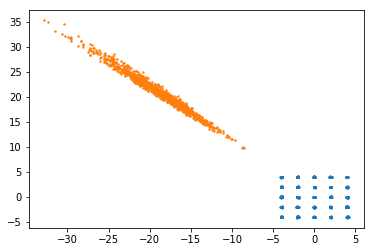

step 16000: discriminator: 1.386e+00, generator: 6.931e-01


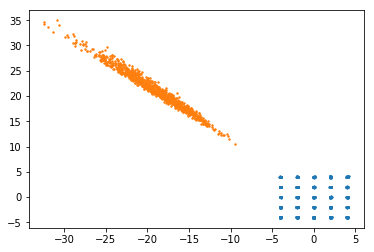

step 17000: discriminator: 1.386e+00, generator: 6.931e-01


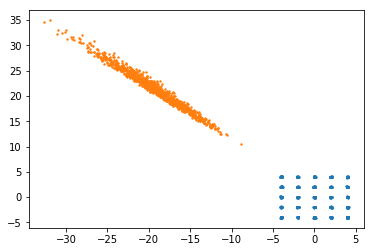

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


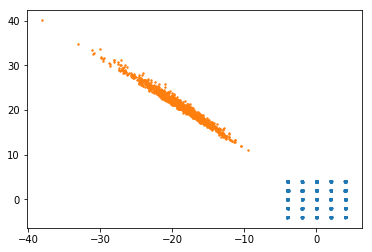

step 19000: discriminator: 1.386e+00, generator: 6.931e-01


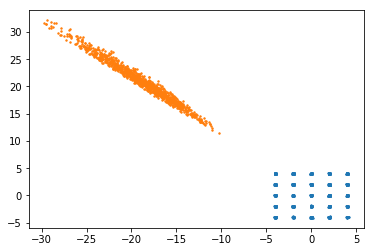

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


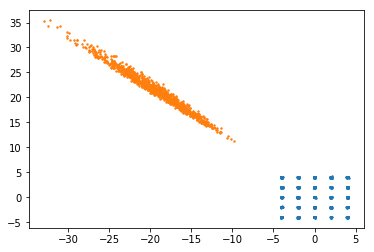

parameters: 10 20 256 64
step 0: discriminator: 1.374e+00, generator: 5.950e-01


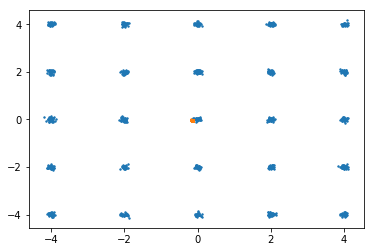

step 1000: discriminator: 1.662e-01, generator: 3.307e+00


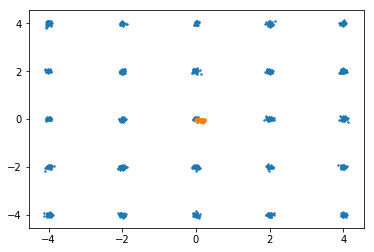

step 2000: discriminator: 1.905e-01, generator: 3.250e+00


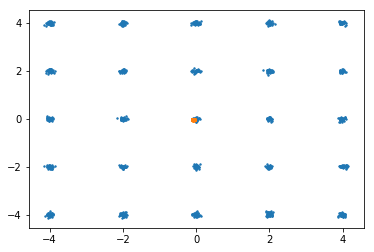

step 3000: discriminator: 2.630e-01, generator: 3.353e+00


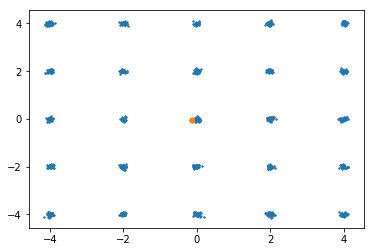

step 4000: discriminator: 1.467e-01, generator: 3.242e+00


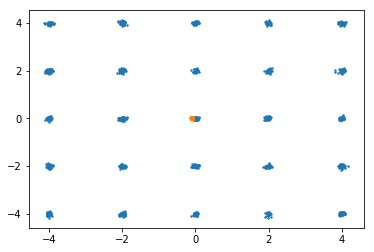

step 5000: discriminator: 2.291e-01, generator: 3.238e+00


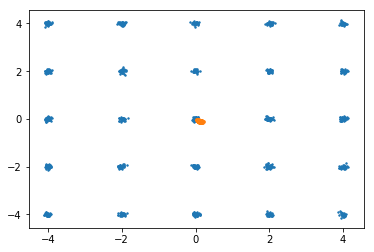

step 6000: discriminator: 1.538e-01, generator: 3.411e+00


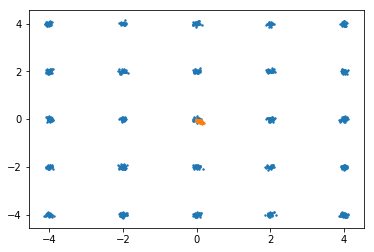

step 7000: discriminator: 1.484e-01, generator: 3.116e+00


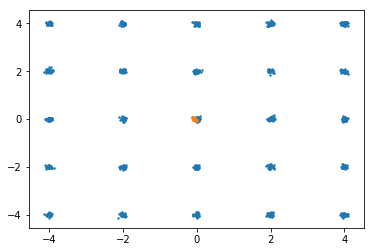

step 8000: discriminator: 1.869e-01, generator: 3.320e+00


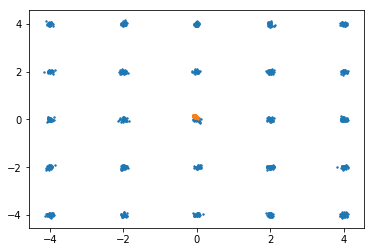

step 9000: discriminator: 1.374e-01, generator: 3.261e+00


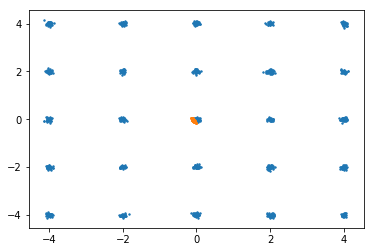

step 10000: discriminator: 1.166e-01, generator: 3.309e+00


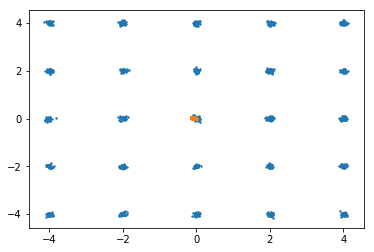

step 11000: discriminator: 1.509e-01, generator: 3.337e+00


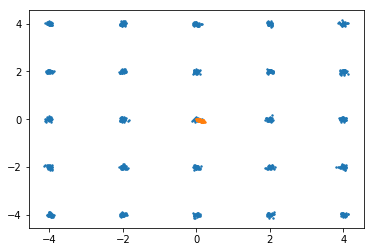

step 12000: discriminator: 1.797e-01, generator: 3.372e+00


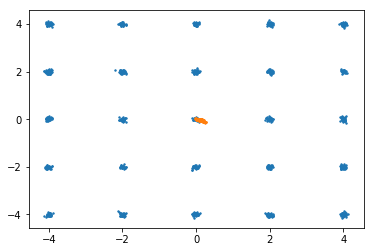

step 13000: discriminator: 1.150e-01, generator: 3.309e+00


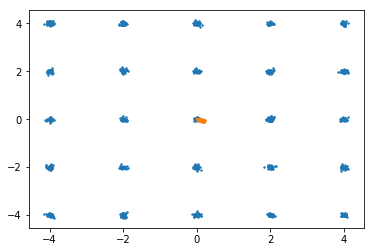

step 14000: discriminator: 1.620e-01, generator: 3.330e+00


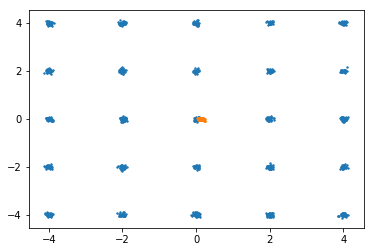

step 15000: discriminator: 1.693e-01, generator: 3.298e+00


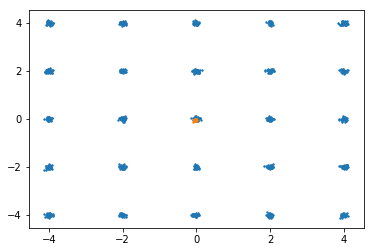

step 16000: discriminator: 9.414e-02, generator: 3.237e+00


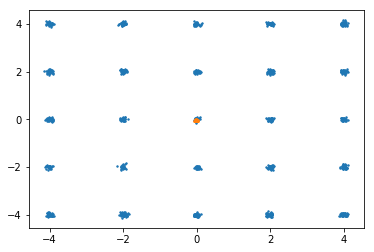

step 17000: discriminator: 2.289e-01, generator: 3.358e+00


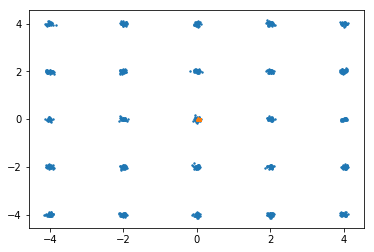

step 18000: discriminator: 2.166e-01, generator: 3.305e+00


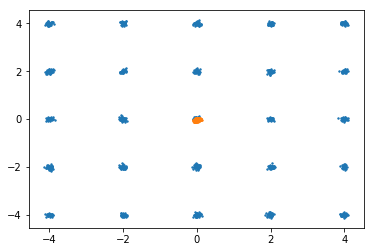

step 19000: discriminator: 1.287e-01, generator: 3.302e+00


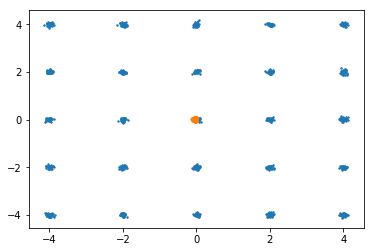

step 20000: discriminator: 1.640e-01, generator: 3.225e+00


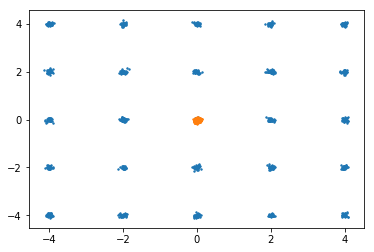

parameters: 10 20 256 32
step 0: discriminator: 1.412e+00, generator: 8.492e-01


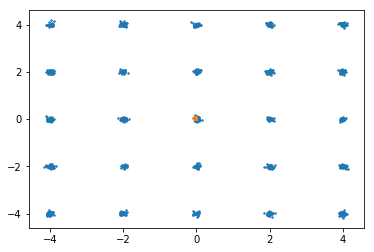

step 1000: discriminator: 1.924e-01, generator: 3.261e+00


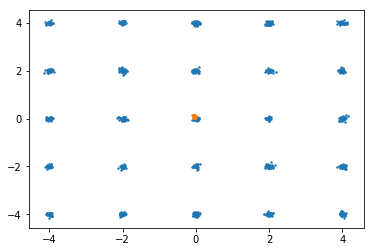

step 2000: discriminator: 1.800e-01, generator: 3.264e+00


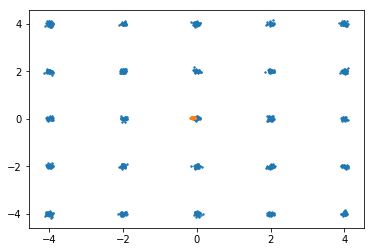

step 3000: discriminator: 1.925e-01, generator: 3.241e+00


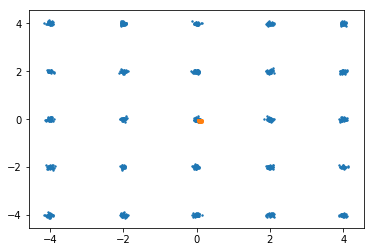

step 4000: discriminator: 1.833e-01, generator: 3.273e+00


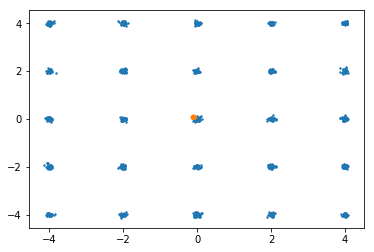

step 5000: discriminator: 2.148e-01, generator: 3.290e+00


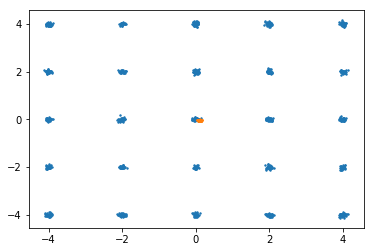

step 6000: discriminator: 1.935e-01, generator: 3.213e+00


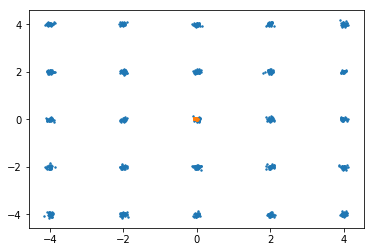

step 7000: discriminator: 1.548e-01, generator: 3.197e+00


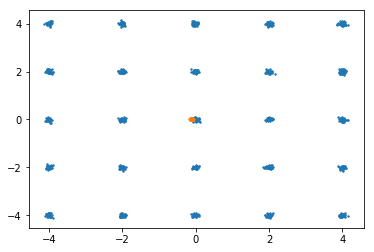

step 8000: discriminator: 2.038e-01, generator: 3.209e+00


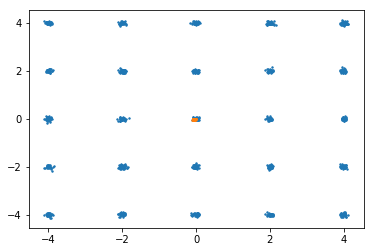

step 9000: discriminator: 2.021e-01, generator: 3.240e+00


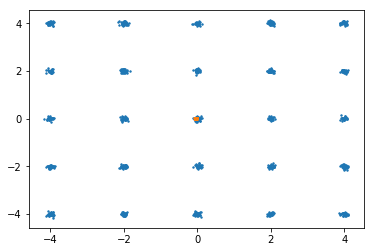

step 10000: discriminator: 1.679e-01, generator: 3.219e+00


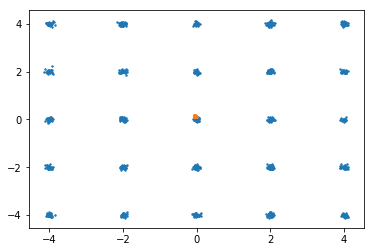

step 11000: discriminator: 3.555e+00, generator: 1.946e+00


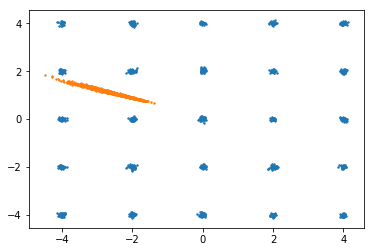

step 12000: discriminator: 1.909e+00, generator: 5.339e-01


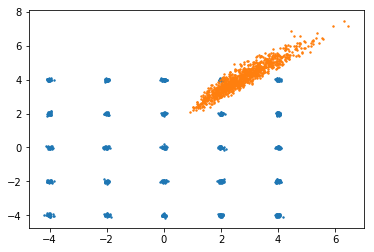

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


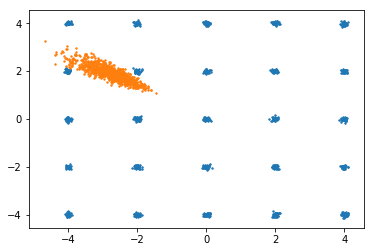

step 14000: discriminator: 1.386e+00, generator: 6.931e-01


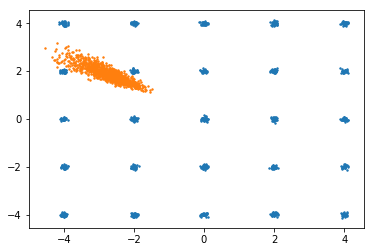

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


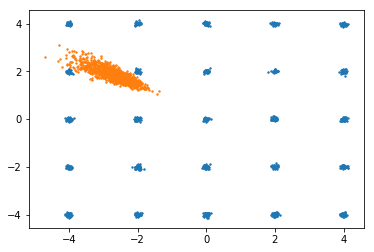

step 16000: discriminator: 1.386e+00, generator: 6.931e-01


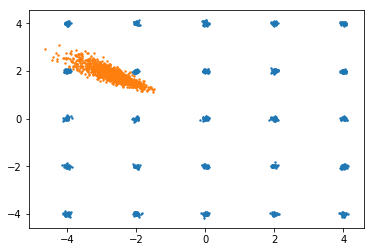

step 17000: discriminator: 1.386e+00, generator: 6.931e-01


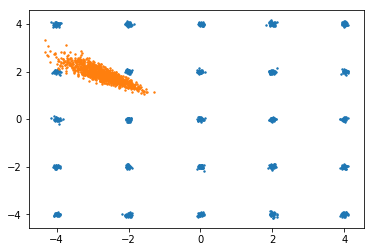

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


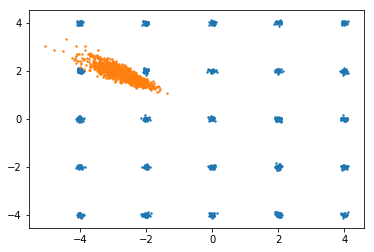

step 19000: discriminator: 1.386e+00, generator: 6.931e-01


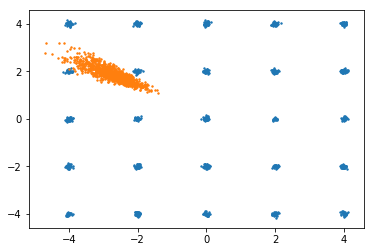

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


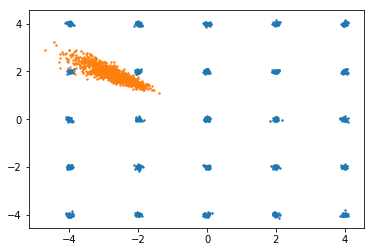

parameters: 50 3 512 64
step 0: discriminator: 1.403e+00, generator: 6.340e-01


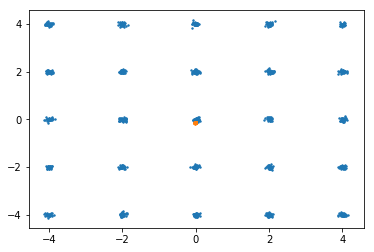

step 1000: discriminator: 1.501e+00, generator: 5.397e-01


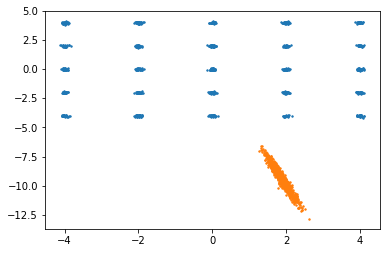

step 2000: discriminator: 1.195e+00, generator: 9.875e-01


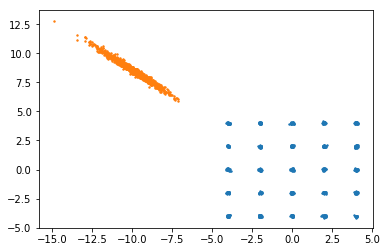

step 3000: discriminator: 1.474e+00, generator: 5.906e-01


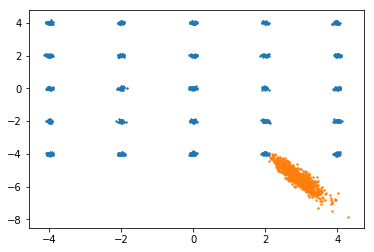

step 4000: discriminator: 2.334e+00, generator: 2.118e-01


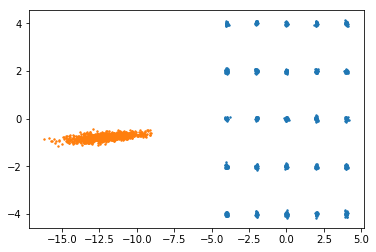

step 5000: discriminator: 1.408e+00, generator: 7.603e-01


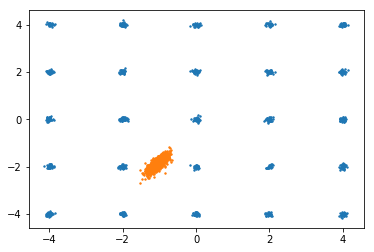

step 6000: discriminator: 1.145e+00, generator: 6.214e-01


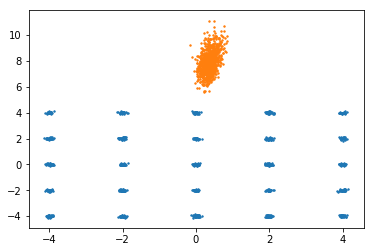

step 7000: discriminator: 1.396e+00, generator: 7.882e-01


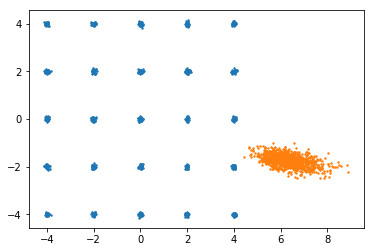

step 8000: discriminator: 1.245e+00, generator: 6.818e-01


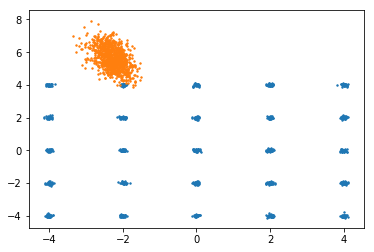

step 9000: discriminator: 1.393e+00, generator: 8.038e-01


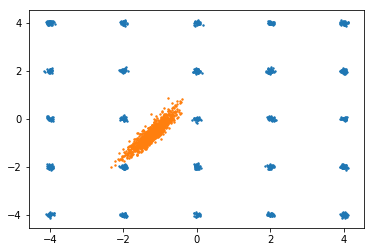

step 10000: discriminator: 1.371e+00, generator: 6.013e-01


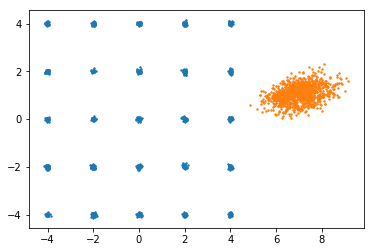

step 11000: discriminator: 1.562e+00, generator: 9.905e-01


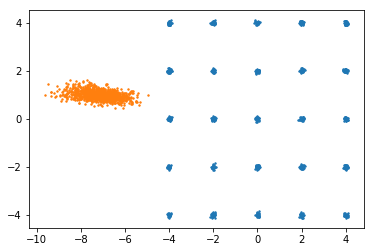

step 12000: discriminator: 1.160e+00, generator: 6.901e-01


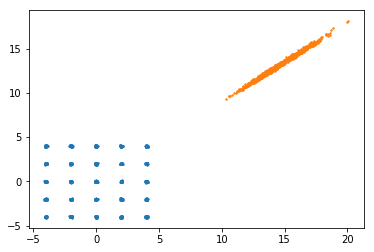

step 13000: discriminator: 1.471e+00, generator: 9.045e-01


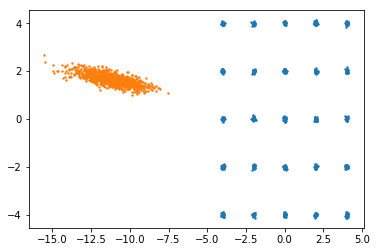

step 14000: discriminator: 1.386e+00, generator: 8.428e-01


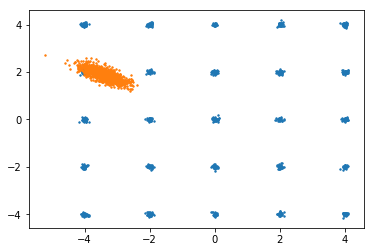

step 15000: discriminator: 1.253e+00, generator: 8.512e-01


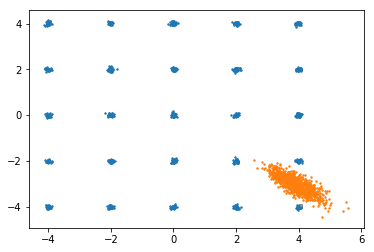

step 16000: discriminator: 8.080e-01, generator: 1.029e+00


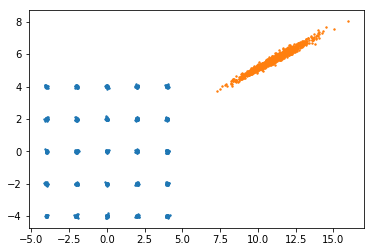

step 17000: discriminator: 2.705e+00, generator: 1.023e-01


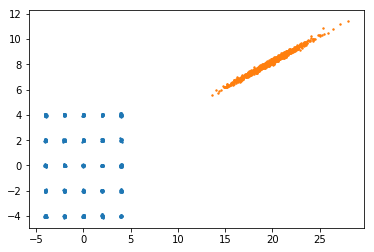

step 18000: discriminator: 1.290e+00, generator: 8.799e-01


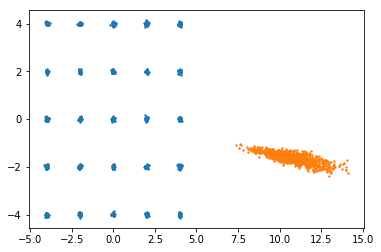

step 19000: discriminator: 1.364e+00, generator: 7.733e-01


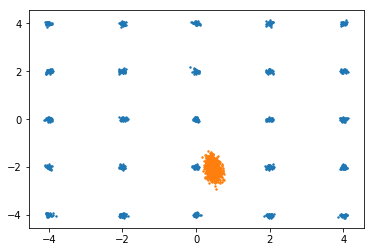

step 20000: discriminator: 1.393e+00, generator: 7.551e-01


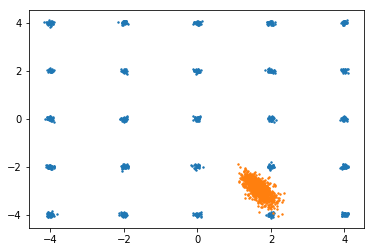

parameters: 50 3 512 32
step 0: discriminator: 1.447e+00, generator: 5.473e-01


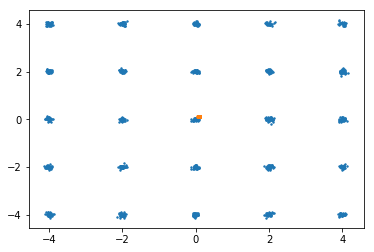

step 1000: discriminator: 1.927e+00, generator: 2.802e-01


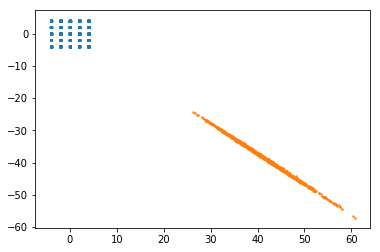

step 2000: discriminator: 1.144e+01, generator: 3.977e-05


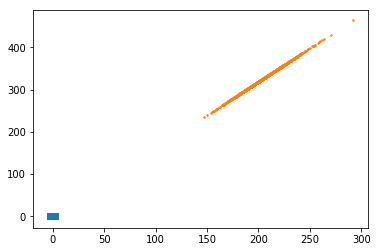

step 3000: discriminator: 5.637e+00, generator: 1.031e-02


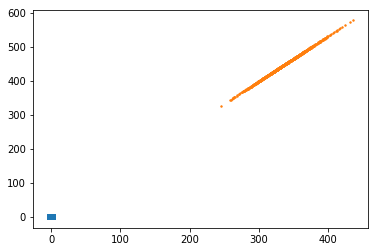

step 4000: discriminator: 1.032e+00, generator: 1.626e+00


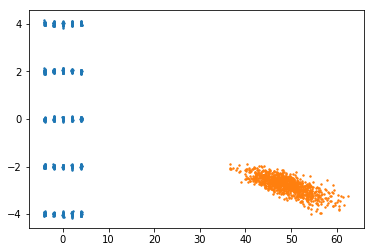

step 5000: discriminator: 1.358e+00, generator: 7.507e-01


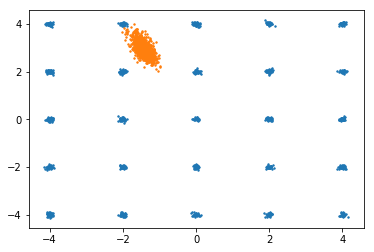

step 6000: discriminator: 1.347e+00, generator: 8.340e-01


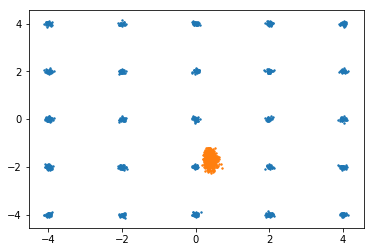

step 7000: discriminator: 1.378e+00, generator: 7.289e-01


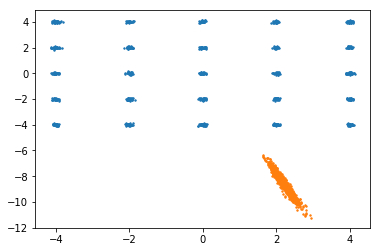

step 8000: discriminator: 2.571e+00, generator: 1.730e-01


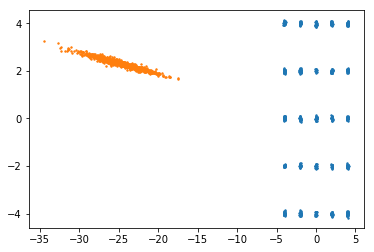

step 9000: discriminator: 1.401e+00, generator: 6.947e-01


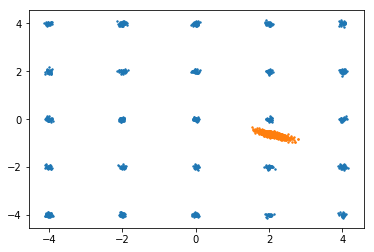

step 10000: discriminator: 1.402e+00, generator: 6.063e-01


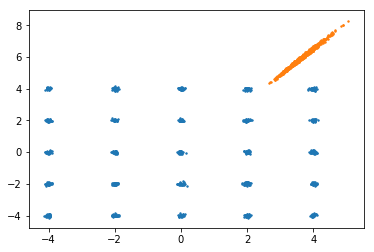

step 11000: discriminator: 1.408e+00, generator: 7.299e-01


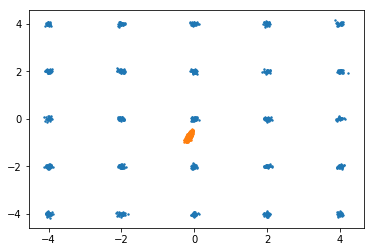

step 12000: discriminator: 1.388e+00, generator: 7.316e-01


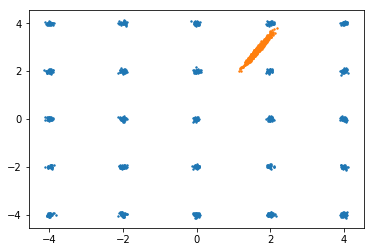

step 13000: discriminator: 1.376e+00, generator: 8.969e-01


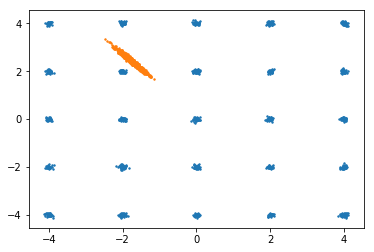

step 14000: discriminator: 3.131e+00, generator: 7.397e-02


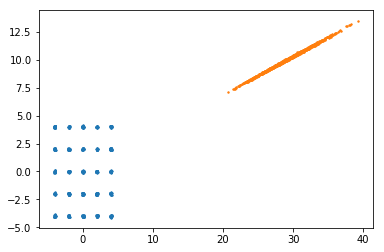

step 15000: discriminator: 1.428e+00, generator: 6.854e-01


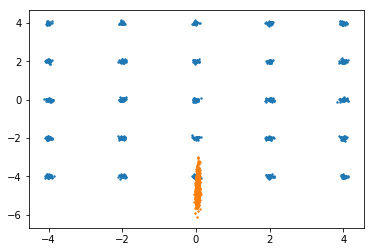

step 16000: discriminator: 1.525e+00, generator: 7.638e-01


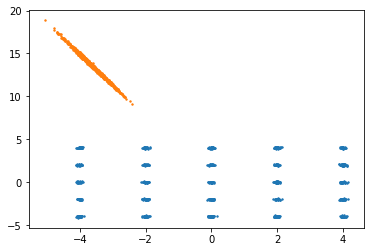

step 17000: discriminator: 1.425e+00, generator: 7.289e-01


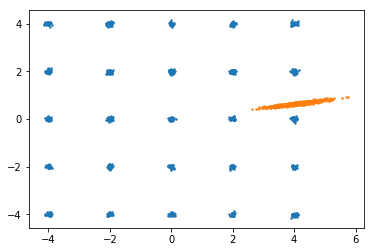

step 18000: discriminator: 1.102e+00, generator: 8.515e-01


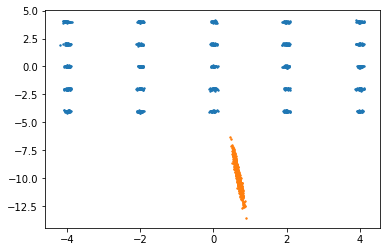

step 19000: discriminator: 1.252e+00, generator: 6.404e-01


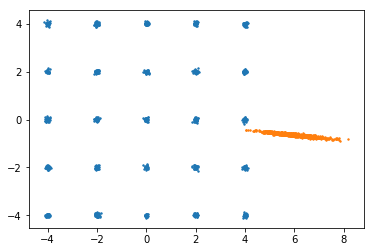

step 20000: discriminator: 1.274e+00, generator: 7.582e-01


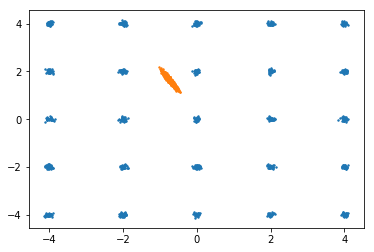

parameters: 50 3 256 64
step 0: discriminator: 1.398e+00, generator: 7.653e-01


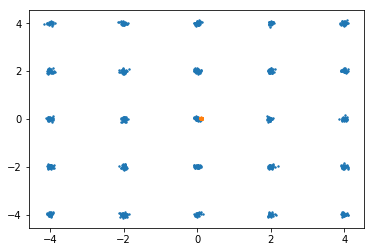

step 1000: discriminator: 1.529e+00, generator: 9.978e-01


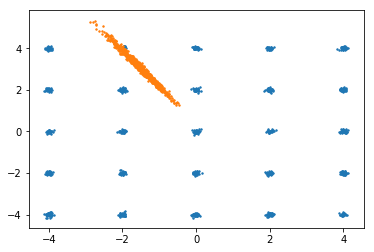

step 2000: discriminator: 1.871e+00, generator: 3.218e-01


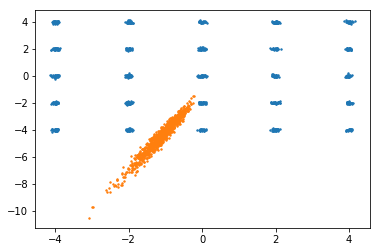

step 3000: discriminator: 1.126e+00, generator: 8.621e-01


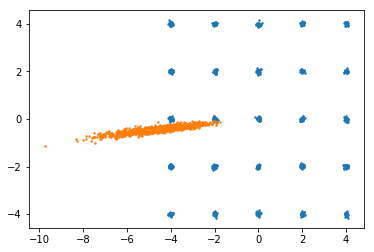

step 4000: discriminator: 9.198e-01, generator: 1.211e+00


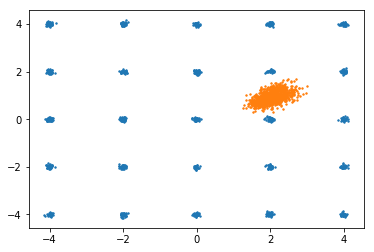

step 5000: discriminator: 1.612e+00, generator: 1.393e+00


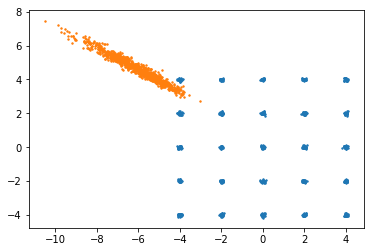

step 6000: discriminator: 2.326e+00, generator: 1.499e-01


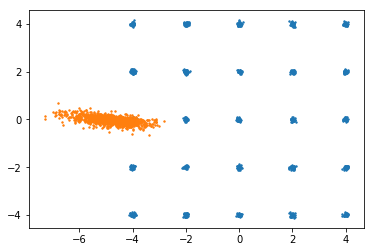

step 7000: discriminator: 1.118e+00, generator: 1.004e+00


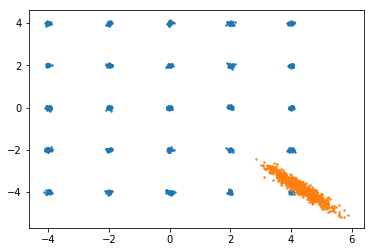

step 8000: discriminator: 1.673e+00, generator: 6.984e-01


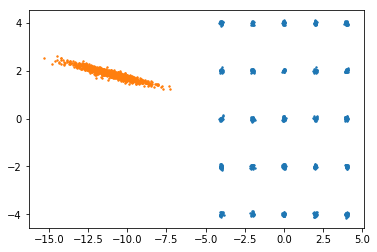

step 9000: discriminator: 1.104e+00, generator: 1.131e+00


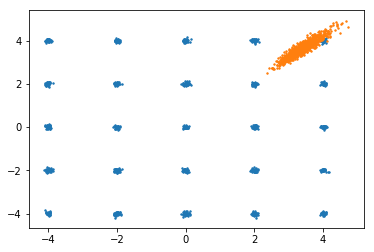

step 10000: discriminator: 8.459e-01, generator: 1.018e+00


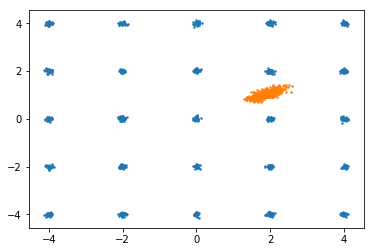

step 11000: discriminator: 1.201e+00, generator: 9.994e-01


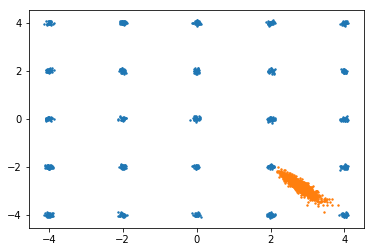

step 12000: discriminator: 1.222e+00, generator: 9.751e-01


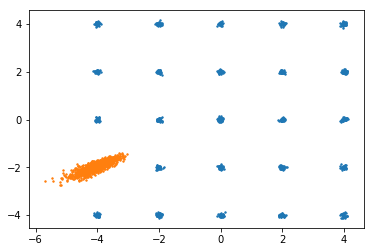

step 13000: discriminator: 2.317e+00, generator: 2.262e-01


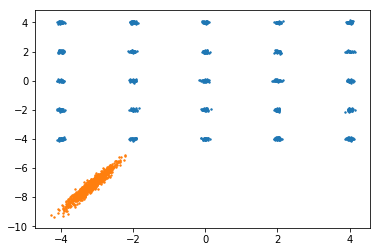

step 14000: discriminator: 3.091e+00, generator: 2.485e-01


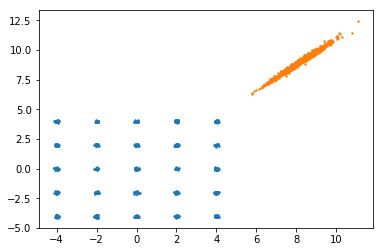

step 15000: discriminator: 1.247e+00, generator: 9.303e-01


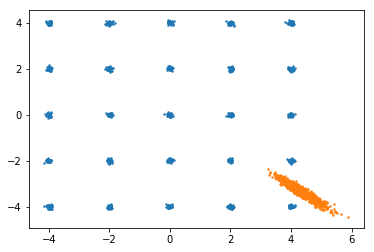

step 16000: discriminator: 1.280e+00, generator: 9.440e-01


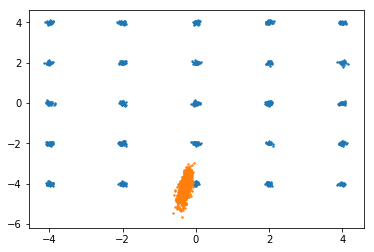

step 17000: discriminator: 1.642e+00, generator: 4.817e-01


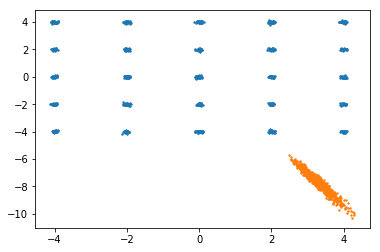

step 18000: discriminator: 1.258e+00, generator: 7.566e-01


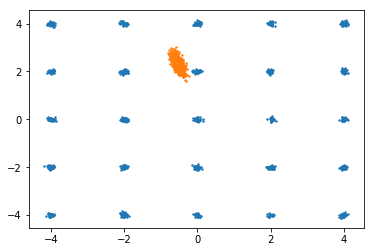

step 19000: discriminator: 1.447e+00, generator: 7.506e-01


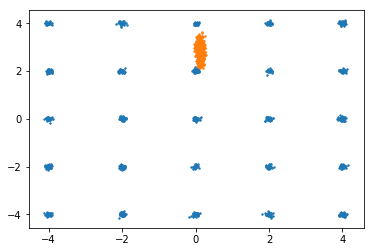

step 20000: discriminator: 1.234e+00, generator: 7.511e-01


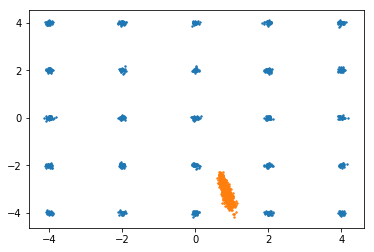

parameters: 50 3 256 32
step 0: discriminator: 1.387e+00, generator: 8.319e-01


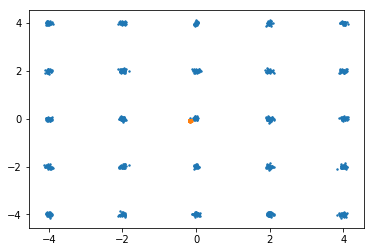

step 1000: discriminator: 1.192e+00, generator: 7.856e-01


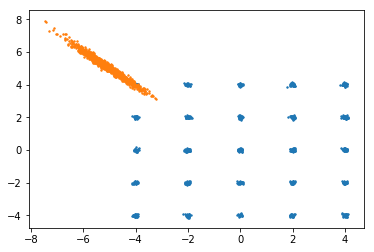

step 2000: discriminator: 1.218e+00, generator: 1.122e+00


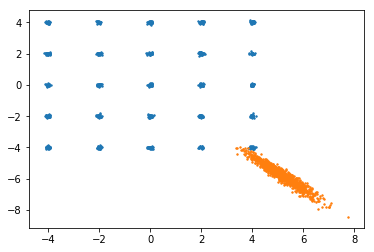

step 3000: discriminator: 1.342e+00, generator: 7.180e-01


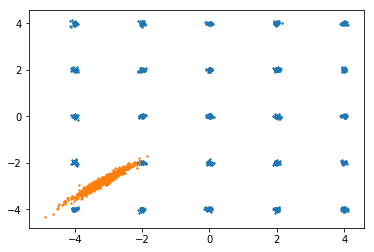

step 4000: discriminator: 1.441e+00, generator: 6.561e-01


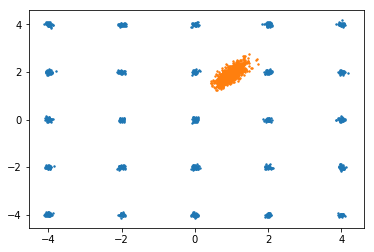

step 5000: discriminator: 1.398e+00, generator: 6.964e-01


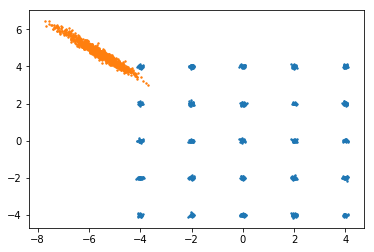

step 6000: discriminator: 1.401e+00, generator: 6.728e-01


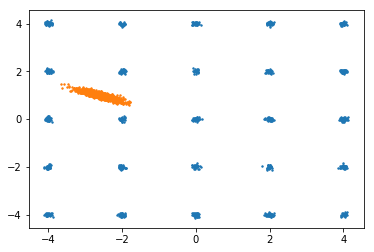

step 7000: discriminator: 1.380e+00, generator: 6.294e-01


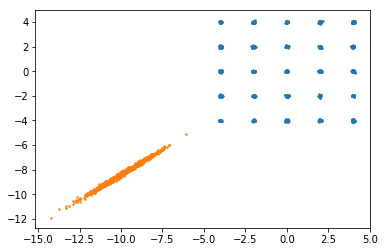

step 8000: discriminator: 1.386e+00, generator: 6.913e-01


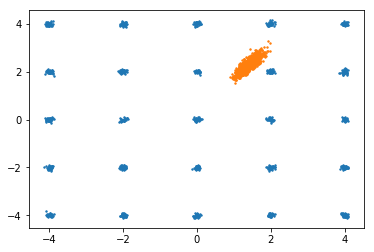

step 9000: discriminator: 1.386e+00, generator: 6.919e-01


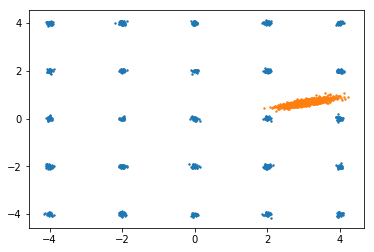

step 10000: discriminator: 1.386e+00, generator: 6.965e-01


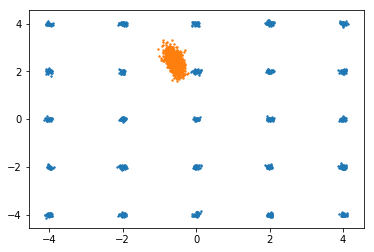

step 11000: discriminator: 1.385e+00, generator: 6.970e-01


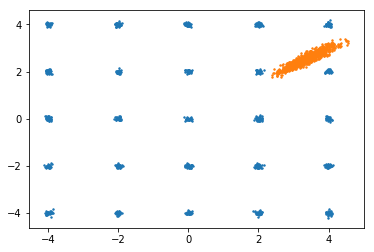

step 12000: discriminator: 1.386e+00, generator: 6.966e-01


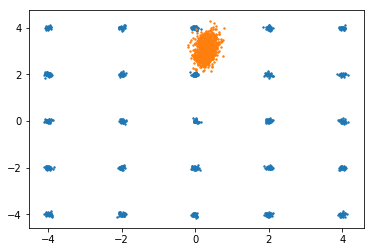

step 13000: discriminator: 1.385e+00, generator: 6.926e-01


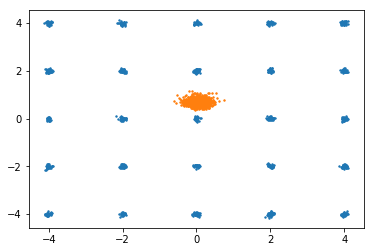

step 14000: discriminator: 1.384e+00, generator: 7.001e-01


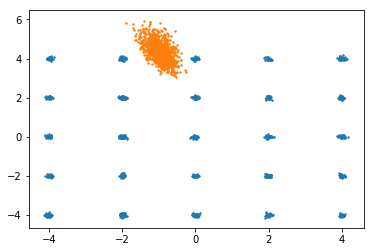

step 15000: discriminator: 1.385e+00, generator: 6.899e-01


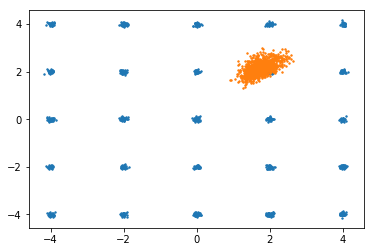

step 16000: discriminator: 1.383e+00, generator: 6.916e-01


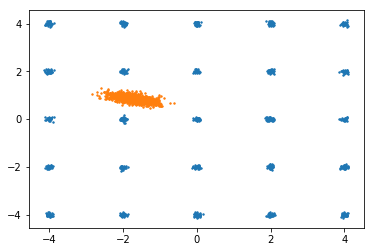

step 17000: discriminator: 1.387e+00, generator: 6.863e-01


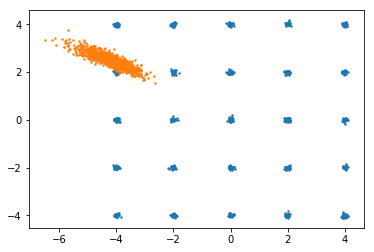

step 18000: discriminator: 1.386e+00, generator: 6.970e-01


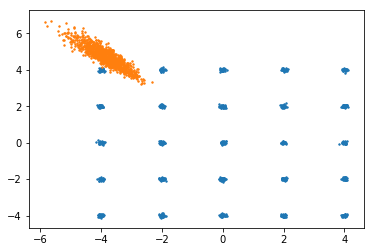

step 19000: discriminator: 1.386e+00, generator: 6.871e-01


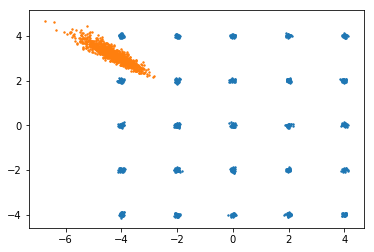

step 20000: discriminator: 1.387e+00, generator: 6.925e-01


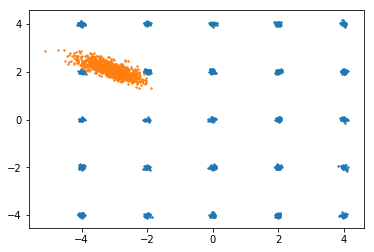

parameters: 50 7 512 64
step 0: discriminator: 1.338e+00, generator: 5.953e-01


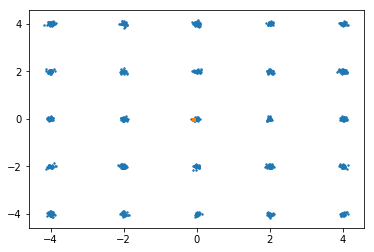

step 1000: discriminator: 4.261e+00, generator: 4.139e-02


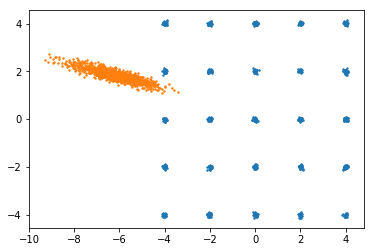

step 2000: discriminator: 2.088e+00, generator: 2.371e-01


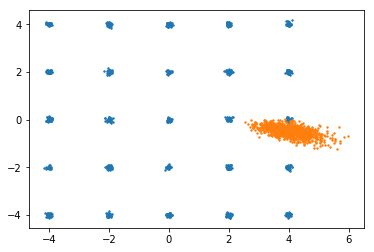

step 3000: discriminator: 1.384e+00, generator: 8.736e-01


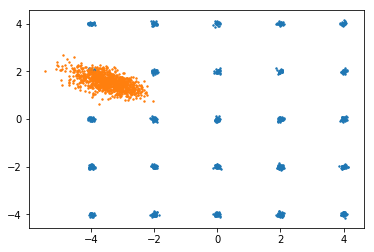

step 4000: discriminator: 1.783e+00, generator: 4.637e-01


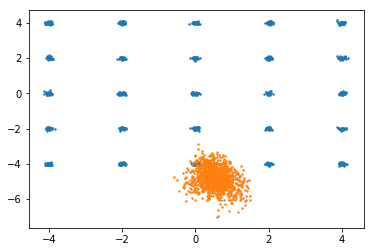

step 5000: discriminator: 9.572e-01, generator: 1.185e+00


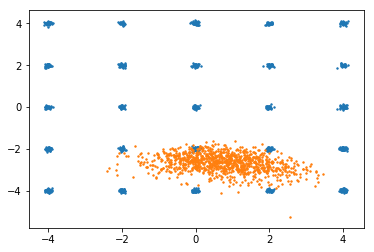

step 6000: discriminator: 9.907e-01, generator: 1.211e+00


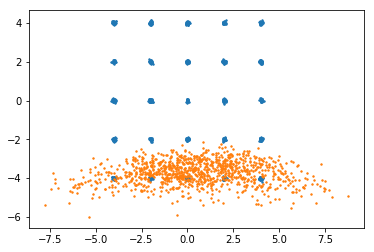

step 7000: discriminator: 1.293e+00, generator: 8.710e-01


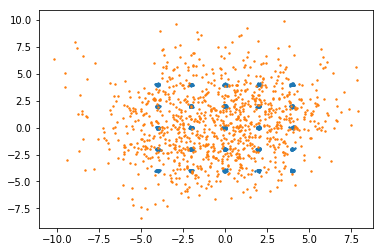

step 8000: discriminator: 1.120e+00, generator: 9.982e-01


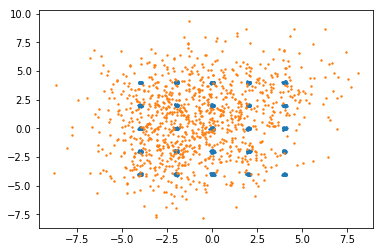

step 9000: discriminator: 1.114e+00, generator: 1.122e+00


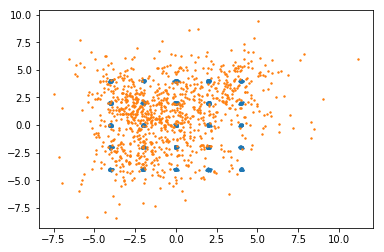

step 10000: discriminator: 1.066e+00, generator: 1.120e+00


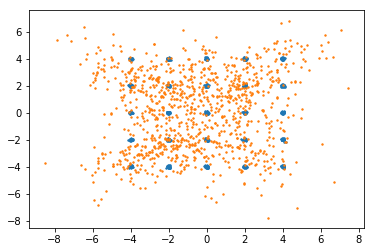

step 11000: discriminator: 1.010e+00, generator: 1.161e+00


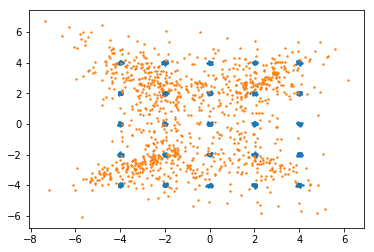

step 12000: discriminator: 9.204e-01, generator: 1.239e+00


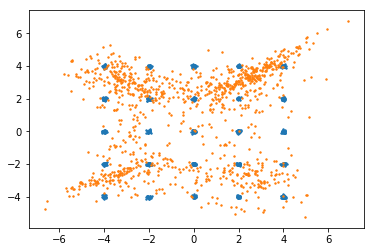

step 13000: discriminator: 8.268e-01, generator: 1.416e+00


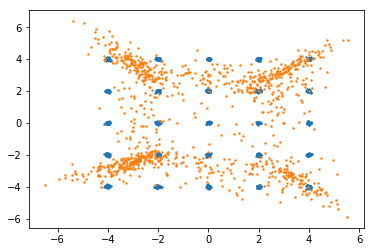

step 14000: discriminator: 7.780e-01, generator: 1.606e+00


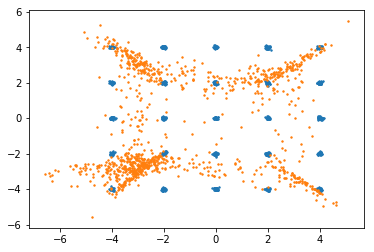

step 15000: discriminator: 8.985e-01, generator: 1.447e+00


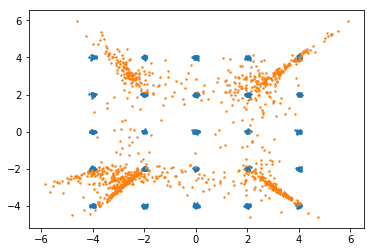

step 16000: discriminator: 7.514e-01, generator: 1.622e+00


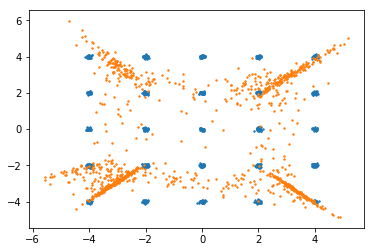

step 17000: discriminator: 8.585e-01, generator: 1.531e+00


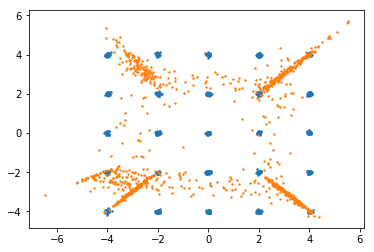

step 18000: discriminator: 8.849e-01, generator: 1.519e+00


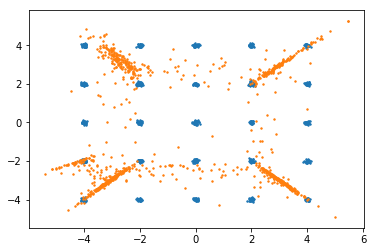

step 19000: discriminator: 7.585e-01, generator: 1.694e+00


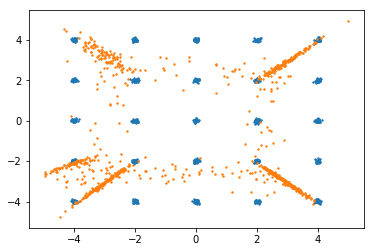

step 20000: discriminator: 7.478e-01, generator: 1.568e+00


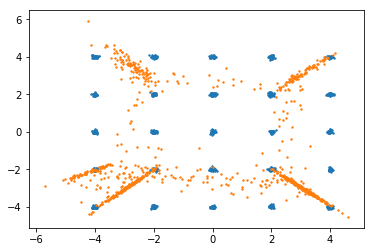

parameters: 50 7 512 32
step 0: discriminator: 1.403e+00, generator: 6.888e-01


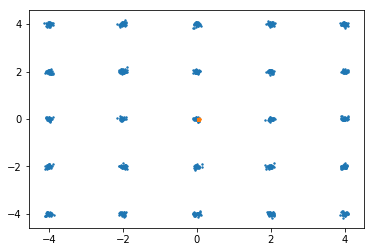

step 1000: discriminator: 1.919e+00, generator: 2.749e-01


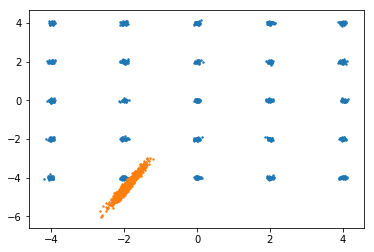

step 2000: discriminator: 7.402e+00, generator: 1.552e-03


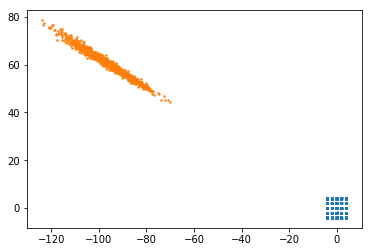

step 3000: discriminator: 2.519e+00, generator: 2.103e-01


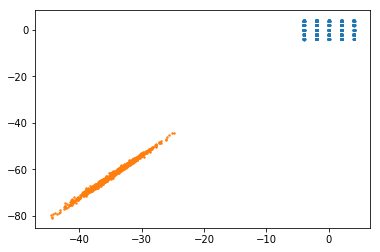

step 4000: discriminator: 1.390e+00, generator: 7.519e-01


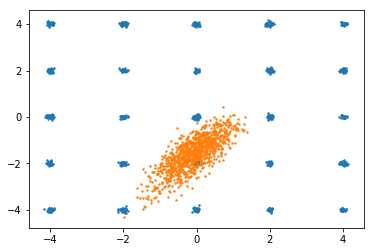

step 5000: discriminator: 1.386e+00, generator: 6.931e-01


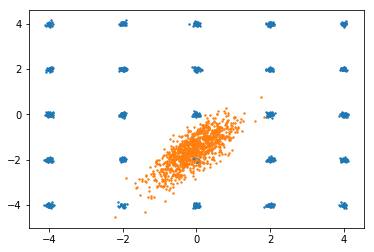

step 6000: discriminator: 1.386e+00, generator: 6.931e-01


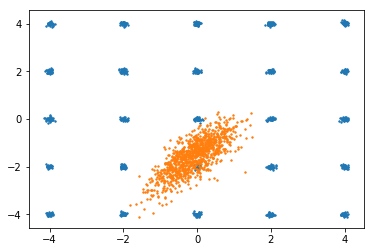

step 7000: discriminator: 1.386e+00, generator: 6.931e-01


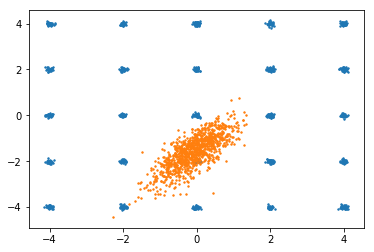

step 8000: discriminator: 1.386e+00, generator: 6.931e-01


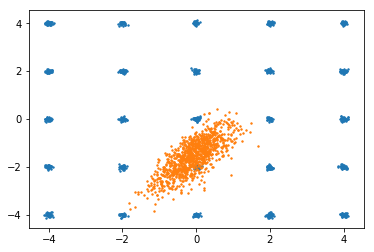

step 9000: discriminator: 1.386e+00, generator: 6.931e-01


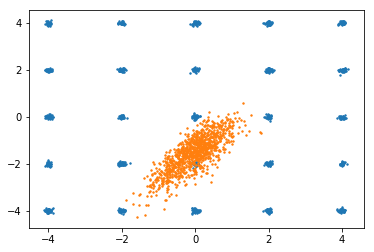

step 10000: discriminator: 1.386e+00, generator: 6.931e-01


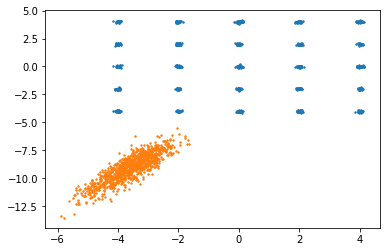

step 11000: discriminator: 1.386e+00, generator: 6.931e-01


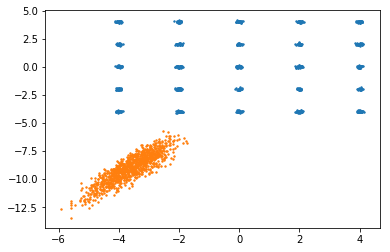

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


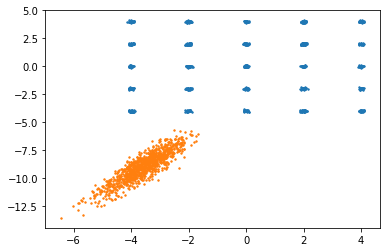

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


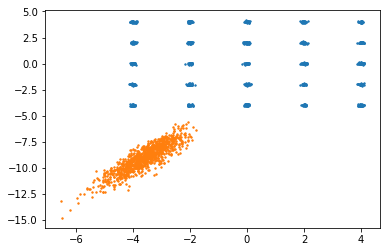

step 14000: discriminator: 1.386e+00, generator: 6.931e-01


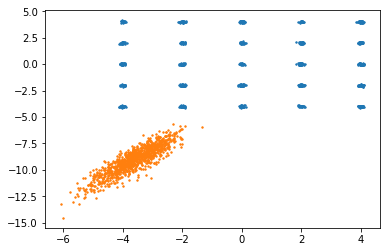

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


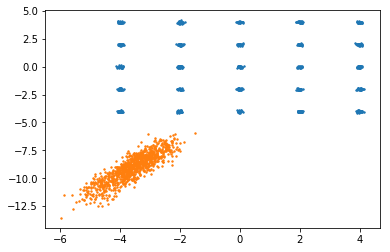

step 16000: discriminator: 1.386e+00, generator: 6.931e-01


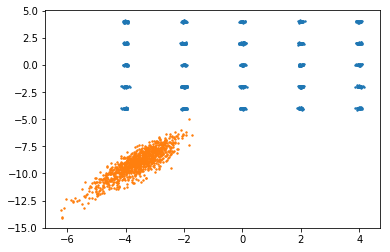

step 17000: discriminator: 1.386e+00, generator: 6.931e-01


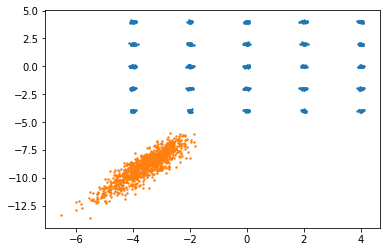

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


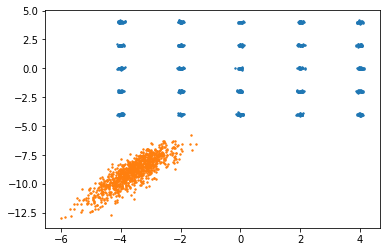

step 19000: discriminator: 1.386e+00, generator: 6.931e-01


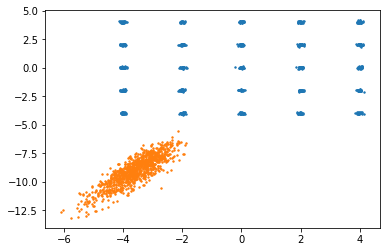

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


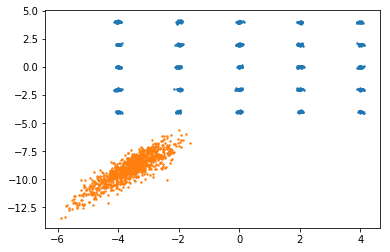

parameters: 50 7 256 64
step 0: discriminator: 1.551e+00, generator: 8.597e-01


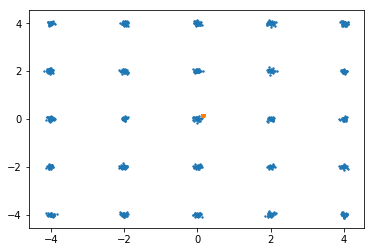

step 1000: discriminator: 2.036e+00, generator: 5.357e-01


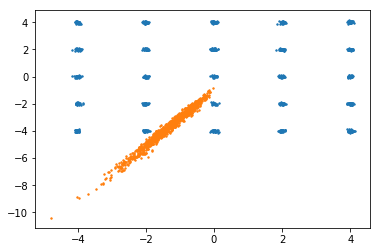

step 2000: discriminator: 3.028e+00, generator: 1.455e-01


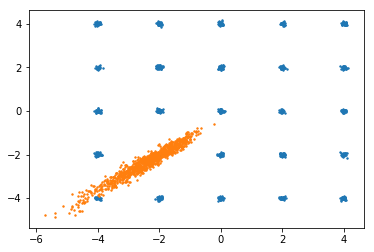

step 3000: discriminator: 1.059e+00, generator: 1.470e+00


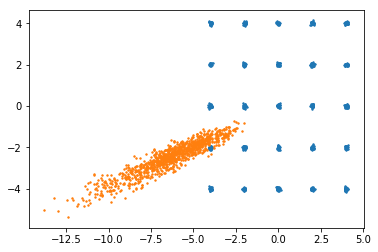

step 4000: discriminator: 2.664e+00, generator: 2.033e-01


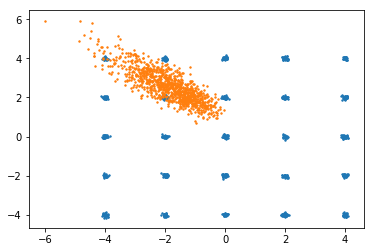

step 5000: discriminator: 9.500e-01, generator: 1.118e+00


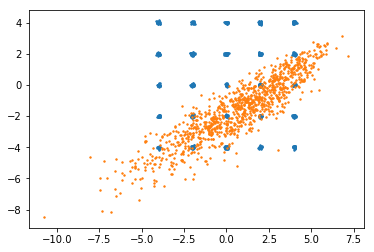

step 6000: discriminator: 8.670e-01, generator: 1.606e+00


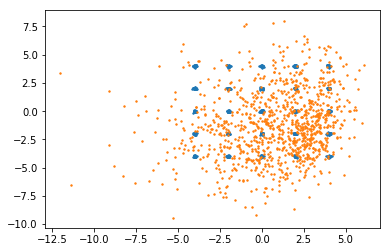

step 7000: discriminator: 4.964e-01, generator: 2.278e+00


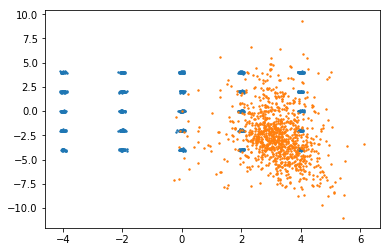

step 8000: discriminator: 2.780e-01, generator: 2.644e+00


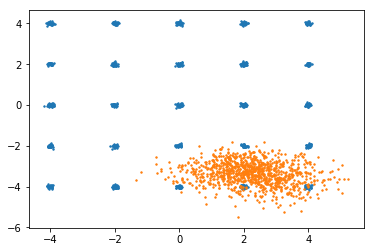

step 9000: discriminator: 2.432e-01, generator: 2.992e+00


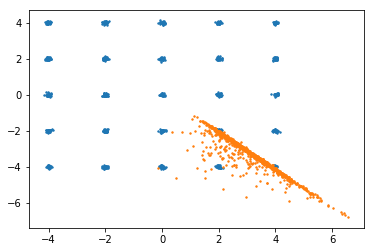

step 10000: discriminator: 2.628e-01, generator: 2.851e+00


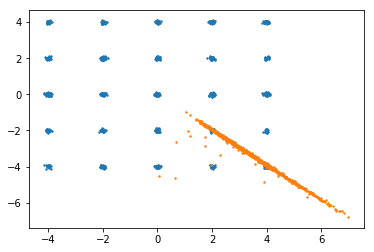

step 11000: discriminator: 1.764e-01, generator: 3.654e+00


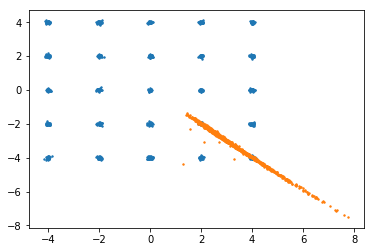

step 12000: discriminator: 1.967e-01, generator: 3.548e+00


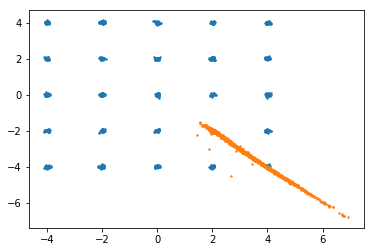

step 13000: discriminator: 1.955e-01, generator: 3.696e+00


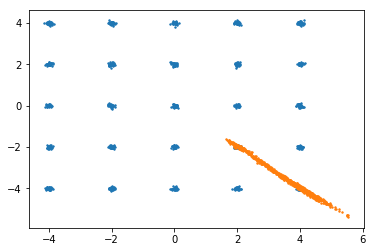

step 14000: discriminator: 2.239e-01, generator: 3.662e+00


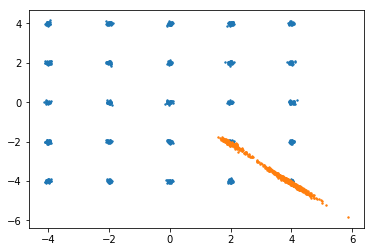

step 15000: discriminator: 2.438e-01, generator: 3.178e+00


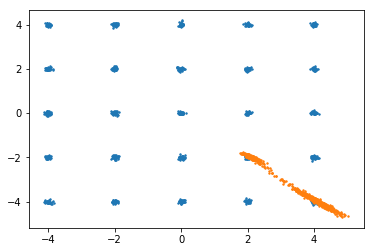

step 16000: discriminator: 2.541e-01, generator: 2.882e+00


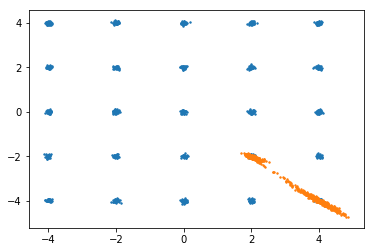

step 17000: discriminator: 2.595e-01, generator: 2.868e+00


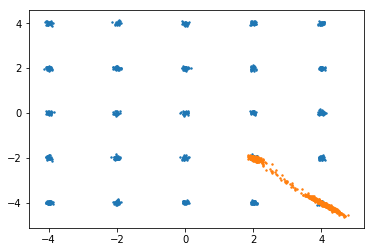

step 18000: discriminator: 2.223e-01, generator: 3.331e+00


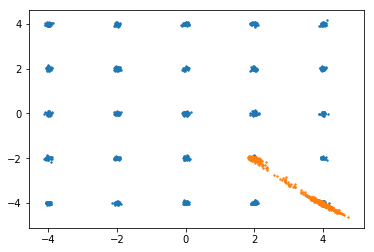

step 19000: discriminator: 2.407e-01, generator: 3.206e+00


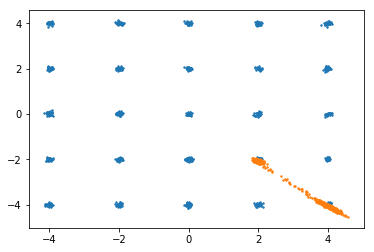

step 20000: discriminator: 2.081e-01, generator: 3.139e+00


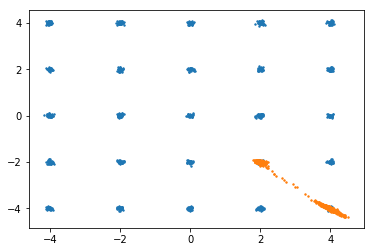

parameters: 50 7 256 32
step 0: discriminator: 1.402e+00, generator: 7.702e-01


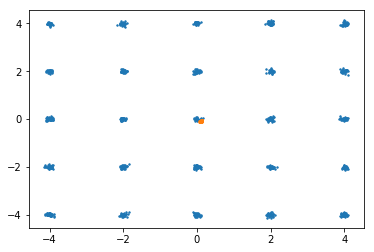

step 1000: discriminator: 9.414e-01, generator: 1.444e+00


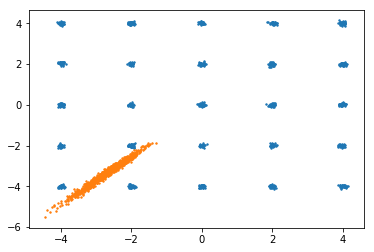

step 2000: discriminator: 1.027e+00, generator: 1.237e+00


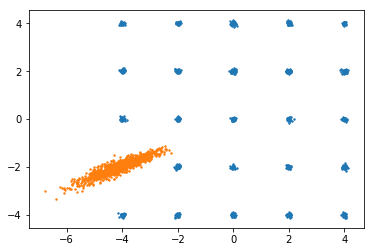

step 3000: discriminator: 2.079e+00, generator: 1.654e-01


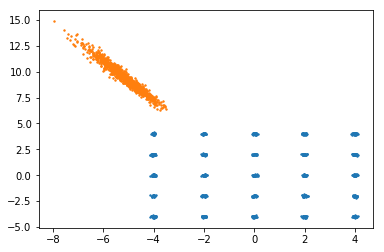

step 4000: discriminator: 3.507e+00, generator: 6.658e-02


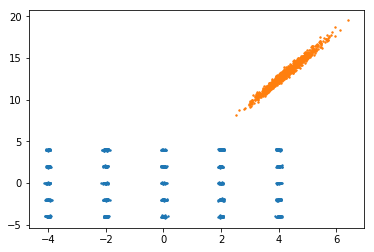

step 5000: discriminator: 1.026e+00, generator: 1.051e+00


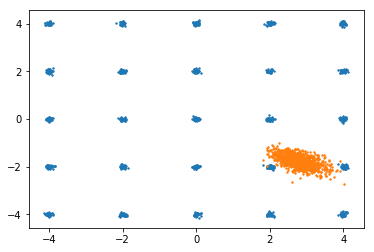

step 6000: discriminator: 9.827e-01, generator: 6.227e-01


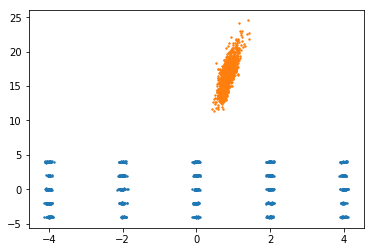

step 7000: discriminator: 1.274e+00, generator: 9.291e-01


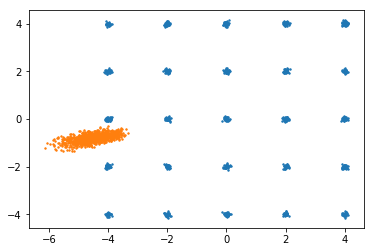

step 8000: discriminator: 1.130e+00, generator: 9.266e-01


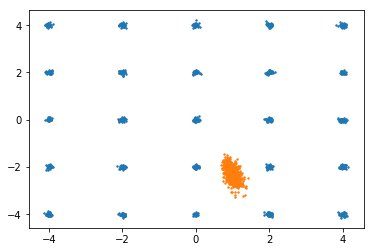

step 9000: discriminator: 3.242e+00, generator: 4.528e-01


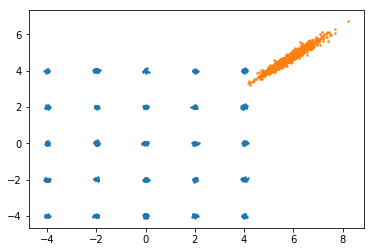

step 10000: discriminator: 3.511e+00, generator: 1.329e-01


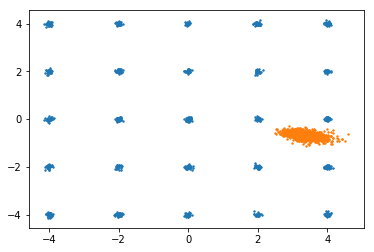

step 11000: discriminator: 1.050e+00, generator: 8.971e-01


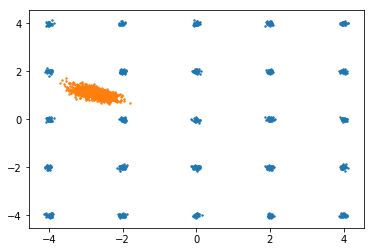

step 12000: discriminator: 9.911e-01, generator: 1.037e+00


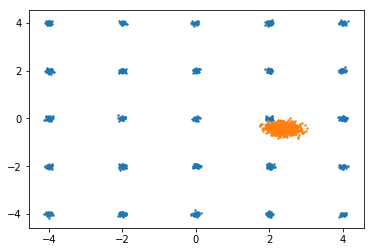

step 13000: discriminator: 2.296e+00, generator: 8.746e-01


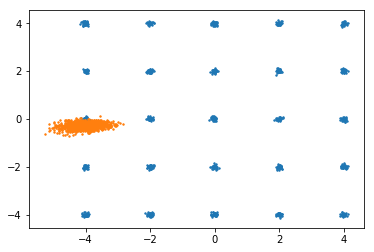

step 14000: discriminator: 1.118e+00, generator: 1.143e+00


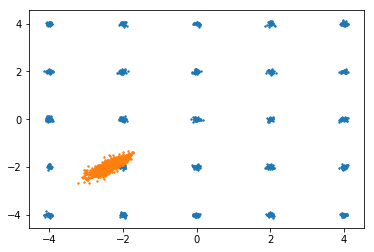

step 15000: discriminator: 1.006e+00, generator: 9.150e-01


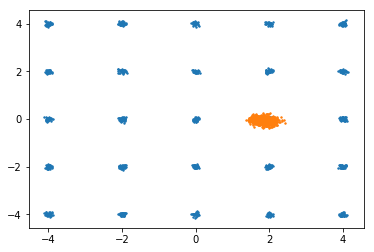

step 16000: discriminator: 1.120e+00, generator: 7.332e-01


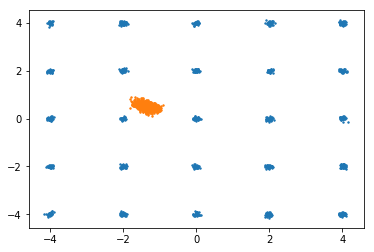

step 17000: discriminator: 8.987e-01, generator: 8.809e-01


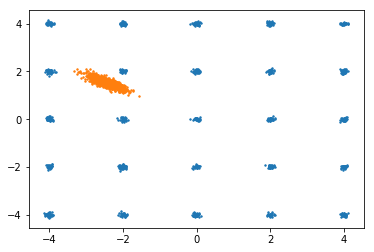

step 18000: discriminator: 6.281e-01, generator: 1.469e+00


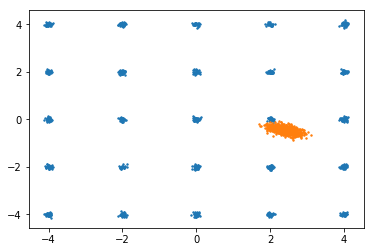

step 19000: discriminator: 6.014e+00, generator: 3.828e-03


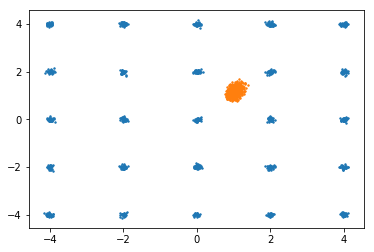

step 20000: discriminator: 7.111e-01, generator: 2.322e+00


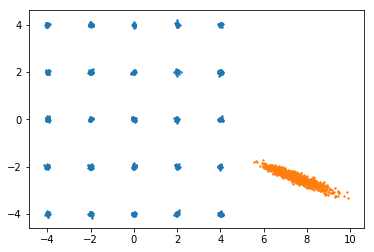

parameters: 50 20 512 64
step 0: discriminator: 1.435e+00, generator: 8.235e-01


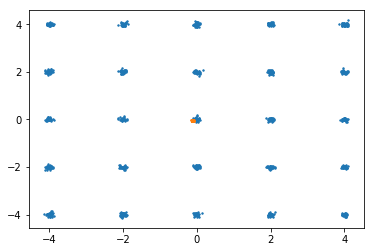

KeyboardInterrupt: 

In [95]:
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 256

        
def train_GAN(PRIOR_N, TRAIN_RATIO, width_gen, width_disc):
    #printing parameters
    print("parameters:", PRIOR_N, TRAIN_RATIO, width_gen, width_disc)
    # Define the generator
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(PRIOR_N, int(width_gen))
            self.fc2 = nn.Linear(int(width_gen), int(width_gen/2))
            self.fc3 = nn.Linear(int(width_gen/2), int(width_gen/4))
            self.fc4 = nn.Linear(int(width_gen/4), int(width_gen/8))
            self.fc5 = nn.Linear(int(width_gen/8), 2)

        def __call__(self, z):
            h = F.relu(self.fc1(z))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
            h = F.relu(self.fc4(h))
            return self.fc5(h)

        def generate(self, batchlen):
            z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
            return self.__call__(z)


    # Define the discriminator
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(2, int(width_disc))
            self.fc2 = nn.Linear(int(width_disc), int(width_disc/2))
            self.fc3 = nn.Linear(int(width_disc/2), int(width_disc/4))
            self.fc4 = nn.Linear(int(width_disc/4), 1)

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
            return self.fc4(h)


    discriminator_loss = []
    generator_loss = []

    generator = Generator()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
    discriminator = Discriminator()
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

    for i in range(N_ITER):

        # train the discriminator
        for _ in range(TRAIN_RATIO):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)

            # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
            # torch.softplus, using real_batch and fake_batch
            disc_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator(real_batch)))/BATCHLEN + torch.sum(torch.nn.Softplus(beta=1)(discriminator(fake_batch)))/BATCHLEN
            disc_loss.backward()
            optim_disc.step()

        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the generator loss, using fake_batch
        gen_loss = torch.sum(torch.nn.Softplus(beta=1)(-discriminator(fake_batch)))/BATCHLEN
        gen_loss.backward()
        optim_gen.step()
        discriminator_loss.append(disc_loss.detach())
        generator_loss.append(gen_loss.detach())
        if i%1000 == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()
    return [discriminator_loss,generator_loss,generator]
        
Dic_losses = {}
for PRIOR_N in [10,50]:
    for TRAIN_RATIO in [3,7,20]:
        for width_gen in [512,256]:
            for width_disc in [64,32]:
                Dic_losses[str(PRIOR_N)+' '+ str(TRAIN_RATIO)+' '+str(width_gen)+' '+str(width_disc)]=train_GAN(PRIOR_N, TRAIN_RATIO, width_gen, width_disc)
                

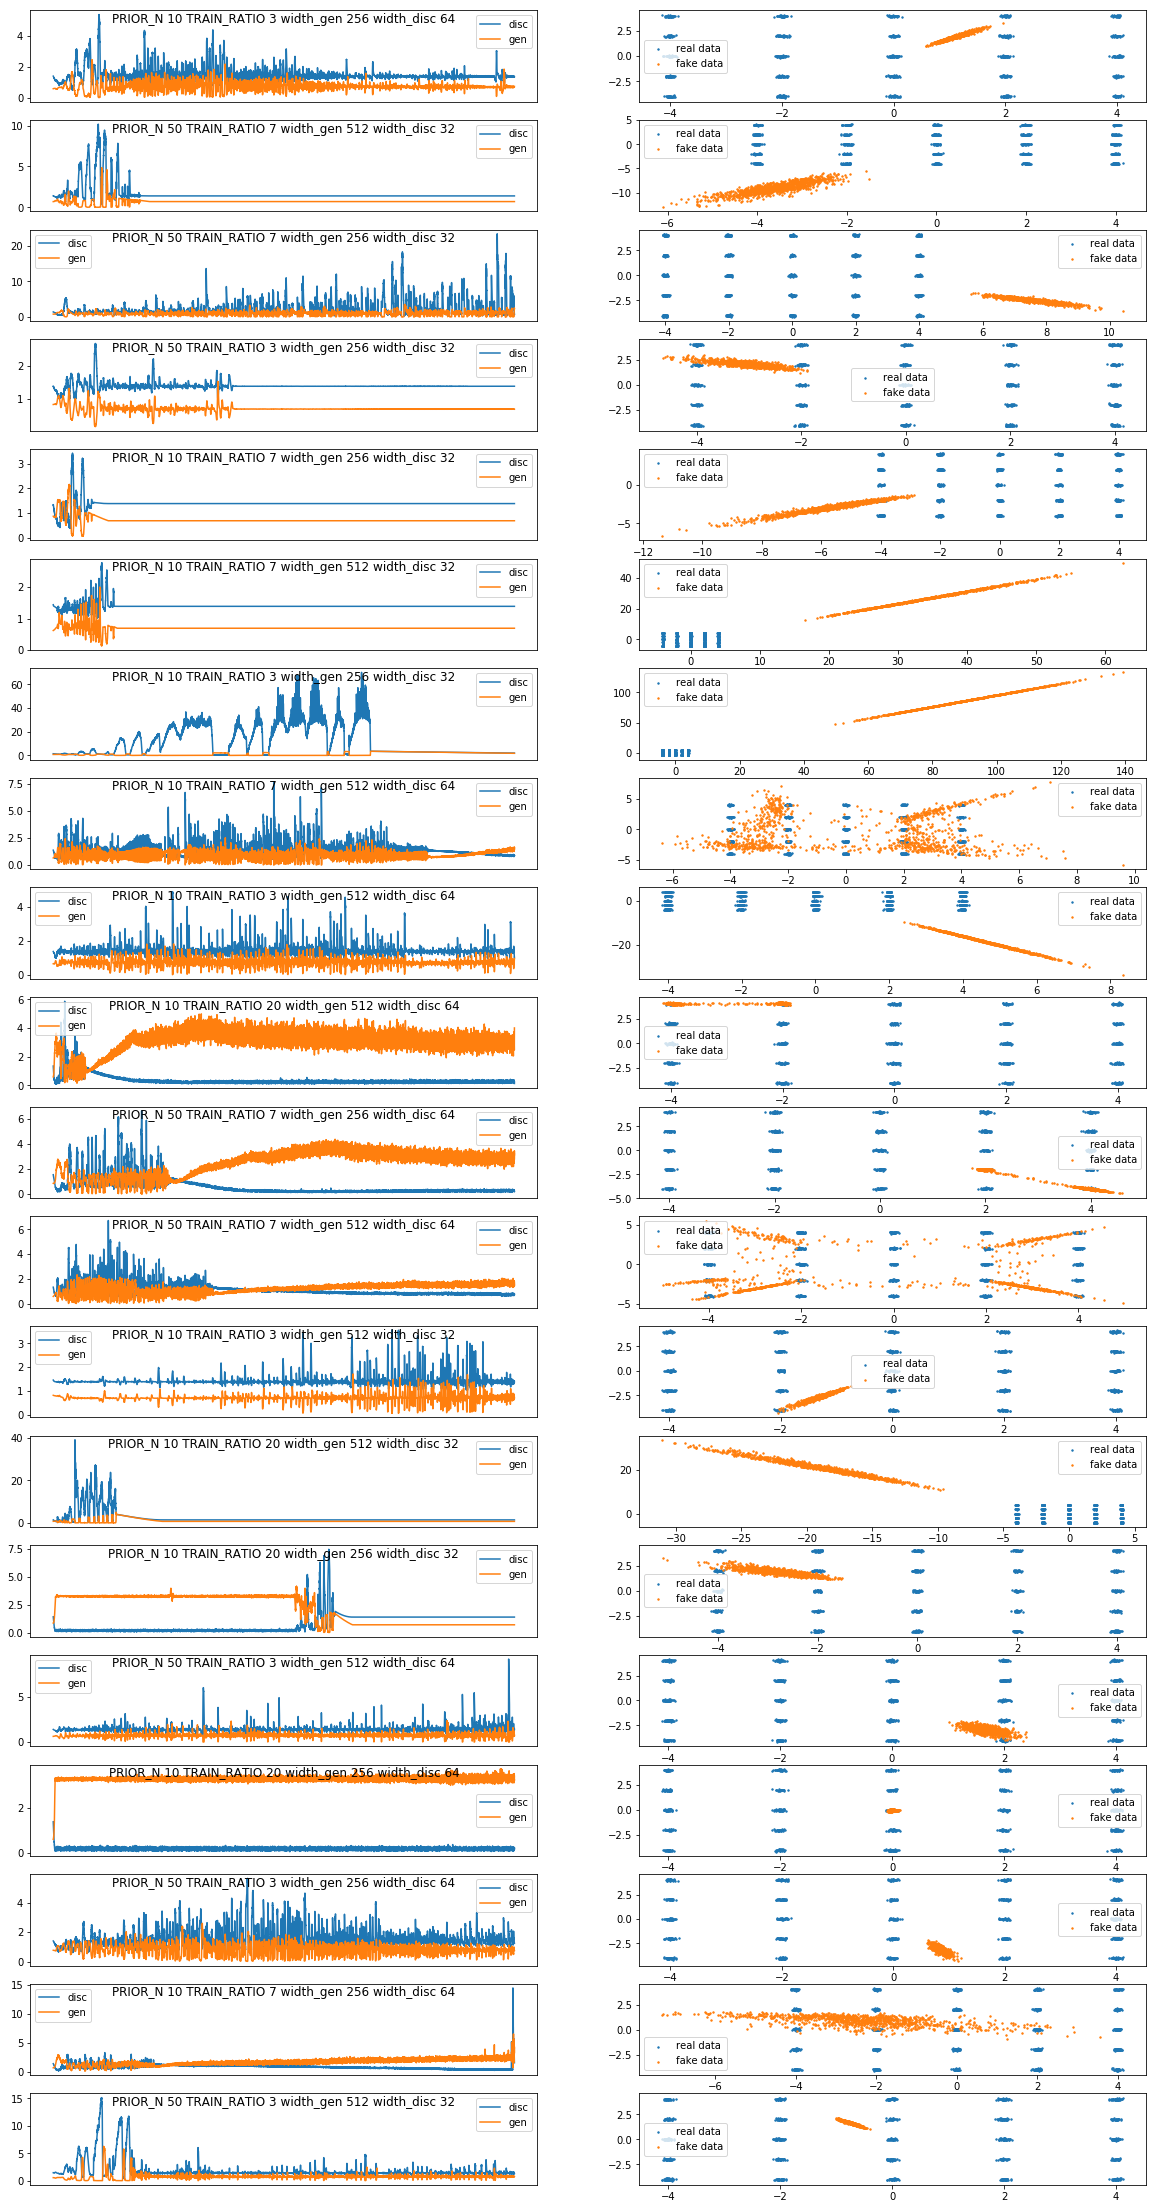

In [105]:
fig, a = plt.subplots(20,2, figsize=(20,40))
for i,l in enumerate(Dic_losses.items()):
    losses = l[1]
    parameters = l[0].split(" ")
    a[i,0].plot(losses[0],label='disc')
    a[i,0].plot(losses[1],label='gen')
    a[i,0].legend()
    a[i,0].set_xticks([])
    a[i,0].set_title('PRIOR_N '+ parameters[0]+' TRAIN_RATIO '+parameters[1]+' width_gen '+ parameters[2] + ' width_disc '+ parameters[3],x=0.5, y=0.8)
    fake_batch = l[1][2].generate(1024).detach()
    real_batch = generate_batch(1024)
    a[i,1].scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    a[i,1].scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    a[i,1].legend()
plt.savefig('GAN hyperparameters exploration 2')

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

<font color='blue'>

> $$ \mathbb{E}_{P_{D}}[\log(p_{\theta}(𝑥)] = \int_{R^{2}}\log(p_{\theta}(𝑥)dp_{D}(𝑥) = \int_{R^{2}}\log(\frac{p_{\theta}(𝑥)}{p_{D}(𝑥)})dp_{D}(𝑥) + H(p_{D}) =  H(p_{D}) - D_{KL}(p_D \| p_\theta)$$
Hence, 
> $$argmax_{\theta} \mathbb{E}_{p_D} \log p_\theta(x) = argmax_{\theta} H(p_{D}) - D_{KL}(p_D \| p_\theta) = argmin_{\theta} D_{KL}(p_D \| p_\theta) $$ 

>given that the entropy of $p_{D}$ does not depend on $\theta$.

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

<font color='blue'>

> Their will be some subset of the space of Z from which we won't know the decoder output as the encoder might not explore those subsets. Hence this is hugely dependant from the data used for training. That means will have partial control on the representations of the decoder.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^{2}(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

<font color='blue'>
    
Let us write the epression of the KL divergence for 2 multivariate gaussian distributions, 

>$D_{KL}(q_\phi(z | x) \| p(z)) = \int_{R^{N}}\log(\frac{f_{q_{\phi}}(z|x)}{f_{N(0,Id)}(z)})f_{q_{\phi}}(z|x)dz$


>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}\int_{R^{N}}\log(\frac{1}{|\Sigma_{𝜙(𝑥)}|})f_{q_{\phi}}(z|x)dz + \frac{1}{2}\int_{R^{N}}\log(e^{-\frac{1}{2}(z-\mu)^{t} \Sigma^{-1} (z-\mu) + z^{t}z})\frac{e^{-\frac{1}{2}(z^{t}-\mu) \Sigma^{-1}(z-\mu)}}{(2\pi)^{N/2}|\Sigma_{𝜙(𝑥)}|}dz$

>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}\log(\frac{1}{|\Sigma_{𝜙(𝑥)}|}) + \frac{1}{2}\int_{R^{N}}(z^{t}z - (z-\mu)^{t} \Sigma^{-1} (z-\mu))\frac{e^{-\frac{1}{2}(z^{t}-\mu) \Sigma^{-1} (z-\mu)}}{(2\pi)^{N/2}|\Sigma_{𝜙(𝑥)}|}dz$

>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}\log(\frac{1}{\prod\limits_{i=1}^{N}\sigma_{\phi^{i}(𝑥)}^{2}}) + \frac{1}{2}\int_{R^{N}}\frac{1}{(2\pi)^{N/2}|\Sigma_{𝜙(𝑥)}|}\sum\limits_{i=1}^{N}( z_{i}^{2} - \frac{(z_{i}-\mu_{i})^{2}}{\sigma_{\phi_i}^{2}})\prod\limits_{j=1}^{N}e^{-\frac{-(z_{j}-\mu_{j})^{2}}{2\sigma_{\phi_j}^{2}}}dz$


hence, by independance of the marginal distributions of the gaussian multivariate distribution, we can write: 


>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}\log(\frac{1}{\prod\limits_{i=1}^{N}\sigma_{\phi^{i}(𝑥)}^{2}}) + \frac{1}{2}\sum\limits_{i=1}^{N}\int_{R}\frac{1}{(2\pi)^{1/2}\sigma_{𝜙^{i}(𝑥)}^{2}}(z_{i}^{2} - \frac{(z_{i}-\mu{i})^{2}}{\sigma_{\phi^{i}}^{2}}) e^{\frac{-(z_{i}-\mu_{i})^{2}}{2\sigma_{\phi^{i}}^{2}}}dz_{i}\prod\limits_{j=1,j≠i}^{N}\int_{R^{N-1}}\frac{1}{(2\pi)^{(N-1)/2}\sigma_{𝜙^{j}(𝑥)}^{2}}e^{\frac{-(z_{j}-\mu_{j})^{2}}{2\sigma_{\phi^{j}}^{2}}}dz_{1}....dz_{N}$


>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}[-\sum\limits_{i=1}^{N}\log(\sigma_{\phi^{i}}^{2}(𝑥)) + \sum\limits_{i=1}^{N}\mathbb{E}_{z_{i}\sim N(\mu_{i},\sigma_{\phi^{i}})}[z_{i}^{2} - \frac{(z_{i}-\mu{i})^{2}}{\sigma_{\phi^{i}}^{2}}(𝑥)] $


>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}[-\sum\limits_{i=1}^{N}\log(\sigma_{\phi^{i}}^{2}(𝑥)) + \sum\limits_{i=1}^{N}(\sigma_{\phi^{i}}^{2}(𝑥) + \mu_{i}^{2}) - N]$



We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

<font color='blue'>

>Here again, by independance of the variables (The covariance matric is diagonal),

>$-\log p_\theta(x | z) = -\log(\frac{1}{(2\pi)^{N/2}|\Sigma_{\theta(z)}|^{1/2}}\prod\limits_{i=1}^{N}e^{-\frac{(x_{i}-\mu_{\theta^{i}}(z))^{2}}{2\sigma^{2}_{\theta^{i}}(z)}})$


>$-\log p_\theta(x | z) = \frac{N}{2}\log(2\pi) + \sum\limits_{i=1}^{N} \log(\sigma_{\theta^{i}}(z)) + \sum\limits_{i=1}^{N}\frac{(x_{i}-\mu_{\theta^{i}}(z))^{2}}{2\sigma^{2}_{\theta^{i}}(z)})$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [179]:
# Choose a value for the latent dimension
LATENT_N = 25

# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, LATENT_N)
        self.fc_logvar = nn.Linear(32, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc_mu = nn.Linear(256, 2)
        self.fc_logvar = nn.Linear(256, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

<font color='blue'>

>  In order to sample a distribution that is differentiable w.r.t to $\mu$ and $\sigma$, we could use the fact that every normal distribution $Y = \mathcal{N}(\mu, \sigma)$ can be rewritten as a shift and scale of the standard normal distribution $ U = \mathcal{N}(0,1)$ with the equation $ Y = \sigma U + \mu$. In this form, Y becomes differentiable w.r.t to $\mu$ and $\sigma$.

step 0: KL: 1.619e+03, rec: 1.098e+03


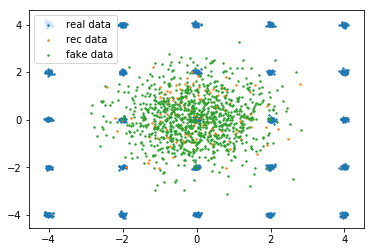

step 1000: KL: 2.516e+03, rec: -1.386e+03


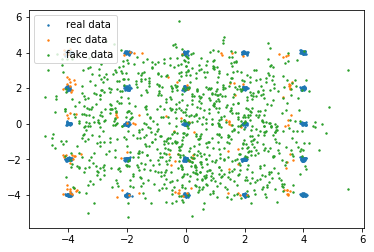

step 2000: KL: 2.629e+03, rec: -1.659e+03


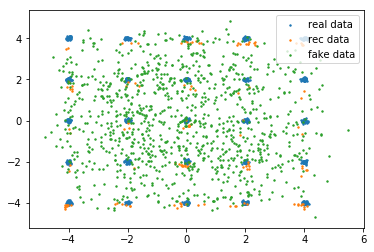

step 3000: KL: 2.585e+03, rec: -2.374e+03


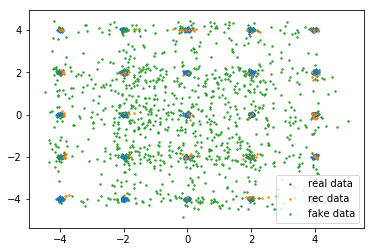

step 4000: KL: 2.548e+03, rec: -2.571e+03


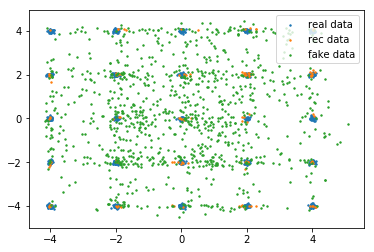

step 5000: KL: 2.488e+03, rec: -2.236e+03


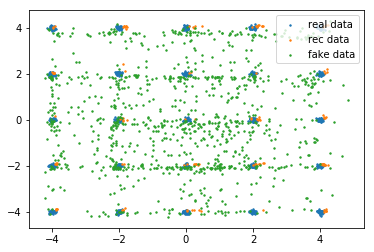

step 6000: KL: 2.477e+03, rec: -2.898e+03


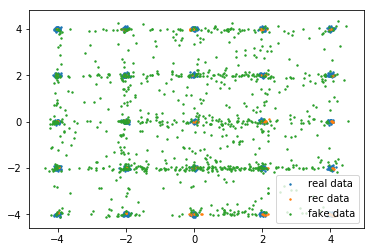

step 7000: KL: 2.473e+03, rec: -2.869e+03


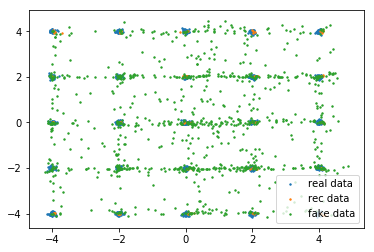

step 8000: KL: 2.447e+03, rec: -2.285e+03


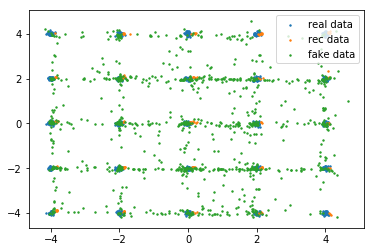

step 9000: KL: 2.420e+03, rec: -2.937e+03


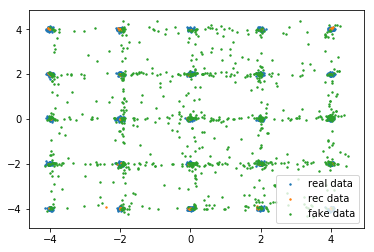

step 10000: KL: 2.324e+03, rec: -2.898e+03


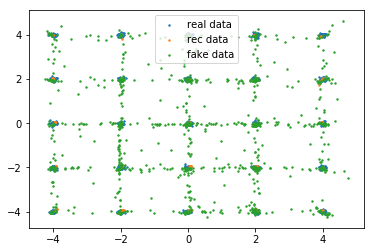

In [180]:
from torch.distributions import Normal
# Total number of training iterations for the VAE
N_ITER = 10001
# Batch size to use
BATCHLEN = 128

loss_kl_ = []
loss_rec_ = []

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    enc_mu, enc_logvar = encoder(x)
    
    # Compute here the DKL part of the VAE loss
    loss_kl = 0.5*(-torch.sum(enc_logvar) + torch.sum(torch.exp(enc_logvar)) + torch.sum(enc_mu**2) - torch.tensor(LATENT_N))

    # Compute here the sample z, using Q12
    enc_var = torch.exp(0.5*enc_logvar)
    normal_dist_q = Normal(0,torch.ones(BATCHLEN, LATENT_N))
    z = torch.mul(normal_dist_q.rsample(),enc_var) + enc_mu #differentiable thanks to torch.distributions.Normal class
    dec_mu, dec_logvar = decoder(z)
    
    # Compute here the second part of the VAE loss
    dec_std = torch.exp(0.5*dec_logvar)
    loss_rec = torch.sum(dec_logvar) + 0.5*torch.sum(((x-dec_mu)**2)/dec_std) 
    #l'utilisation de la std plutot que la variance entraine un entrainement 
    #plus équilibré entre les 2 termes de la loss et des résultats plus "réalistes"

    loss_kl_.append(loss_kl)
    loss_rec_.append(loss_rec)
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

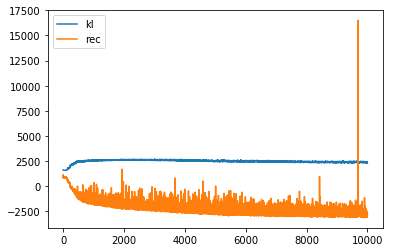

In [181]:
plt.plot(loss_kl_, label='kl')
plt.plot(loss_rec_, label='rec')
plt.legend()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

step 0: KL: 1.622e+03, rec: 9.677e+04


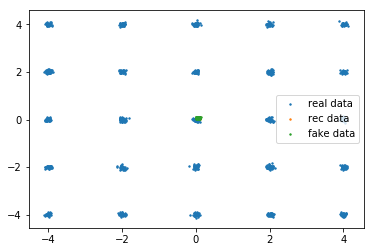

step 1000: KL: 2.881e+03, rec: 7.636e+02


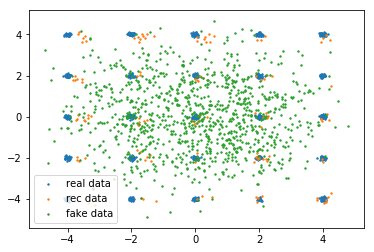

step 2000: KL: 2.620e+03, rec: 5.590e+02


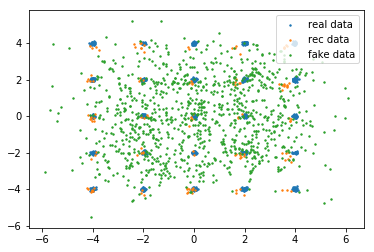

step 3000: KL: 2.358e+03, rec: 2.584e+02


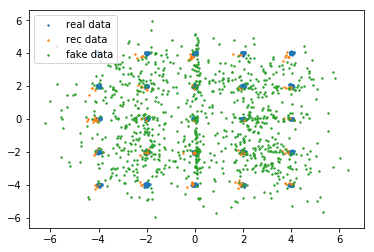

step 4000: KL: 2.353e+03, rec: 5.071e+01


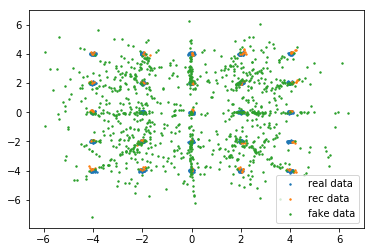

step 5000: KL: 2.282e+03, rec: 9.156e+01


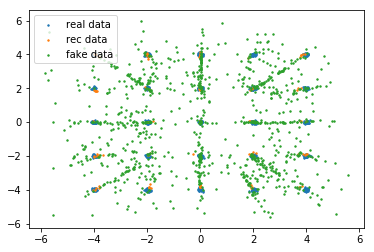

step 6000: KL: 2.282e+03, rec: 2.809e+01


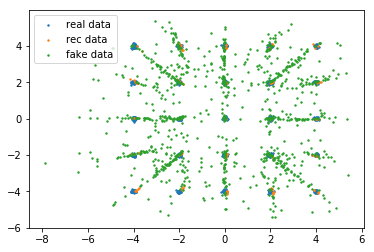

step 7000: KL: 2.299e+03, rec: 1.616e+02


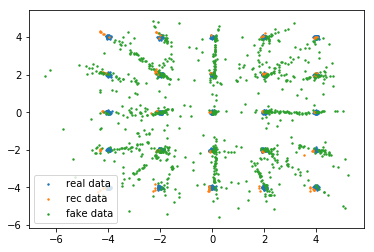

step 8000: KL: 2.231e+03, rec: 5.470e+01


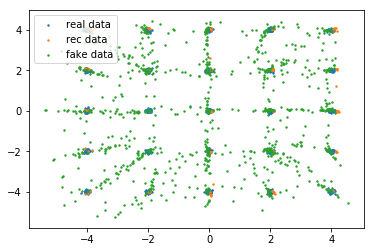

step 9000: KL: 2.261e+03, rec: 5.566e+01


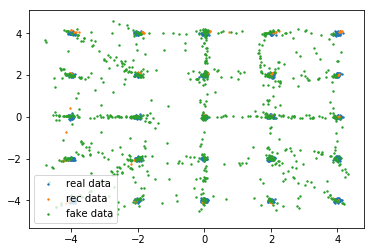

step 10000: KL: 2.213e+03, rec: 4.296e+01


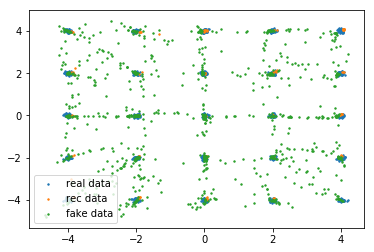

In [190]:
# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, LATENT_N)
        self.fc_logvar = nn.Linear(32, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc_mu = nn.Linear(256, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        mu = self.fc_mu(h)
        return (mu)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        mu = self.__call__(z)
        return torch.normal(mu, 0.01)

# Total number of training iterations for the VAE
N_ITER = 10001
# Batch size to use
BATCHLEN = 128

loss_kl_ = []
loss_rec_ = []

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    enc_mu, enc_logvar = encoder(x)
    
    # Compute here the DKL part of the VAE loss
    loss_kl = 0.5*(-torch.sum(enc_logvar) + torch.sum(torch.exp(enc_logvar)) + torch.sum(enc_mu**2) - LATENT_N)

    # Compute here the sample z, using Q12
    enc_var = torch.exp(0.5*enc_logvar)
    
    normal_dist_q= Normal(0,torch.ones(BATCHLEN, LATENT_N))
    z = torch.mul(normal_dist_q.rsample(),enc_var) + enc_mu
    #z =  torch.mul(torch.normal(0,torch.ones(BATCHLEN, LATENT_N)),enc_var) + enc_mu
    dec_mu = decoder(z)
    
    # Compute here the second part of the VAE loss
    loss_rec = torch.sum(torch.log(torch.ones(LATENT_N)*0.01)) + 0.5*torch.sum(((x-dec_mu)**2)/0.01)

    loss_kl_.append(loss_kl)
    loss_rec_.append(loss_rec)
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

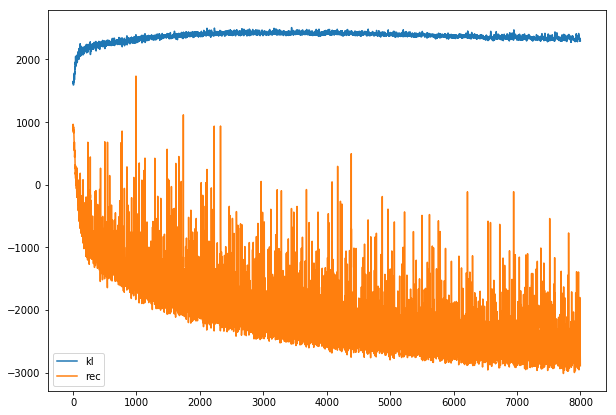

In [214]:
plt.figure(figsize=(10,7))
plt.plot(loss_kl_[:8000], label='kl')
plt.plot(loss_rec_[:8000], label='rec')
plt.legend()

<font color='blue'>

> Intuitively, hardcoding the variance of the decoder to a small value will force the encoder to yeald a latent representation that take into account this small scale enforced variation. It is as if we trained the encoder for the **most representative distribution given the decoder variance restriction**.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

step 0: KL: 1.623e+03, rec: 9.478e+02


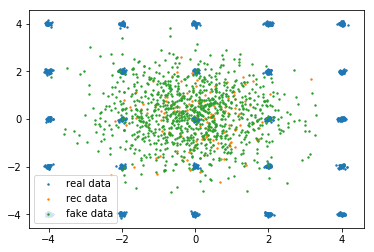

step 1000: KL: 2.276e+03, rec: -1.455e+03


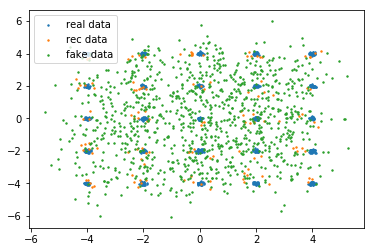

step 2000: KL: 2.397e+03, rec: -2.037e+03


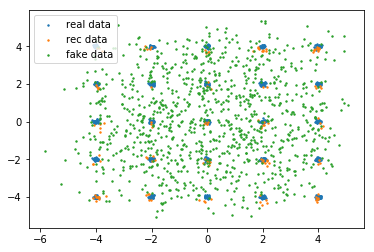

step 3000: KL: 2.412e+03, rec: -2.084e+03


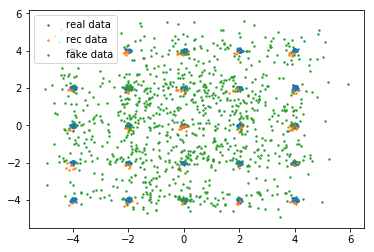

step 4000: KL: 2.405e+03, rec: -2.262e+03


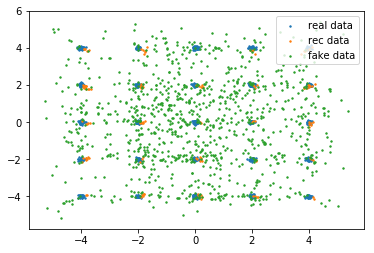

step 5000: KL: 2.396e+03, rec: -2.604e+03


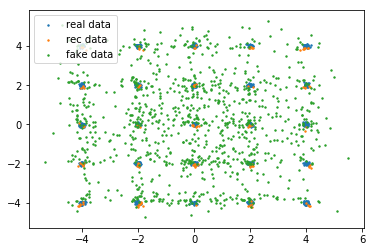

step 6000: KL: 2.388e+03, rec: -2.733e+03


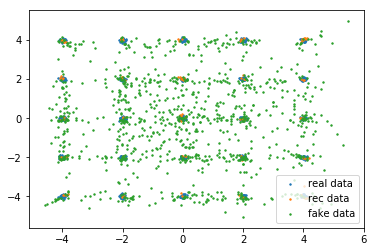

step 7000: KL: 2.333e+03, rec: -2.362e+03


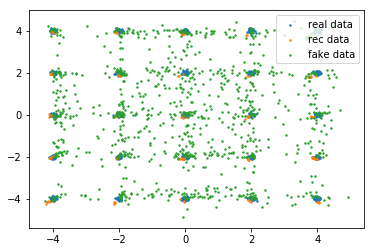

step 8000: KL: 2.280e+03, rec: -2.874e+03


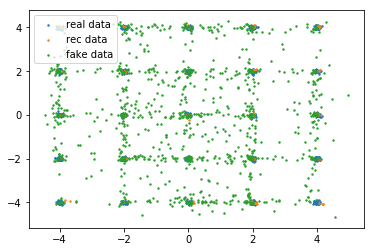

step 9000: KL: 2.321e+03, rec: -2.933e+03


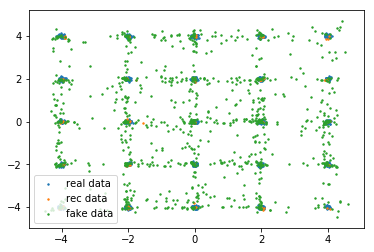

step 10000: KL: 2.344e+03, rec: -2.784e+03


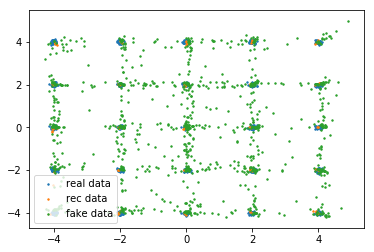

In [212]:
# Choose a value for the latent dimension
LATENT_N = 25

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc_mu = nn.Linear(256, LATENT_N)
        self.fc_logvar = nn.Linear(256, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        #h = F.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 256)
        #self.fc4 = nn.Linear(128, 256)
        self.fc_mu = nn.Linear(256, 2)
        self.fc_logvar = nn.Linear(256, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        #h = F.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))
    
    

N_ITER = 10001
# Batch size to use
BATCHLEN = 128

loss_kl_ = []
loss_rec_ = []

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    enc_mu, enc_logvar = encoder(x)
    
    # Compute here the DKL part of the VAE loss
    loss_kl = 0.5*(-torch.sum(enc_logvar) + torch.sum(torch.exp(enc_logvar)) + torch.sum(enc_mu**2) - torch.tensor(LATENT_N))

    # Compute here the sample z, using Q12
    enc_std = torch.exp(0.5*enc_logvar)
    normal_dist_q = Normal(0,torch.ones(BATCHLEN, LATENT_N))
    z = torch.mul(normal_dist_q.rsample(),enc_std) + enc_mu
    dec_mu, dec_logvar = decoder(z)
    
    # Compute here the second part of the VAE loss
    dec_var = torch.exp(0.5*dec_logvar)
    loss_rec = torch.sum(dec_logvar) + 0.5*torch.sum(((x-dec_mu)**2)/dec_var)

    loss_kl_.append(loss_kl)
    loss_rec_.append(loss_rec)
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

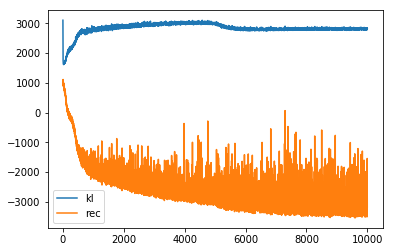

In [199]:
plt.plot(loss_kl_, label='kl')
plt.plot(loss_rec_, label='rec')
plt.legend()

<font color='blue'>

> Decreasing encoder and decoder representation power (i.e increasing their depth and width) results logically in a "fuzzier" distribution of our generated data but not in a significant change in the reconstructed data nor in the profil of training losses of encoder and decoder. This means that the decoder is more dependant to the complexity of the network architecture to yeald data whih distribution is realistic.

> Conversely, increasing too much the representation power only slow down the training process. This might be due to the simplicity of our data as a 'light' network is already able to represente the data distribution. Hence since the training temporal performance is deteriorated by increasing the complewity of the models, we should opt for the simplest architecture.

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

<font color='blue'>

> As a probabilistic graphical models, **VAES** are useful to learn a latent modelization of a probability distributionto by mapping it to a smaller dimensional representation. An advantage of VAES is the ability to set desired priors in the latent especially in cases where one know something should make sense or have a desired latent distribution. They can make decent generation of data even though they tend to approximate roughly the probability distribution by spreading probability mass to places where it might not make sense. (The blurry cluster observed in our experimentation) Hence they seem more relevant when the work objective is explicitly related to the latent representation of the data. 

> **GANS** however are specificaly set up to optimize for generative tasks. Hence they yeald far more 'realistic' outputs (while they also present the problem of mode dropping during the traning process). However the interpretation of the distribution of the data is much harder as the objective function is not explicitely known but represented by the discriminator network. In terms of training, the GAN framework recquires particular attention to the equilibrium between generator and discriminator during the process, in order to avoid the collapsing of one of the two networks.

> In order to bridge these differents, one could think about combining GAN and VAE. This is the work presented in **Autoencoding, beyond pixels using a learned similarity metric** where the two models are combined and the generator is replaced by a variational autoencoder. This work improves outputs quality compared to vanilla VAE and the output diversity compared to vanilla GANS.
